# Model Performance Analysis: Per-Class Metrics and Event Length Statistics

This notebook analyzes model performance across different classes and calculates event length statistics.

## Objectives:
1. Visualize per-class model performance (precision, recall, f-measure)
2. Identify classes where the model performs well vs poorly
3. Calculate mean and median event lengths for each class
4. Analyze both episodic training outputs and main validation evaluation


In [50]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10


## Configuration

Set paths to your experiment outputs and data directories.


In [51]:
# Configuration - Paths are resolved relative to the notebook location
import os

# Detect project root - works in both Jupyter and regular Python
# Try multiple methods to find the project root
def find_project_root():
    """Find the project root directory."""
    # Method 1: Check if we're in a notebooks/ subdirectory
    cwd = Path.cwd()
    if cwd.name == 'notebooks' and (cwd.parent / 'outputs').exists():
        return cwd.parent
    
    # Method 2: Look for outputs directory in current or parent directories
    current = Path.cwd()
    for _ in range(3):  # Check up to 3 levels up
        if (current / 'outputs' / 'mlflow_experiments').exists():
            return current
        current = current.parent
    
    # Method 3: Try absolute path
    abs_path = Path("/export/home/4prasad/uhh_project_dsai")
    if (abs_path / 'outputs' / 'mlflow_experiments').exists():
        return abs_path
    
    # Method 4: Default to current directory
    return Path.cwd()

PROJECT_ROOT = find_project_root()

# Base directory containing all experiments
EXPERIMENT_BASE_DIR = PROJECT_ROOT / "outputs" / "mlflow_experiments"

# If that doesn't exist, try absolute path
if not EXPERIMENT_BASE_DIR.exists():
    EXPERIMENT_BASE_DIR = Path("/export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments")

TRAIN_DATA_DIR = Path("/data/msc-proj/Training_Set")  # Path to training data with CSV annotations
EVAL_METADATA_PATH = PROJECT_ROOT / "utils" / "eval_meta" / "subset_meta.csv"  # Path to evaluation metadata

# Analysis mode
# Option 1: Analyze ALL experiments
ANALYZE_ALL_EXPERIMENTS = True  # Set to True to analyze all experiments

# Option 2: Analyze SELECTED experiments only
# Set ANALYZE_ALL_EXPERIMENTS = False and specify experiment names below
SELECTED_EXPERIMENTS = [
    # Example: Select specific experiments
    # 'v1-logmel-f',
    # 'v1-pcen-f',
    # 'v2-logmel-neg-contrast-f',
]

# For main evaluation (from CLI evaluate command)
MAIN_EVAL_DIR = None  # Path to main evaluation output directory (from `python main.py evaluate`)

print("Configuration loaded.")
print(f"Current working directory: {Path.cwd()}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Experiment base dir: {EXPERIMENT_BASE_DIR}")
print(f"Experiment base dir exists: {EXPERIMENT_BASE_DIR.exists()}")

if not EXPERIMENT_BASE_DIR.exists():
    print(f"\n⚠️  WARNING: Experiment directory not found at: {EXPERIMENT_BASE_DIR}")
    print(f"   Please check the path or update EXPERIMENT_BASE_DIR manually.")
    print(f"   Expected location: outputs/mlflow_experiments/")
else:
    print(f"✓ Experiment directory found!")


Configuration loaded.
Current working directory: /export/home/4prasad/uhh_project_dsai/notebooks
Project root: /export/home/4prasad/uhh_project_dsai
Experiment base dir: /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments
Experiment base dir exists: True
✓ Experiment directory found!


## 0. Discover All Experiments

This section scans the outputs directory to find all experiments and extract their metadata.


In [52]:
def discover_experiments(base_dir: Path) -> pd.DataFrame:
    """
    Discover all experiments in the outputs directory and extract metadata.
    
    Returns:
        DataFrame with experiment information
    """
    experiments = []
    
    if not base_dir.exists():
        print(f"Base directory not found: {base_dir}")
        return pd.DataFrame()
    
    # Find all experiment directories
    for exp_dir in sorted(base_dir.iterdir()):
        if not exp_dir.is_dir():
            continue
        
        exp_name = exp_dir.name
        
        # Extract metadata from experiment name
        # Format: v{version}-{feature_type}-{other_flags}
        parts = exp_name.split('-')
        arch_version = parts[0] if parts else 'unknown'
        feature_type = parts[1] if len(parts) > 1 else 'unknown'
        
        # Check for flags
        has_neg_contrast = 'neg-contrast' in exp_name or 'neg' in exp_name
        is_final = 'final' in exp_name
        is_test = 'test' in exp_name
        
        # Check for val_eval directory
        val_eval_dir = exp_dir / "val_eval"
        has_val_eval = val_eval_dir.exists() and any(val_eval_dir.iterdir())
        
        # Find best_info.json
        best_info_path = exp_dir / "checkpoints" / "best_info.json"
        best_info = None
        best_fmeasure = None
        best_epoch = None
        
        if best_info_path.exists():
            try:
                with open(best_info_path, 'r') as f:
                    best_info = json.load(f)
                    best_fmeasure = best_info.get('dcase_metrics', {}).get('fmeasure')
                    best_epoch = best_info.get('best_epoch')
            except Exception as e:
                print(f"Warning: Could not read {best_info_path}: {e}")
        
        # Count evaluation reports
        num_reports = 0
        if has_val_eval:
            for epoch_dir in val_eval_dir.iterdir():
                if epoch_dir.is_dir() and epoch_dir.name.startswith('epoch_'):
                    for alpha_dir in epoch_dir.iterdir():
                        if alpha_dir.is_dir():
                            num_reports += len(list(alpha_dir.glob("Evaluation_report_*.json")))
        
        experiments.append({
            'experiment_name': exp_name,
            'path': str(exp_dir),
            'architecture': arch_version,
            'feature_type': feature_type,
            'has_neg_contrast': has_neg_contrast,
            'is_final': is_final,
            'is_test': is_test,
            'has_val_eval': has_val_eval,
            'num_reports': num_reports,
            'best_fmeasure': best_fmeasure,
            'best_epoch': best_epoch,
            'best_info_path': str(best_info_path) if best_info_path.exists() else None
        })
    
    df = pd.DataFrame(experiments)
    if not df.empty:
        df = df.sort_values(['architecture', 'feature_type', 'experiment_name'])
    
    return df


# Discover all experiments
all_experiments_df = discover_experiments(EXPERIMENT_BASE_DIR)

if not all_experiments_df.empty:
    print(f"Found {len(all_experiments_df)} experiments:\n")
    print(all_experiments_df[['experiment_name', 'architecture', 'feature_type', 'has_neg_contrast', 
                              'has_val_eval', 'best_fmeasure']].to_string(index=False))
    
    # Create experiment index with links
    print("\n" + "="*80)
    print("EXPERIMENT INDEX - Click on experiment names below to jump to analysis")
    print("="*80)
    for idx, row in all_experiments_df.iterrows():
        exp_name = row['experiment_name']
        arch = row['architecture']
        feat = row['feature_type']
        fmeas = f"F={row['best_fmeasure']:.2f}" if row['best_fmeasure'] else "N/A"
        has_eval = "✓" if row['has_val_eval'] else "✗"
        print(f"  [{idx+1}] {exp_name:30s} | {arch:4s} | {feat:10s} | {fmeas:8s} | Eval: {has_eval}")
else:
    print("No experiments found. Check EXPERIMENT_BASE_DIR path.")


Found 12 experiments:

         experiment_name architecture feature_type  has_neg_contrast  has_val_eval  best_fmeasure
               v1-logmel           v1       logmel             False         False            NaN
             v1-logmel-f           v1       logmel             False          True         40.490
         v1-logmel-final           v1       logmel             False         False            NaN
  v1-logmel-neg-contrast           v1       logmel              True          True         34.530
v1-logmel-neg-contrast-f           v1       logmel              True          True         34.620
               v1-pcen-f           v1         pcen             False          True         40.220
           v1-pcen-final           v1         pcen             False         False            NaN
  v1-pcen-neg-contrast-f           v1         pcen              True          True         34.200
       v1-pcen-neg-csv-f           v1         pcen              True          True         47.6

## 0.1. How to Select Experiments

You have two options for selecting which experiments to analyze:

### Option 1: Analyze ALL Experiments
Set `ANALYZE_ALL_EXPERIMENTS = True` in the configuration cell above. This will analyze all 11 experiments.

### Option 2: Select Specific Experiments
1. Set `ANALYZE_ALL_EXPERIMENTS = False` in the configuration cell
2. Add experiment names to the `SELECTED_EXPERIMENTS` list

**Example:**
```python
ANALYZE_ALL_EXPERIMENTS = False
SELECTED_EXPERIMENTS = [
    'v1-logmel-f',
    'v1-pcen-f',
    'v2-logmel-neg-contrast-f',
]
```

**Available experiments:**
- `v1-logmel`, `v1-logmel-f`, `v1-logmel-final`
- `v1-logmel-neg-contrast`, `v1-logmel-neg-contrast-f`
- `v1-pcen-f`, `v1-pcen-final`, `v1-pcen-test`
- `v1-pcen-neg-contrast-f`
- `v2-logmel-neg-contrast-f`, `v2-pcen-final`

**Note:** Even if an experiment shows `Eval: ✗`, the notebook will still try to analyze it using available data (like `best_info.json`).


## 0.1. Select Experiments to Analyze

Choose which experiments to analyze. You can analyze all experiments or select specific ones.


In [53]:
# Determine which experiments to analyze
print("="*80)
print("EXPERIMENT SELECTION")
print("="*80)

if ANALYZE_ALL_EXPERIMENTS:
    # Analyze all experiments (even if they don't have val_eval - we'll try anyway)
    experiments_to_analyze = all_experiments_df.copy()
    print(f"✓ Analyzing ALL {len(experiments_to_analyze)} experiments")
    print(f"  (Note: Some may not have validation evaluation data)")
else:
    if SELECTED_EXPERIMENTS:
        # Filter to only selected experiments
        experiments_to_analyze = all_experiments_df[
            all_experiments_df['experiment_name'].isin(SELECTED_EXPERIMENTS)
        ].copy()
        print(f"✓ Analyzing SELECTED {len(experiments_to_analyze)} experiments:")
        for exp_name in SELECTED_EXPERIMENTS:
            if exp_name in experiments_to_analyze['experiment_name'].values:
                print(f"  - {exp_name}")
            else:
                print(f"  ⚠ {exp_name} (not found in experiments list)")
    else:
        # Default: analyze all experiments
        experiments_to_analyze = all_experiments_df.copy()
        print(f"✓ No selection specified. Analyzing ALL {len(experiments_to_analyze)} experiments")

if experiments_to_analyze.empty:
    print("\n⚠️  WARNING: No experiments selected for analysis!")
    print("   Please set ANALYZE_ALL_EXPERIMENTS = True or specify SELECTED_EXPERIMENTS")
else:
    print(f"\n{'='*80}")
    print(f"Selected {len(experiments_to_analyze)} experiment(s) for analysis:")
    print(f"{'='*80}")
    for idx, row in experiments_to_analyze.iterrows():
        exp_name = row['experiment_name']
        has_eval = "✓" if row['has_val_eval'] else "✗"
        fmeas = f"F={row['best_fmeasure']:.2f}" if pd.notna(row['best_fmeasure']) else "F=N/A"
        print(f"  [{len(experiments_to_analyze) - idx + experiments_to_analyze.index[0]}] {exp_name:30s} | {fmeas:8s} | Eval: {has_eval}")
    
    print(f"\n💡 TIP: To select specific experiments, set:")
    print(f"   ANALYZE_ALL_EXPERIMENTS = False")
    print(f"   SELECTED_EXPERIMENTS = ['v1-logmel-f', 'v1-pcen-f']  # Example")


EXPERIMENT SELECTION
✓ Analyzing ALL 12 experiments
  (Note: Some may not have validation evaluation data)

Selected 12 experiment(s) for analysis:
  [12] v1-logmel                      | F=N/A    | Eval: ✗
  [11] v1-logmel-f                    | F=40.49  | Eval: ✓
  [10] v1-logmel-final                | F=N/A    | Eval: ✗
  [9] v1-logmel-neg-contrast         | F=34.53  | Eval: ✓
  [8] v1-logmel-neg-contrast-f       | F=34.62  | Eval: ✓
  [7] v1-pcen-f                      | F=40.22  | Eval: ✓
  [6] v1-pcen-final                  | F=N/A    | Eval: ✗
  [5] v1-pcen-neg-contrast-f         | F=34.20  | Eval: ✓
  [4] v1-pcen-neg-csv-f              | F=47.64  | Eval: ✓
  [3] v1-pcen-test                   | F=N/A    | Eval: ✗
  [2] v2-logmel-neg-contrast-f       | F=2.05   | Eval: ✓
  [1] v2-pcen-final                  | F=N/A    | Eval: ✗

💡 TIP: To select specific experiments, set:
   ANALYZE_ALL_EXPERIMENTS = False
   SELECTED_EXPERIMENTS = ['v1-logmel-f', 'v1-pcen-f']  # Example


In [54]:
def load_evaluation_report(report_path: Path) -> Dict:
    """Load an evaluation report JSON file."""
    with open(report_path, 'r') as f:
        return json.load(f)


def try_extract_per_class_from_raw_csv(report_path: Path, exp_dir: Path) -> Dict[str, Dict[str, float]]:
    """
    Try to extract per-class metrics by re-evaluating the raw CSV file with metadata.
    
    This is a workaround when evaluation reports don't have scores_per_class.
    
    Args:
        report_path: Path to the evaluation report (to find corresponding Eval_raw.csv)
        exp_dir: Experiment directory
    
    Returns:
        Dictionary of per-class metrics or empty dict if extraction fails
    """
    # Find the corresponding Eval_raw.csv file
    threshold_dir = report_path.parent
    eval_raw_csv = threshold_dir / "Eval_raw.csv"
    
    if not eval_raw_csv.exists():
        return {}
    
    # Check if metadata exists
    metadata_path = PROJECT_ROOT / "utils" / "eval_meta" / "subset_meta.json"
    if not metadata_path.exists():
        return {}
    
    # Check if validation data exists
    val_data_dir = Path("/data/msc-proj/Validation_Set_DSAI_2025_2026")
    if not val_data_dir.exists():
        return {}
    
    try:
        from utils.evaluation import evaluate as eval_fn
        import tempfile
        
        # Re-run evaluation with metadata to get per-class metrics
        with tempfile.TemporaryDirectory() as tmpdir:
            scores, _, _, _ = eval_fn(
                str(eval_raw_csv),
                str(val_data_dir) + "/",
                "per_class_extraction",
                "VAL",
                tmpdir,
                metadata=str(metadata_path)
            )
            
            # Load the generated report
            report_files = list(Path(tmpdir).glob("Evaluation_report_*.json"))
            if report_files:
                report = load_evaluation_report(report_files[0])
                per_class_metrics = extract_per_class_metrics(report)
                if per_class_metrics:
                    return per_class_metrics
    except Exception as e:
        # Silently fail - this is optional functionality
        pass
    
    return {}



## Helper Functions

These functions are used throughout the notebook to load and process evaluation data.


In [55]:
# Updated function to handle new val_eval structure (epoch_XXX/threshold/)
def find_evaluation_reports_for_experiment_v2(exp_dir: Path, epoch_num: Optional[int] = None) -> List[Tuple[Path, str, str, float]]:
    """
    Find evaluation report JSON files for a specific experiment.
    Handles the new val_eval structure: epoch_XXX/threshold/Evaluation_report_*.json
    
    Args:
        exp_dir: Experiment directory path
        epoch_num: Specific epoch number, or None to find all
    
    Returns:
        List of tuples: (report_path, epoch_name, threshold, fmeasure) sorted by f-measure descending
    """
    reports = []
    val_eval_dir = exp_dir / "val_eval"
    
    if not val_eval_dir.exists():
        return reports
    
    # Find epoch directories
    if epoch_num is not None:
        epoch_dirs = [val_eval_dir / f"epoch_{epoch_num:03d}"]
    else:
        epoch_dirs = sorted([d for d in val_eval_dir.iterdir() if d.is_dir() and d.name.startswith("epoch_")])
    
    for epoch_dir in epoch_dirs:
        epoch_name = epoch_dir.name
        # Find all threshold directories (0.0, 0.05, 0.1, ..., 0.95)
        for threshold_dir in epoch_dir.iterdir():
            if not threshold_dir.is_dir():
                continue
            
            threshold = threshold_dir.name
            
            # Look for evaluation report JSON files
            report_files = list(threshold_dir.glob("Evaluation_report_*.json"))
            for report_path in report_files:
                # Try to load and get f-measure for sorting
                try:
                    report = load_evaluation_report(report_path)
                    overall = report.get("overall_scores", {})
                    fmeasure = overall.get("fmeasure", overall.get("f-measure", 0))
                    # Handle percentage format (some reports have fmeasure as percentage)
                    if fmeasure > 1.0:
                        fmeasure = fmeasure / 100.0
                    reports.append((report_path, epoch_name, threshold, fmeasure))
                except Exception as e:
                    # If we can't load it, still include it but with fmeasure=0
                    reports.append((report_path, epoch_name, threshold, 0.0))
    
    # Sort by f-measure descending
    reports.sort(key=lambda x: x[3], reverse=True)
    return reports

# Use the new function
find_evaluation_reports_for_experiment = find_evaluation_reports_for_experiment_v2


In [56]:
# Helper function to safely get best report from either format
def get_best_report_info(reports):
    """
    Extract best report info from either old format (List[Path]) or new format (List[Tuple]).
    
    Returns:
        (best_report_path, best_epoch, best_threshold, best_fmeasure) or None if no valid reports
    """
    if not reports:
        return None
    
    first_report = reports[0]
    
    if isinstance(first_report, tuple) and len(first_report) == 4:
        # New format: (report_path, epoch_name, threshold, fmeasure)
        return first_report
    else:
        # Old format: just Path objects, need to find best by loading all
        best_fmeasure = -1
        best_report_path = None
        best_epoch = "unknown"
        best_threshold = "unknown"
        
        for report_item in reports:
            report_path = report_item if isinstance(report_item, Path) else report_item[0]
            try:
                report = load_evaluation_report(report_path)
                overall = report.get("overall_scores", {})
                fmeasure = overall.get("fmeasure", overall.get("f-measure", 0))
                if fmeasure > 1.0:
                    fmeasure = fmeasure / 100.0
                if fmeasure > best_fmeasure:
                    best_fmeasure = fmeasure
                    best_report_path = report_path
                    # Extract epoch and threshold from path
                    path_str = str(report_path)
                    if 'epoch_' in path_str:
                        parts = path_str.split('/')
                        for i, part in enumerate(parts):
                            if part.startswith('epoch_'):
                                best_epoch = part
                            if i > 0 and parts[i-1].startswith('epoch_'):
                                best_threshold = part
            except:
                continue
        
        if best_report_path:
            return (best_report_path, best_epoch, best_threshold, best_fmeasure)
        return None


In [57]:
# Alternative: Extract per-class metrics from raw CSV files
# This function can compute per-class metrics by matching predictions against reference annotations
def extract_per_class_from_raw_csvs(exp_dir: Path, best_report_info: Tuple) -> Dict[str, Dict[str, float]]:
    """
    Extract per-class metrics by re-evaluating the raw CSV files with metadata.
    
    This is a workaround when evaluation reports don't have scores_per_class.
    Requires access to reference annotations and metadata.
    """
    from utils.evaluation import evaluate as eval_fn
    
    best_report_path, best_epoch, best_threshold, _ = best_report_info
    
    # Find the corresponding Eval_raw.csv file
    threshold_dir = best_report_path.parent
    eval_raw_csv = threshold_dir / "Eval_raw.csv"
    
    if not eval_raw_csv.exists():
        return {}
    
    # Get validation data path from config
    val_path = Path("/data/msc-proj/Validation_Set")  # Adjust if needed
    if not val_path.exists():
        print(f"  ⚠ Validation data path not found: {val_path}")
        return {}
    
    # Get metadata path
    metadata_path = PROJECT_ROOT / "utils" / "eval_meta" / "subset_meta.json"
    if not metadata_path.exists():
        # Try CSV format
        metadata_path = PROJECT_ROOT / "utils" / "eval_meta" / "subset_meta.csv"
        if not metadata_path.exists():
            print(f"  ⚠ Metadata not found, cannot compute per-class metrics")
            return {}
    
    try:
        # Re-run evaluation with metadata to get per-class metrics
        import tempfile
        with tempfile.TemporaryDirectory() as tmpdir:
            scores, _, _, _ = eval_fn(
                str(eval_raw_csv),
                str(val_path) + "/",
                "temp_eval",
                "VAL",
                tmpdir,
                metadata=str(metadata_path) if metadata_path.exists() else None
            )
            
            # Load the generated report
            report_files = list(Path(tmpdir).glob("Evaluation_report_*.json"))
            if report_files:
                report = load_evaluation_report(report_files[0])
                return extract_per_class_metrics(report)
    except Exception as e:
        print(f"  ⚠ Could not extract per-class metrics from raw CSV: {e}")
        return {}
    
    return {}


In [58]:
def find_evaluation_reports_for_experiment(exp_dir: Path, epoch_num: Optional[int] = None) -> List[Path]:
    """
    Find evaluation report JSON files for a specific experiment.
    
    Args:
        exp_dir: Experiment directory path
        epoch_num: Specific epoch number, or None to find all
    
    Returns:
        List of paths to evaluation report JSON files
    """
    reports = []
    val_eval_dir = exp_dir / "val_eval"
    
    if not val_eval_dir.exists():
        return reports
    
    # Find epoch directories
    if epoch_num is not None:
        epoch_dirs = [val_eval_dir / f"epoch_{epoch_num:03d}"]
    else:
        epoch_dirs = sorted([d for d in val_eval_dir.iterdir() if d.is_dir() and d.name.startswith("epoch_")])
    
    for epoch_dir in epoch_dirs:
        # Find all alpha directories (one per class threshold)
        for alpha_dir in epoch_dir.iterdir():
            if not alpha_dir.is_dir():
                continue
            
            # Look for evaluation report JSON files
            report_files = list(alpha_dir.glob("Evaluation_report_*.json"))
            reports.extend(report_files)
    
    return reports


def find_evaluation_reports(log_dir: Path, experiment_name: Optional[str] = None, epoch_num: Optional[int] = None) -> List[Path]:
    """
    Find evaluation report JSON files from validation evaluations.
    
    Args:
        log_dir: Base directory containing experiment outputs
        experiment_name: Specific experiment name, or None to find latest
        epoch_num: Specific epoch number, or None to find best
    
    Returns:
        List of paths to evaluation report JSON files
    """
    reports = []
    
    if experiment_name:
        exp_dirs = [log_dir / experiment_name]
    else:
        # Find all experiment directories
        exp_dirs = sorted([d for d in log_dir.iterdir() if d.is_dir()], key=lambda x: x.stat().st_mtime, reverse=True)
    
    for exp_dir in exp_dirs:
        val_eval_dir = exp_dir / "val_eval"
        if not val_eval_dir.exists():
            continue
        
        # Find epoch directories
        if epoch_num is not None:
            epoch_dirs = [val_eval_dir / f"epoch_{epoch_num:03d}"]
        else:
            epoch_dirs = sorted([d for d in val_eval_dir.iterdir() if d.is_dir() and d.name.startswith("epoch_")])
        
        for epoch_dir in epoch_dirs:
            # Find all alpha directories (one per class threshold)
            for alpha_dir in epoch_dir.iterdir():
                if not alpha_dir.is_dir():
                    continue
                
                # Look for evaluation report JSON files
                report_files = list(alpha_dir.glob("Evaluation_report_*.json"))
                reports.extend(report_files)
    
    return reports




def extract_per_class_metrics(report: Dict) -> Dict[str, Dict[str, float]]:
    """
    Extract per-class metrics from evaluation report.
    
    Returns:
        Dictionary mapping class names to metrics (precision, recall, f-measure)
    """
    per_class_metrics = {}
    
    if "scores_per_class" in report:
        scores_per_class = report["scores_per_class"]
        
        # Handle nested structure (scores_per_class can be per subset)
        if isinstance(scores_per_class, dict):
            # Check if it's nested by subset
            for subset_name, subset_scores in scores_per_class.items():
                if isinstance(subset_scores, dict) and subset_scores and "precision" in list(subset_scores.values())[0]:
                    # This is per-class within a subset
                    for class_name, metrics in subset_scores.items():
                        if class_name not in per_class_metrics:
                            per_class_metrics[class_name] = {"precision": [], "recall": [], "f-measure": []}
                        per_class_metrics[class_name]["precision"].append(metrics.get("precision", 0))
                        per_class_metrics[class_name]["recall"].append(metrics.get("recall", 0))
                        per_class_metrics[class_name]["f-measure"].append(metrics.get("f-measure", 0))
                else:
                    # Direct class mapping
                    for class_name, metrics in subset_scores.items():
                        per_class_metrics[class_name] = {
                            "precision": metrics.get("precision", 0),
                            "recall": metrics.get("recall", 0),
                            "f-measure": metrics.get("f-measure", 0)
                        }
        
        # Average if we have multiple values per class
        for class_name in per_class_metrics:
            if isinstance(per_class_metrics[class_name]["precision"], list):
                per_class_metrics[class_name] = {
                    "precision": np.mean(per_class_metrics[class_name]["precision"]),
                    "recall": np.mean(per_class_metrics[class_name]["recall"]),
                    "f-measure": np.mean(per_class_metrics[class_name]["f-measure"])
                }
    
    return per_class_metrics


## 1. Load All Experiment Results

This section loads evaluation reports for all selected experiments.


In [59]:
# Load evaluation results for all selected experiments
all_experiment_results = {}

if not experiments_to_analyze.empty:
    print("Loading evaluation reports for all selected experiments...\n")
    
    for idx, row in experiments_to_analyze.iterrows():
        exp_name = row['experiment_name']
        exp_dir = Path(row['path'])
        
        print(f"[{idx+1}/{len(experiments_to_analyze)}] Processing: {exp_name}")
        
        # First, try to find evaluation reports
        reports = find_evaluation_reports_for_experiment(exp_dir)
        
        if len(reports) > 0:
            # Get best report info using helper function (handles both old and new formats)
            best_info = get_best_report_info(reports)
            
            if best_info is None:
                print(f"  ⚠ Could not extract report info from {len(reports)} reports, trying best_info.json...")
                # Fall through to best_info.json - exp_name not in all_experiment_results yet
            else:
                best_report_path, best_epoch, best_threshold, best_fmeasure = best_info
                
                try:
                    best_report = load_evaluation_report(best_report_path)
                    per_class_metrics = extract_per_class_metrics(best_report)
                    
                    # If no per-class metrics, try to re-evaluate with metadata
                    if not per_class_metrics:
                        print(f"  ⚠ No per-class metrics in report, attempting to re-evaluate with metadata...")
                        try:
                            per_class_metrics = try_extract_per_class_from_raw_csv(
                                best_report_path, exp_dir
                            )
                            if per_class_metrics:
                                print(f"  ✓ Successfully extracted per-class metrics for {len(per_class_metrics)} classes")
                            else:
                                print(f"  ⚠ Could not extract per-class metrics (missing metadata or validation data)")
                        except Exception as e:
                            print(f"  ⚠ Error extracting per-class metrics: {e}")
                    
                    overall_scores = best_report.get("overall_scores", {})
                    
                    # Normalize f-measure if it's in percentage format
                    if overall_scores.get("fmeasure", 0) > 1.0:
                        overall_scores["fmeasure"] = overall_scores["fmeasure"] / 100.0
                    if overall_scores.get("f-measure", 0) > 1.0:
                        overall_scores["f-measure"] = overall_scores["f-measure"] / 100.0
                    
                    all_experiment_results[exp_name] = {
                        'per_class_metrics': per_class_metrics,
                        'overall_scores': overall_scores,
                        'best_report_path': str(best_report_path),
                        'best_epoch': best_epoch,
                        'best_threshold': best_threshold,
                        'best_fmeasure': best_fmeasure,
                        'all_reports': reports,  # Keep all reports for analysis
                        'metadata': row.to_dict(),
                        'data_source': 'evaluation_report'
                    }
                    
                    print(f"  ✓ Loaded best evaluation report:")
                    print(f"    Epoch: {best_epoch}, Threshold: {best_threshold}")
                    print(f"    F-Measure: {best_fmeasure:.3f} | Precision: {overall_scores.get('precision', 0):.3f} | Recall: {overall_scores.get('recall', 0):.3f}")
                    print(f"    Per-class metrics: {len(per_class_metrics)} classes")
                    print(f"    Total reports found: {len(reports)}")
                except Exception as e:
                    print(f"  ⚠ Error loading best report: {e}")
                    print(f"  ⚠ Trying best_info.json...")
                    # Fall through to best_info.json - exp_name not in all_experiment_results yet
        else:
            print(f"  ⚠ No evaluation reports found, trying best_info.json...")
        
        # Fallback: Try to load from best_info.json (has overall metrics but not per-class)
        if exp_name not in all_experiment_results:
            best_info_path = exp_dir / "checkpoints" / "best_info.json"
            if best_info_path.exists():
                try:
                    with open(best_info_path, 'r') as f:
                        best_info = json.load(f)
                    
                    dcase_metrics = best_info.get('dcase_metrics', {})
                    if dcase_metrics:
                        # Convert DCASE metrics to overall_scores format
                        overall_scores = {
                            'precision': dcase_metrics.get('precision', 0) / 100.0,  # Convert from percentage
                            'recall': dcase_metrics.get('recall', 0) / 100.0,
                            'fmeasure': dcase_metrics.get('fmeasure', 0) / 100.0,
                            'f-measure': dcase_metrics.get('fmeasure', 0) / 100.0
                        }
                        
                        all_experiment_results[exp_name] = {
                            'per_class_metrics': {},  # No per-class data available
                            'overall_scores': overall_scores,
                            'best_report_path': str(best_info_path),
                            'best_fmeasure': dcase_metrics.get('fmeasure', 0) / 100.0,
                            'best_epoch': best_info.get('best_epoch'),
                            'metadata': row.to_dict(),
                            'data_source': 'best_info.json'
                        }
                        
                        print(f"  ✓ Loaded from best_info.json: F={dcase_metrics.get('fmeasure', 0):.2f}%")
                        print(f"    Note: Per-class metrics not available (only overall metrics)")
                    else:
                        print(f"  ⚠ best_info.json found but no dcase_metrics")
                        all_experiment_results[exp_name] = {
                            'per_class_metrics': {},
                            'overall_scores': None,
                            'best_report_path': None,
                            'metadata': row.to_dict(),
                            'data_source': 'none'
                        }
                except Exception as e:
                    print(f"  ⚠ Could not load best_info.json: {e}")
                    all_experiment_results[exp_name] = {
                        'per_class_metrics': {},
                        'overall_scores': None,
                        'best_report_path': None,
                        'metadata': row.to_dict(),
                        'data_source': 'none'
                    }
            else:
                print(f"  ⚠ No evaluation data found (no reports or best_info.json)")
                all_experiment_results[exp_name] = {
                    'per_class_metrics': {},
                    'overall_scores': None,
                    'best_report_path': None,
                    'metadata': row.to_dict(),
                    'data_source': 'none'
                }
    
    # Summary
    with_reports = len([r for r in all_experiment_results.values() if r.get('data_source') == 'evaluation_report'])
    with_best_info = len([r for r in all_experiment_results.values() if r.get('data_source') == 'best_info.json'])
    with_overall = len([r for r in all_experiment_results.values() if r.get('overall_scores')])
    with_per_class = len([r for r in all_experiment_results.values() if r.get('per_class_metrics')])
    
    print(f"\n{'='*80}")
    print(f"Loading Summary:")
    print(f"  ✓ Experiments with evaluation reports: {with_reports}")
    print(f"  ✓ Experiments with best_info.json: {with_best_info}")
    print(f"  ✓ Experiments with overall metrics: {with_overall}")
    print(f"  ✓ Experiments with per-class metrics: {with_per_class}")
    print(f"{'='*80}")
    print(f"\n💡 Note: Per-class visualizations require evaluation reports.")
    print(f"   Experiments with only best_info.json will show overall metrics only.")
else:
    print("No experiments to analyze.")


Loading evaluation reports for all selected experiments...

[1/12] Processing: v1-logmel
  ⚠ No evaluation reports found, trying best_info.json...
  ⚠ No evaluation data found (no reports or best_info.json)
[2/12] Processing: v1-logmel-f
  ⚠ No per-class metrics in report, attempting to re-evaluate with metadata...

Overall_scores: {'precision': np.float64(0.005215116748739424), 'recall': np.float64(0.12175518454266206), 'fmeasure': np.float64(1.0), 'precision-avg': np.float64(0.08749165920552775), 'recall-avg': np.float64(0.3834113344444812), 'fmeasure-avg': np.float64(14.004)}
  ✓ Successfully extracted per-class metrics for 4 classes
  ✓ Loaded best evaluation report:
    Epoch: epoch_006, Threshold: 0.25
    F-Measure: 1.000 | Precision: 0.005 | Recall: 0.122
    Per-class metrics: 4 classes
    Total reports found: 2160
[3/12] Processing: v1-logmel-final
  ⚠ No evaluation reports found, trying best_info.json...
  ⚠ No evaluation data found (no reports or best_info.json)
[4/12] Pro

## 2. Validation Metrics Summary

Display validation metrics for all experiments with detailed breakdown.


In [60]:
# Create detailed validation metrics summary
print("="*120)
print("VALIDATION METRICS SUMMARY")
print("="*120)

summary_data = []
for exp_name, result in all_experiment_results.items():
    metadata = result['metadata']
    overall = result['overall_scores'] or {}
    per_class = result['per_class_metrics']
    data_source = result.get('data_source', 'unknown')
    
    # Calculate per-class statistics
    if per_class:
        fmeasures = [m.get('f-measure', 0) for m in per_class.values()]
        precisions = [m.get('precision', 0) for m in per_class.values()]
        recalls = [m.get('recall', 0) for m in per_class.values()]
        mean_fmeasure = np.mean(fmeasures)
        std_fmeasure = np.std(fmeasures)
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        num_classes = len(per_class)
    else:
        mean_fmeasure = None
        std_fmeasure = None
        mean_precision = None
        mean_recall = None
        num_classes = 0
    
    # Get best epoch and threshold if available
    best_epoch = result.get('best_epoch') or metadata.get('best_epoch')
    best_threshold = result.get('best_threshold', 'N/A')
    
    summary_data.append({
        'Experiment': exp_name,
        'Architecture': metadata.get('architecture', 'N/A'),
        'Feature Type': metadata.get('feature_type', 'N/A'),
        'Neg Contrast': 'Yes' if metadata.get('has_neg_contrast') else 'No',
        'Data Source': data_source,
        'Overall F-Measure': overall.get('fmeasure', overall.get('f-measure', None)),
        'Overall Precision': overall.get('precision', None),
        'Overall Recall': overall.get('recall', None),
        'Mean Per-Class F': mean_fmeasure,
        'Std Per-Class F': std_fmeasure,
        'Mean Per-Class Precision': mean_precision,
        'Mean Per-Class Recall': mean_recall,
        'Num Classes': num_classes,
        'Best Epoch': best_epoch,
        'Best Threshold': best_threshold
    })
    
    # Print detailed info for each experiment
    print(f"\n{exp_name}")
    print(f"  Architecture: {metadata.get('architecture', 'N/A')} | Feature: {metadata.get('feature_type', 'N/A')}")
    print(f"  Data Source: {data_source}")
    if overall:
        print(f"  Overall Metrics:")
        print(f"    F-Measure: {overall.get('fmeasure', overall.get('f-measure', 'N/A')):.3f}" if isinstance(overall.get('fmeasure', overall.get('f-measure', None)), (int, float)) else f"    F-Measure: {overall.get('fmeasure', overall.get('f-measure', 'N/A'))}")
        print(f"    Precision: {overall.get('precision', 'N/A'):.3f}" if isinstance(overall.get('precision'), (int, float)) else f"    Precision: {overall.get('precision', 'N/A')}")
        print(f"    Recall: {overall.get('recall', 'N/A'):.3f}" if isinstance(overall.get('recall'), (int, float)) else f"    Recall: {overall.get('recall', 'N/A')}")
    if per_class:
        print(f"  Per-Class Metrics: {num_classes} classes")
        print(f"    Mean F-Measure: {mean_fmeasure:.3f} ± {std_fmeasure:.3f}")
        print(f"    Mean Precision: {mean_precision:.3f}")
        print(f"    Mean Recall: {mean_recall:.3f}")
    if best_epoch:
        print(f"  Best Configuration: Epoch {best_epoch}, Threshold {best_threshold}")

summary_df = pd.DataFrame(summary_data)
if not summary_df.empty:
    print(f"\n{'='*120}")
    print("SUMMARY TABLE")
    print("="*120)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 25)
    print(summary_df.to_string(index=False))
    print("="*120)
    
    # Save summary
    output_dir = Path("outputs/analysis_results")
    output_dir.mkdir(parents=True, exist_ok=True)
    summary_df.to_csv(output_dir / "experiment_summary.csv", index=False)
    print(f"\n✓ Summary saved to: {output_dir / 'experiment_summary.csv'}")
else:
    print("No experiment data available for summary.")


VALIDATION METRICS SUMMARY

v1-logmel
  Architecture: v1 | Feature: logmel
  Data Source: none
  Best Configuration: Epoch nan, Threshold N/A

v1-logmel-f
  Architecture: v1 | Feature: logmel
  Data Source: evaluation_report
  Overall Metrics:
    F-Measure: 1.000
    Precision: 0.005
    Recall: 0.122
  Per-Class Metrics: 4 classes
    Mean F-Measure: 0.242 ± 0.294
    Mean Precision: 0.203
    Mean Recall: 0.523
  Best Configuration: Epoch epoch_006, Threshold 0.25

v1-logmel-final
  Architecture: v1 | Feature: logmel
  Data Source: none
  Best Configuration: Epoch nan, Threshold N/A

v1-logmel-neg-contrast
  Architecture: v1 | Feature: logmel
  Data Source: evaluation_report
  Overall Metrics:
    F-Measure: 0.999
    Precision: 0.005
    Recall: 0.103
  Per-Class Metrics: 4 classes
    Mean F-Measure: 0.157 ± 0.208
    Mean Precision: 0.144
    Mean Recall: 0.474
  Best Configuration: Epoch epoch_000, Threshold 0.2

v1-logmel-neg-contrast-f
  Architecture: v1 | Feature: logmel
  Da

## 2.1. Per-Class Performance Details

Detailed per-class metrics for each experiment.


In [61]:
# Display per-class performance for each experiment
print("="*120)
print("PER-CLASS PERFORMANCE DETAILS")
print("="*120)

for exp_name, result in all_experiment_results.items():
    per_class = result.get('per_class_metrics', {})
    metadata = result['metadata']
    
    if not per_class:
        print(f"\n{exp_name}: No per-class metrics available")
        continue
    
    print(f"\n{exp_name} ({metadata.get('architecture', 'N/A')} - {metadata.get('feature_type', 'N/A')})")
    print("-" * 100)
    
    # Convert to DataFrame for better display
    class_data = []
    for class_name, metrics in per_class.items():
        class_data.append({
            'Class': class_name,
            'Precision': metrics.get('precision', 0),
            'Recall': metrics.get('recall', 0),
            'F-Measure': metrics.get('f-measure', 0)
        })
    
    class_df = pd.DataFrame(class_data).sort_values('F-Measure', ascending=False)
    
    # Display top and bottom performers
    print(f"Total classes: {len(class_df)}")
    print(f"\nTop 5 performing classes:")
    print(class_df.head(5).to_string(index=False))
    
    if len(class_df) > 5:
        print(f"\nBottom 5 performing classes:")
        print(class_df.tail(5).to_string(index=False))
    
    # Statistics
    print(f"\nStatistics:")
    print(f"  Mean F-Measure: {class_df['F-Measure'].mean():.3f}")
    print(f"  Median F-Measure: {class_df['F-Measure'].median():.3f}")
    print(f"  Std F-Measure: {class_df['F-Measure'].std():.3f}")
    print(f"  Min F-Measure: {class_df['F-Measure'].min():.3f} ({class_df.loc[class_df['F-Measure'].idxmin(), 'Class']})")
    print(f"  Max F-Measure: {class_df['F-Measure'].max():.3f} ({class_df.loc[class_df['F-Measure'].idxmax(), 'Class']})")
    
    # Save per-class data
    output_dir = Path("outputs/analysis_results") / exp_name
    output_dir.mkdir(parents=True, exist_ok=True)
    class_df.to_csv(output_dir / "per_class_metrics_detailed.csv", index=False)


PER-CLASS PERFORMANCE DETAILS

v1-logmel: No per-class metrics available

v1-logmel-f (v1 - logmel)
----------------------------------------------------------------------------------------------------
Total classes: 4

Top 5 performing classes:
             Class  Precision   Recall  F-Measure
Meerkat alarm call   0.594203 1.000000   0.745455
 Meerkat move call   0.075188 0.909091   0.138889
    Blackbird call   0.137260 0.051476   0.074871
  Song thrush call   0.004366 0.131121   0.008411

Statistics:
  Mean F-Measure: 0.242
  Median F-Measure: 0.107
  Std F-Measure: 0.340
  Min F-Measure: 0.008 (Song thrush call)
  Max F-Measure: 0.745 (Meerkat alarm call)

v1-logmel-final: No per-class metrics available

v1-logmel-neg-contrast (v1 - logmel)
----------------------------------------------------------------------------------------------------
Total classes: 4

Top 5 performing classes:
             Class  Precision   Recall  F-Measure
Meerkat alarm call   0.355140 0.926829   0.513514
 

In [62]:
def calculate_event_lengths_from_annotations(train_dir: Path) -> Dict[str, List[float]]:
    """
    Calculate event lengths from training annotations.
    
    Args:
        train_dir: Directory containing training CSV annotation files
    
    Returns:
        Dictionary mapping class names to list of event durations
    """
    from preprocessing.ann_service import parse_positive_events_train
    
    class_durations = defaultdict(list)
    
    # Find all CSV files
    csv_files = list(train_dir.rglob("*.csv"))
    
    print(f"Processing {len(csv_files)} annotation files...")
    
    for csv_file in csv_files:
        # Extract class name from directory structure
        # Assuming structure: train_dir/class_name/file.csv
        parts = csv_file.parts
        if len(parts) >= 2:
            class_name = parts[-2]  # Parent directory name
        else:
            continue
        
        try:
            events = parse_positive_events_train(csv_file, class_name)
            for start_time, end_time, cls in events:
                duration = end_time - start_time
                class_durations[cls].append(duration)
        except Exception as e:
            print(f"Warning: Could not process {csv_file}: {e}")
            continue
    
    return dict(class_durations)


def calculate_event_length_stats(class_durations: Dict[str, List[float]]) -> pd.DataFrame:
    """
    Calculate mean and median event lengths per class.
    
    Args:
        class_durations: Dictionary mapping class names to list of durations
    
    Returns:
        DataFrame with class, mean_length, median_length, count, std_length
    """
    stats = []
    
    for class_name, durations in class_durations.items():
        if len(durations) == 0:
            continue
        
        durations_array = np.array(durations)
        stats.append({
            "class": class_name,
            "mean_length": np.mean(durations_array),
            "median_length": np.median(durations_array),
            "std_length": np.std(durations_array),
            "min_length": np.min(durations_array),
            "max_length": np.max(durations_array),
            "count": len(durations)
        })
    
    return pd.DataFrame(stats).sort_values("class")


## 1. Load Evaluation Reports from Validation Evaluations


## 6. Cross-Experiment Comparison

Compare performance across all experiments to identify the best configurations.


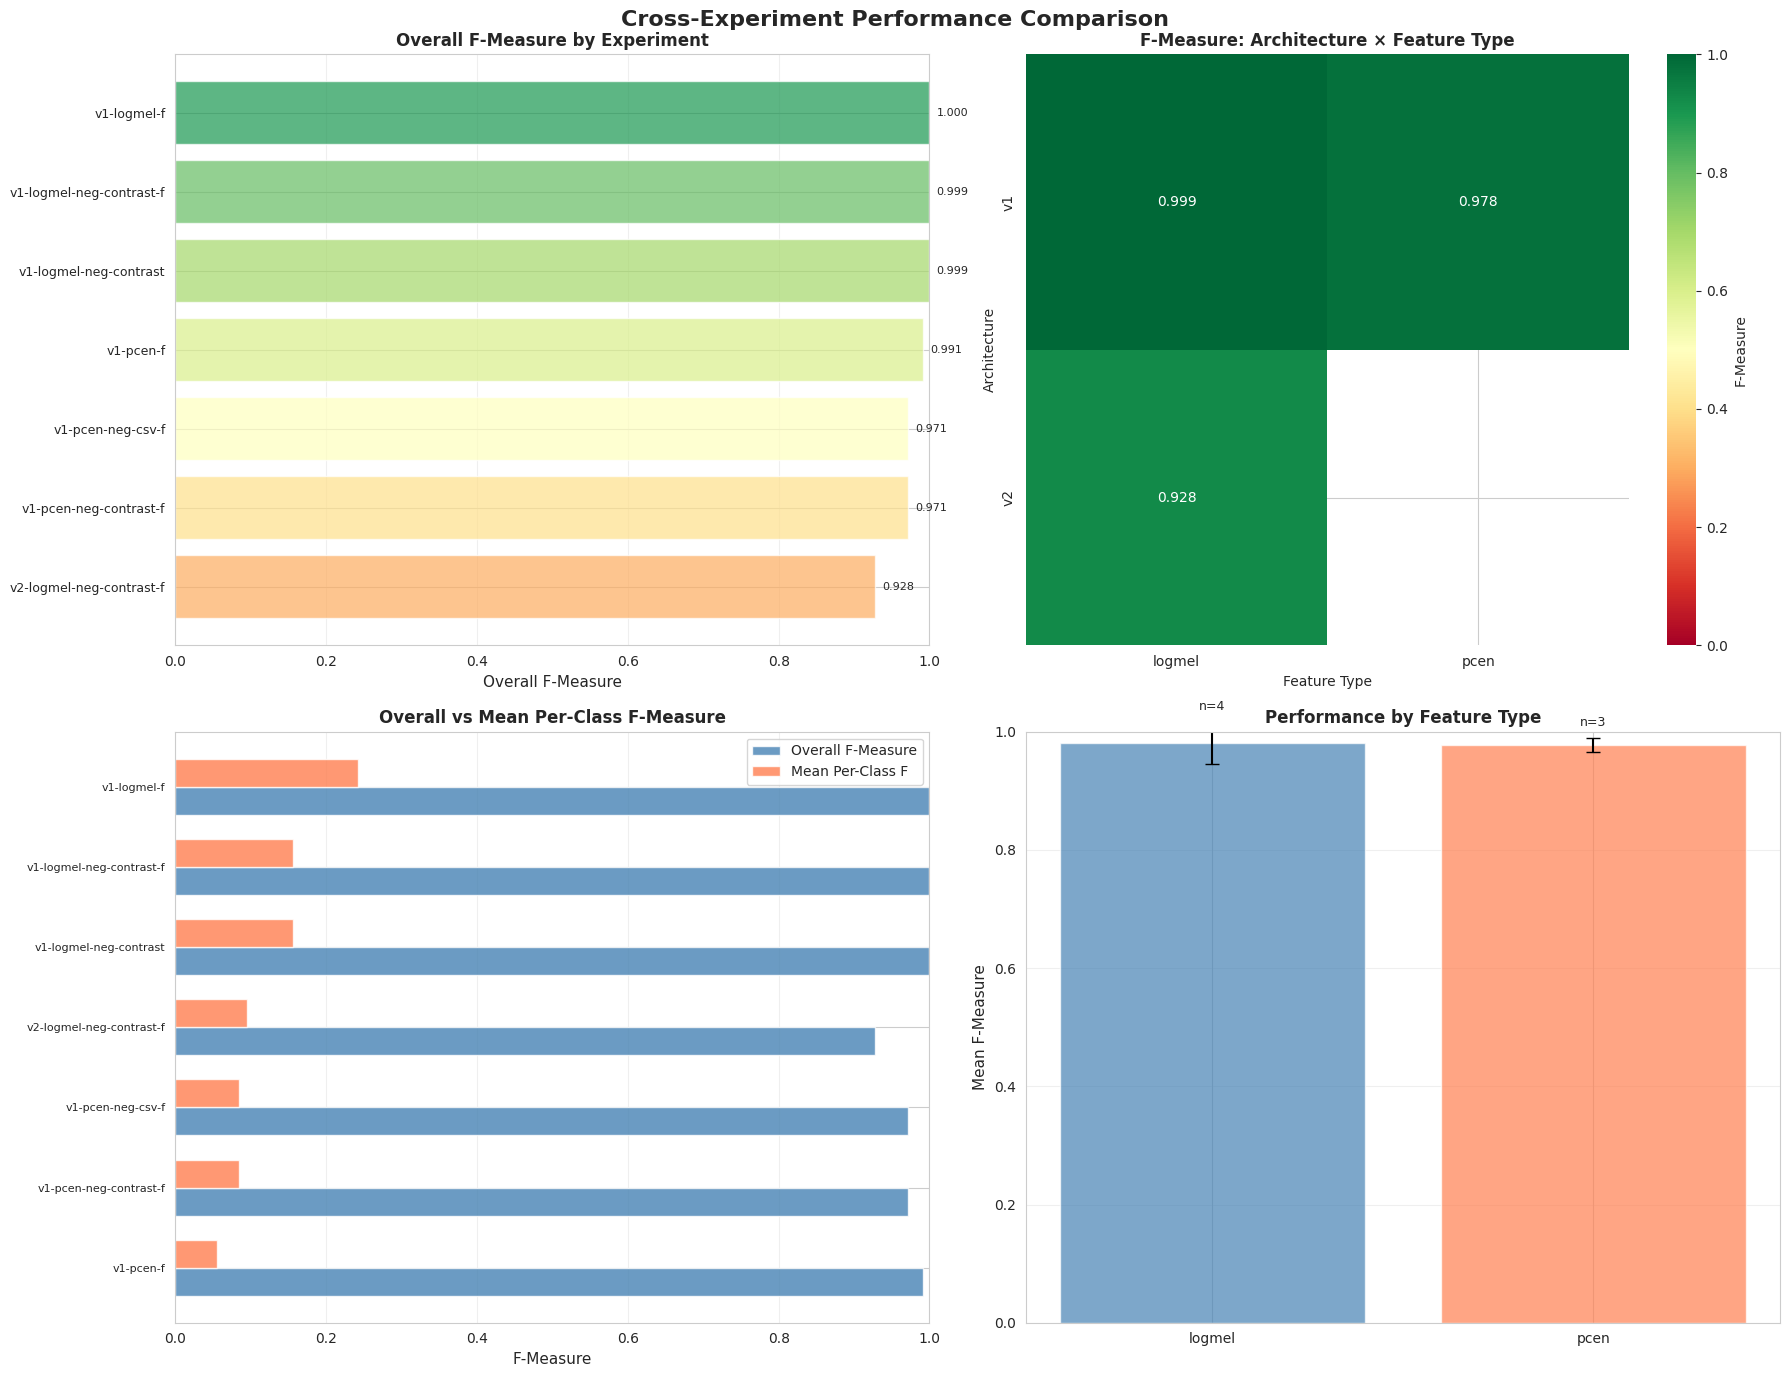


Cross-Experiment Comparison Summary:

Best Overall F-Measure:
  v1-logmel-f: 1.000

Worst Overall F-Measure:
  v2-logmel-neg-contrast-f: 0.928

Best Mean Per-Class F-Measure:
  v1-logmel-f: 0.242

Feature Type Performance:
  logmel: 0.982 ± 0.036 (n=4)
  pcen: 0.978 ± 0.012 (n=3)


In [63]:
def plot_cross_experiment_comparison(all_results: Dict, summary_df: pd.DataFrame):
    """
    Create visualizations comparing all experiments.
    """
    if not all_results or summary_df.empty:
        print("No data available for cross-experiment comparison")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Cross-Experiment Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Overall F-Measure comparison
    ax1 = axes[0, 0]
    valid_data = summary_df[summary_df['Overall F-Measure'].notna()].sort_values('Overall F-Measure', ascending=True)
    if not valid_data.empty:
        colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(valid_data)))
        bars = ax1.barh(range(len(valid_data)), valid_data['Overall F-Measure'], color=colors, alpha=0.7)
        ax1.set_yticks(range(len(valid_data)))
        ax1.set_yticklabels(valid_data['Experiment'], fontsize=9)
        ax1.set_xlabel('Overall F-Measure', fontsize=11)
        ax1.set_title('Overall F-Measure by Experiment', fontsize=12, fontweight='bold')
        ax1.set_xlim(0, 1.0)
        ax1.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (idx, row) in enumerate(valid_data.iterrows()):
            ax1.text(row['Overall F-Measure'] + 0.01, i, f"{row['Overall F-Measure']:.3f}", 
                    va='center', fontsize=8)
    
    # 2. Architecture vs Feature Type heatmap
    ax2 = axes[0, 1]
    pivot_data = summary_df.pivot_table(
        values='Overall F-Measure', 
        index='Architecture', 
        columns='Feature Type', 
        aggfunc='mean'
    )
    if not pivot_data.empty:
        sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax2, 
                   cbar_kws={'label': 'F-Measure'}, vmin=0, vmax=1)
        ax2.set_title('F-Measure: Architecture × Feature Type', fontsize=12, fontweight='bold')
    
    # 3. Mean Per-Class F-Measure comparison
    ax3 = axes[1, 0]
    valid_class_data = summary_df[summary_df['Mean Per-Class F'].notna()].sort_values('Mean Per-Class F', ascending=True)
    if not valid_class_data.empty:
        x = np.arange(len(valid_class_data))
        width = 0.35
        
        bars1 = ax3.barh(x - width/2, valid_class_data['Overall F-Measure'], width, 
                         label='Overall F-Measure', alpha=0.8, color='steelblue')
        bars2 = ax3.barh(x + width/2, valid_class_data['Mean Per-Class F'], width, 
                         label='Mean Per-Class F', alpha=0.8, color='coral')
        
        ax3.set_yticks(x)
        ax3.set_yticklabels(valid_class_data['Experiment'], fontsize=8)
        ax3.set_xlabel('F-Measure', fontsize=11)
        ax3.set_title('Overall vs Mean Per-Class F-Measure', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.set_xlim(0, 1.0)
        ax3.grid(axis='x', alpha=0.3)
    
    # 4. Feature Type comparison
    ax4 = axes[1, 1]
    if 'Feature Type' in summary_df.columns and 'Overall F-Measure' in summary_df.columns:
        feature_comparison = summary_df.groupby('Feature Type')['Overall F-Measure'].agg(['mean', 'std', 'count'])
        feature_comparison = feature_comparison[feature_comparison['count'] > 0]
        
        if not feature_comparison.empty:
            x_pos = np.arange(len(feature_comparison))
            bars = ax4.bar(x_pos, feature_comparison['mean'], yerr=feature_comparison['std'], 
                          alpha=0.7, color=['steelblue', 'coral', 'mediumseagreen'][:len(feature_comparison)],
                          capsize=5)
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels(feature_comparison.index, fontsize=10)
            ax4.set_ylabel('Mean F-Measure', fontsize=11)
            ax4.set_title('Performance by Feature Type', fontsize=12, fontweight='bold')
            ax4.set_ylim(0, 1.0)
            ax4.grid(axis='y', alpha=0.3)
            
            # Add count labels
            for i, (feat, row) in enumerate(feature_comparison.iterrows()):
                ax4.text(i, row['mean'] + row['std'] + 0.02, f"n={int(row['count'])}", 
                        ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nCross-Experiment Comparison Summary:")
    print("="*80)
    if not valid_data.empty:
        print(f"\nBest Overall F-Measure:")
        best = valid_data.iloc[-1]
        print(f"  {best['Experiment']}: {best['Overall F-Measure']:.3f}")
        
        print(f"\nWorst Overall F-Measure:")
        worst = valid_data.iloc[0]
        print(f"  {worst['Experiment']}: {worst['Overall F-Measure']:.3f}")
    
    if not valid_class_data.empty:
        print(f"\nBest Mean Per-Class F-Measure:")
        best_class = valid_class_data.iloc[-1]
        print(f"  {best_class['Experiment']}: {best_class['Mean Per-Class F']:.3f}")
    
    if not feature_comparison.empty:
        print(f"\nFeature Type Performance:")
        for feat, row in feature_comparison.iterrows():
            print(f"  {feat}: {row['mean']:.3f} ± {row['std']:.3f} (n={int(row['count'])})")


# Create cross-experiment comparison
if not summary_df.empty and len(all_experiment_results) > 1:
    plot_cross_experiment_comparison(all_experiment_results, summary_df)
else:
    print("Need at least 2 experiments for comparison.")


In [64]:
# Load main evaluation results if available
main_eval_per_class = {}

if MAIN_EVAL_DIR and Path(MAIN_EVAL_DIR).exists():
    main_eval_dir = Path(MAIN_EVAL_DIR)
    
    # Find evaluation report JSON files
    main_reports = list(main_eval_dir.glob("Evaluation_report_*.json"))
    
    if main_reports:
        print(f"Found {len(main_reports)} main evaluation report(s)")
        
        # Use the most recent report
        latest_report_path = max(main_reports, key=lambda p: p.stat().st_mtime)
        print(f"Using latest report: {latest_report_path.name}")
        
        main_report = load_evaluation_report(latest_report_path)
        main_eval_per_class = extract_per_class_metrics(main_report)
        
        print(f"\nMain evaluation - Overall scores:")
        overall = main_report.get("overall_scores", {})
        for key, value in overall.items():
            print(f"  {key}: {value}")
        
        print(f"\nExtracted metrics for {len(main_eval_per_class)} classes")
    else:
        print(f"No evaluation reports found in {main_eval_dir}")
else:
    print("Main evaluation directory not specified or not found. Skipping main evaluation analysis.")


Main evaluation directory not specified or not found. Skipping main evaluation analysis.


## 3. Calculate Event Length Statistics


In [65]:
# Calculate event lengths from training annotations
if TRAIN_DATA_DIR.exists():
    class_durations = calculate_event_lengths_from_annotations(TRAIN_DATA_DIR)
    event_length_stats = calculate_event_length_stats(class_durations)
    
    print(f"\nEvent length statistics for {len(event_length_stats)} classes:")
    print(event_length_stats.to_string(index=False))
else:
    print(f"Training data directory not found: {TRAIN_DATA_DIR}")
    event_length_stats = pd.DataFrame()


Processing 174 annotation files...



Event length statistics for 46 classes:
class  mean_length  median_length   std_length  min_length  max_length  count
 AGGM     0.464113       0.447000 2.455734e-01    0.050000    1.315000     53
 AMRE     0.200000       0.200000 5.345154e-13    0.200000    0.200000     42
 BBWA     0.200000       0.200000 4.823414e-13    0.200000    0.200000     29
 BTBW     0.200000       0.200000 5.389101e-13    0.200000    0.200000     97
 CCMK     0.186710       0.189000 2.833441e-02    0.099000    0.273000   1046
 CHSP     0.200000       0.200000 4.544354e-13    0.200000    0.200000     39
 COYE     0.200000       0.200000 4.784100e-13    0.200000    0.200000    126
 GCTH     0.200000       0.200000 5.713420e-13    0.200000    0.200000     75
  GIG     1.119839       0.875000 8.944587e-01    0.230000    5.810000    124
  GRN     1.666420       1.515000 7.816912e-01    0.530000    7.460000    176
   JD     0.154436       0.148662 2.848158e-02    0.102063    0.256000    355
 OVEN     0.200000     

## 4. Visualize Per-Class Performance Metrics


In [66]:
def plot_per_class_performance(per_class_metrics: Dict[str, Dict[str, float]], title: str = "Per-Class Performance"):
    """
    Create comprehensive visualizations of per-class performance.
    """
    if not per_class_metrics:
        print(f"No metrics available for {title}")
        return None
    
    # Convert to DataFrame
    classes = list(per_class_metrics.keys())
    precision = [per_class_metrics[cls].get("precision", 0) for cls in classes]
    recall = [per_class_metrics[cls].get("recall", 0) for cls in classes]
    fmeasure = [per_class_metrics[cls].get("f-measure", 0) for cls in classes]
    
    df = pd.DataFrame({
        "Class": classes,
        "Precision": precision,
        "Recall": recall,
        "F-Measure": fmeasure
    })
    
    # Sort by f-measure for better visualization
    df = df.sort_values("F-Measure")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 1. Bar chart - F-Measure per class
    ax1 = axes[0, 0]
    colors = ['green' if x >= 0.7 else 'orange' if x >= 0.5 else 'red' for x in df['F-Measure']]
    bars = ax1.barh(range(len(df)), df['F-Measure'], color=colors, alpha=0.7)
    ax1.set_yticks(range(len(df)))
    ax1.set_yticklabels(df['Class'], fontsize=9)
    ax1.set_xlabel('F-Measure', fontsize=11)
    ax1.set_title('F-Measure by Class (Sorted)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 1.0)
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(df.iterrows()):
        ax1.text(row['F-Measure'] + 0.01, i, f"{row['F-Measure']:.3f}", 
                va='center', fontsize=8)
    
    # 2. Precision vs Recall scatter
    ax2 = axes[0, 1]
    scatter = ax2.scatter(df['Precision'], df['Recall'], s=100, 
                         c=df['F-Measure'], cmap='RdYlGn', alpha=0.6, edgecolors='black')
    ax2.set_xlabel('Precision', fontsize=11)
    ax2.set_ylabel('Recall', fontsize=11)
    ax2.set_title('Precision vs Recall (Color = F-Measure)', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, 1.0)
    ax2.set_ylim(0, 1.0)
    ax2.grid(alpha=0.3)
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # Diagonal line
    plt.colorbar(scatter, ax=ax2, label='F-Measure')
    
    # Add class labels to scatter points
    for idx, row in df.iterrows():
        ax2.annotate(row['Class'], (row['Precision'], row['Recall']), 
                    fontsize=7, alpha=0.7)
    
    # 3. All metrics comparison
    ax3 = axes[1, 0]
    x = np.arange(len(df))
    width = 0.25
    ax3.bar(x - width, df['Precision'], width, label='Precision', alpha=0.8)
    ax3.bar(x, df['Recall'], width, label='Recall', alpha=0.8)
    ax3.bar(x + width, df['F-Measure'], width, label='F-Measure', alpha=0.8)
    ax3.set_xlabel('Class', fontsize=11)
    ax3.set_ylabel('Score', fontsize=11)
    ax3.set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(df['Class'], rotation=45, ha='right', fontsize=8)
    ax3.legend()
    ax3.set_ylim(0, 1.0)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Performance categories
    ax4 = axes[1, 1]
    excellent = len(df[df['F-Measure'] >= 0.7])
    good = len(df[(df['F-Measure'] >= 0.5) & (df['F-Measure'] < 0.7)])
    poor = len(df[df['F-Measure'] < 0.5])
    
    categories = ['Excellent\n(≥0.7)', 'Good\n(0.5-0.7)', 'Poor\n(<0.5)']
    counts = [excellent, good, poor]
    colors_pie = ['green', 'orange', 'red']
    
    ax4.pie(counts, labels=categories, autopct='%1.1f%%', colors=colors_pie, 
           startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
    ax4.set_title('Performance Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{title} - Summary Statistics:")
    print(f"  Total classes: {len(df)}")
    print(f"  Mean F-Measure: {df['F-Measure'].mean():.3f}")
    print(f"  Median F-Measure: {df['F-Measure'].median():.3f}")
    print(f"  Std F-Measure: {df['F-Measure'].std():.3f}")
    print(f"\n  Best performing classes (Top 5):")
    top5 = df.nlargest(5, 'F-Measure')[['Class', 'F-Measure', 'Precision', 'Recall']]
    for _, row in top5.iterrows():
        print(f"    {row['Class']}: F={row['F-Measure']:.3f}, P={row['Precision']:.3f}, R={row['Recall']:.3f}")
    print(f"\n  Worst performing classes (Bottom 5):")
    bottom5 = df.nsmallest(5, 'F-Measure')[['Class', 'F-Measure', 'Precision', 'Recall']]
    for _, row in bottom5.iterrows():
        print(f"    {row['Class']}: F={row['F-Measure']:.3f}, P={row['Precision']:.3f}, R={row['Recall']:.3f}")
    
    return df


Found per-class metrics for 7 experiments

Visualizing per-class performance for each experiment:


Experiment: v1-logmel-f


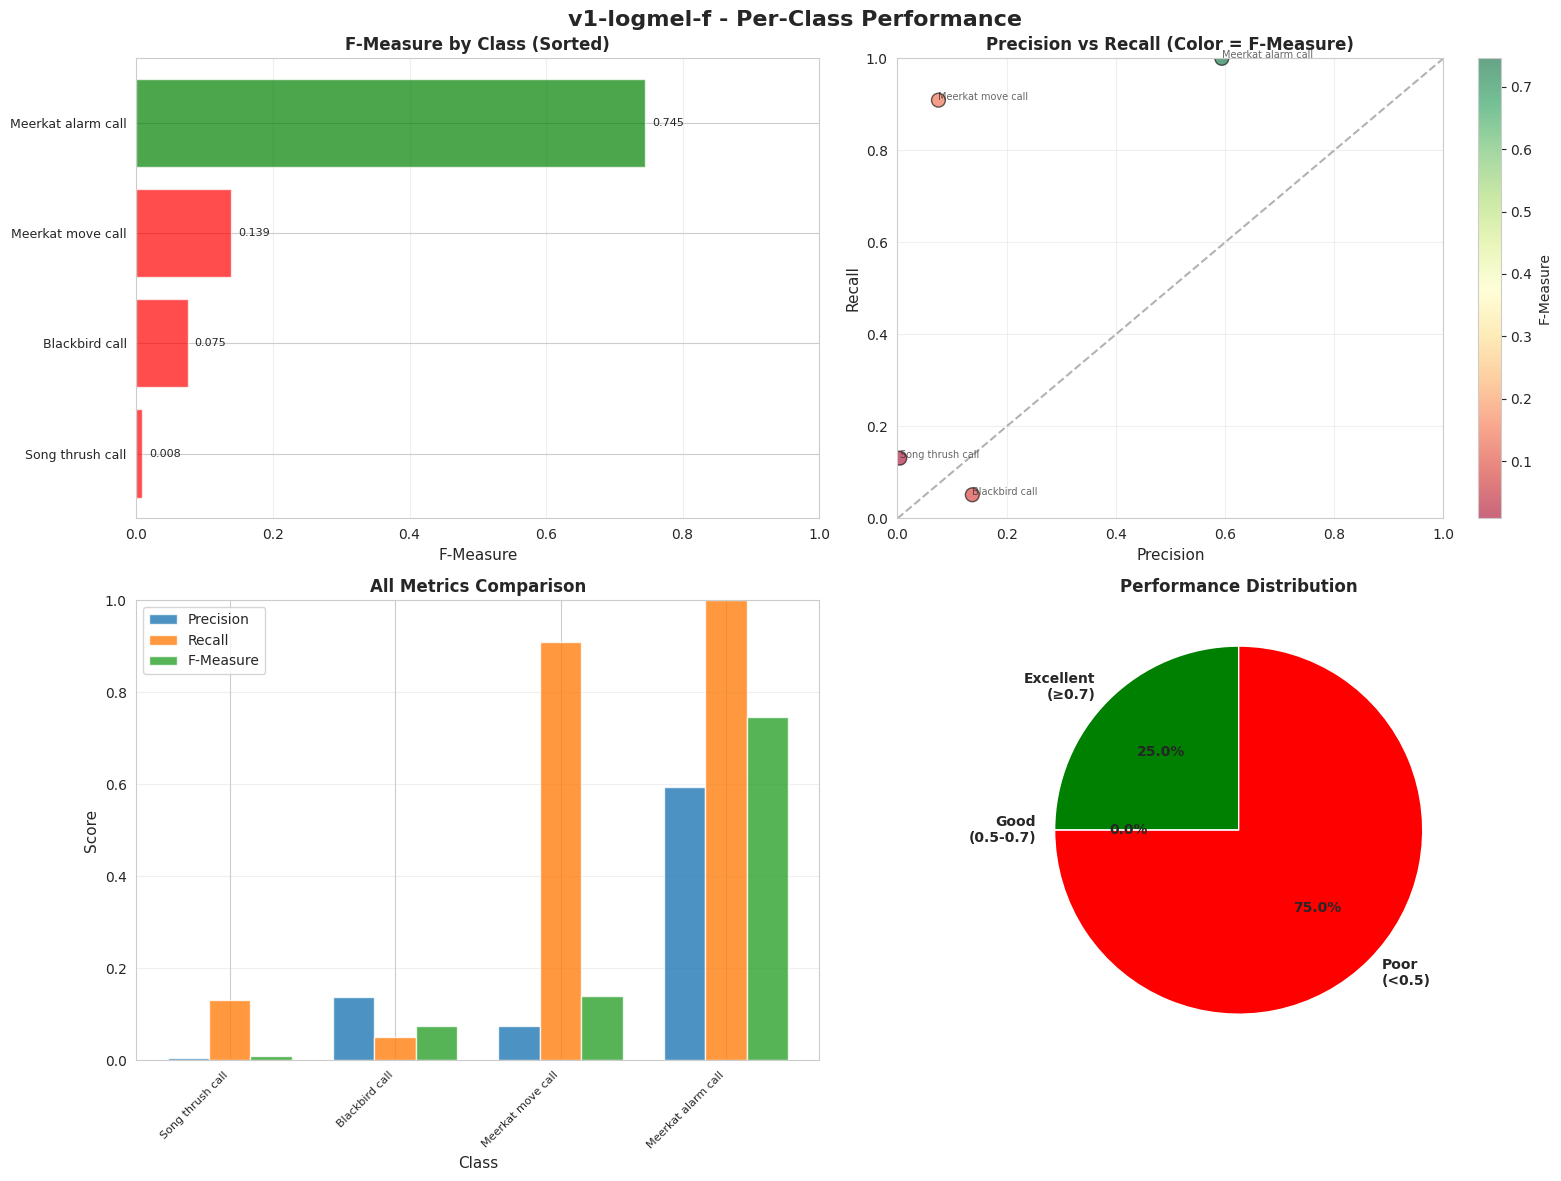


v1-logmel-f - Per-Class Performance - Summary Statistics:
  Total classes: 4
  Mean F-Measure: 0.242
  Median F-Measure: 0.107
  Std F-Measure: 0.340

  Best performing classes (Top 5):
    Meerkat alarm call: F=0.745, P=0.594, R=1.000
    Meerkat move call: F=0.139, P=0.075, R=0.909
    Blackbird call: F=0.075, P=0.137, R=0.051
    Song thrush call: F=0.008, P=0.004, R=0.131

  Worst performing classes (Bottom 5):
    Song thrush call: F=0.008, P=0.004, R=0.131
    Blackbird call: F=0.075, P=0.137, R=0.051
    Meerkat move call: F=0.139, P=0.075, R=0.909
    Meerkat alarm call: F=0.745, P=0.594, R=1.000

Experiment: v1-logmel-neg-contrast


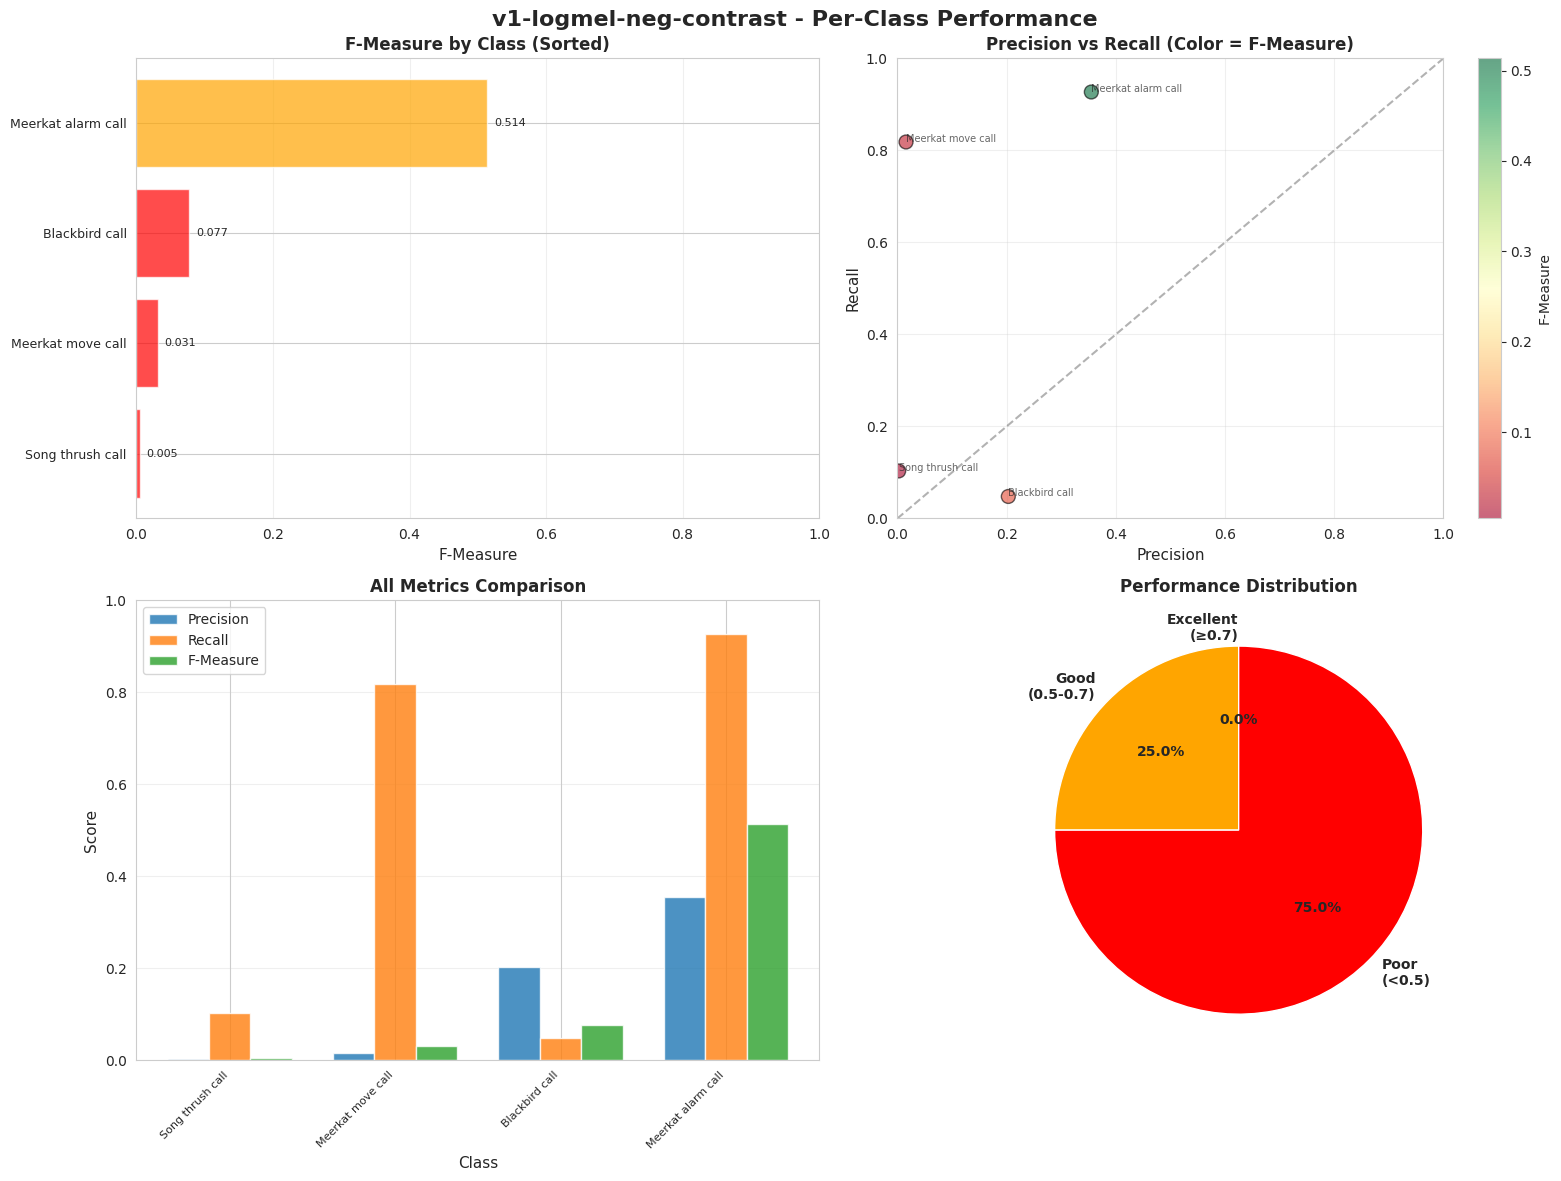


v1-logmel-neg-contrast - Per-Class Performance - Summary Statistics:
  Total classes: 4
  Mean F-Measure: 0.157
  Median F-Measure: 0.054
  Std F-Measure: 0.240

  Best performing classes (Top 5):
    Meerkat alarm call: F=0.514, P=0.355, R=0.927
    Blackbird call: F=0.077, P=0.203, R=0.048
    Meerkat move call: F=0.031, P=0.016, R=0.818
    Song thrush call: F=0.005, P=0.002, R=0.103

  Worst performing classes (Bottom 5):
    Song thrush call: F=0.005, P=0.002, R=0.103
    Meerkat move call: F=0.031, P=0.016, R=0.818
    Blackbird call: F=0.077, P=0.203, R=0.048
    Meerkat alarm call: F=0.514, P=0.355, R=0.927

Experiment: v1-logmel-neg-contrast-f


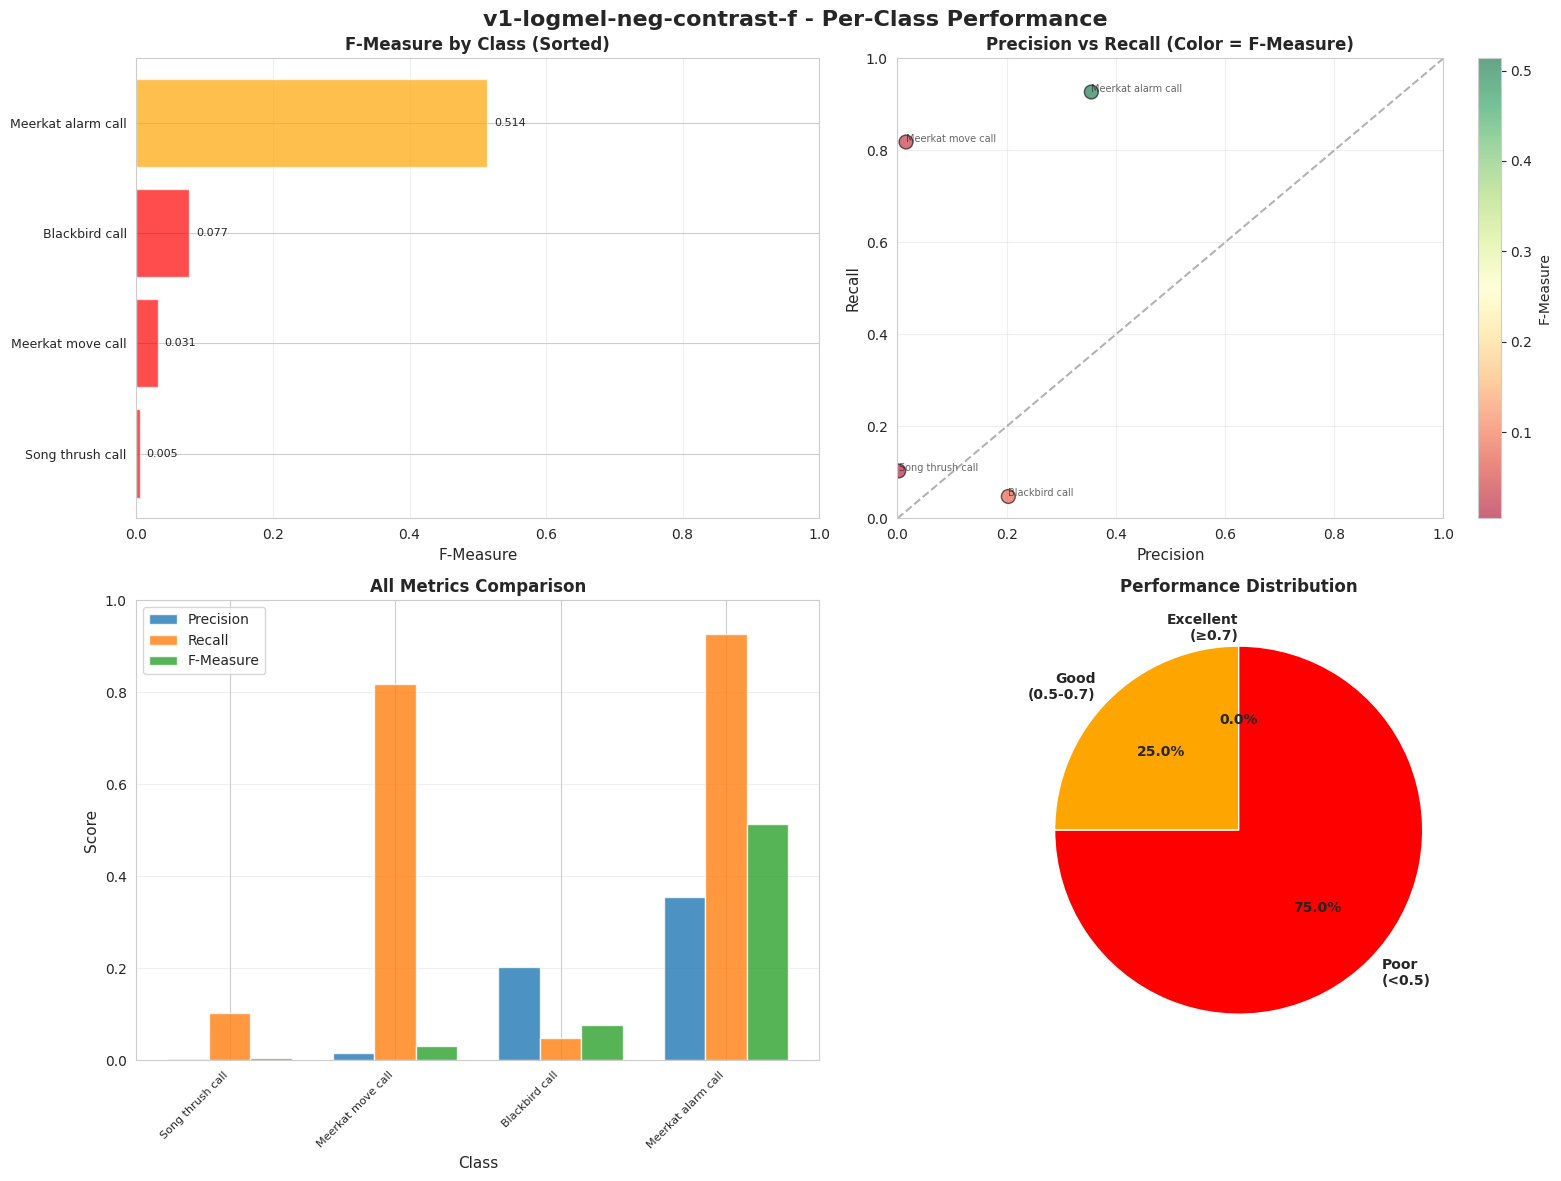


v1-logmel-neg-contrast-f - Per-Class Performance - Summary Statistics:
  Total classes: 4
  Mean F-Measure: 0.157
  Median F-Measure: 0.054
  Std F-Measure: 0.240

  Best performing classes (Top 5):
    Meerkat alarm call: F=0.514, P=0.355, R=0.927
    Blackbird call: F=0.077, P=0.203, R=0.048
    Meerkat move call: F=0.031, P=0.016, R=0.818
    Song thrush call: F=0.005, P=0.002, R=0.103

  Worst performing classes (Bottom 5):
    Song thrush call: F=0.005, P=0.002, R=0.103
    Meerkat move call: F=0.031, P=0.016, R=0.818
    Blackbird call: F=0.077, P=0.203, R=0.048
    Meerkat alarm call: F=0.514, P=0.355, R=0.927

Experiment: v1-pcen-f


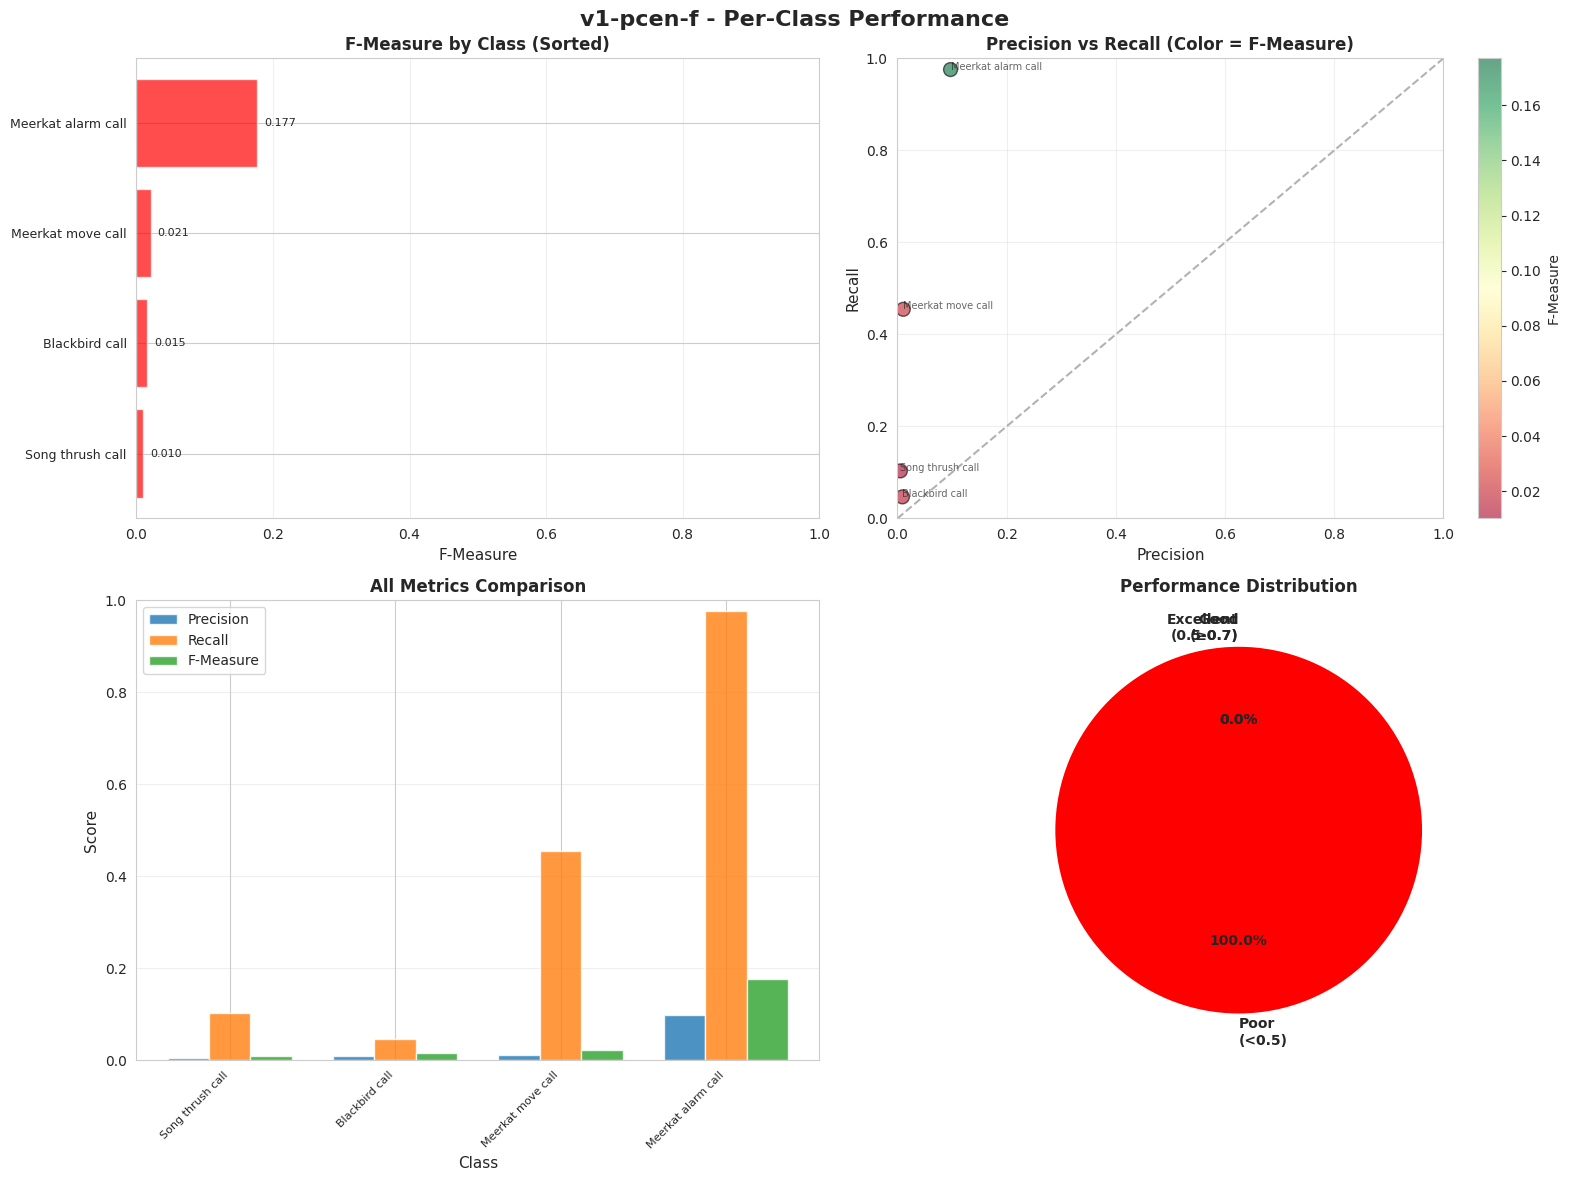


v1-pcen-f - Per-Class Performance - Summary Statistics:
  Total classes: 4
  Mean F-Measure: 0.056
  Median F-Measure: 0.018
  Std F-Measure: 0.081

  Best performing classes (Top 5):
    Meerkat alarm call: F=0.177, P=0.097, R=0.976
    Meerkat move call: F=0.021, P=0.011, R=0.455
    Blackbird call: F=0.015, P=0.009, R=0.047
    Song thrush call: F=0.010, P=0.005, R=0.103

  Worst performing classes (Bottom 5):
    Song thrush call: F=0.010, P=0.005, R=0.103
    Blackbird call: F=0.015, P=0.009, R=0.047
    Meerkat move call: F=0.021, P=0.011, R=0.455
    Meerkat alarm call: F=0.177, P=0.097, R=0.976

Experiment: v1-pcen-neg-contrast-f


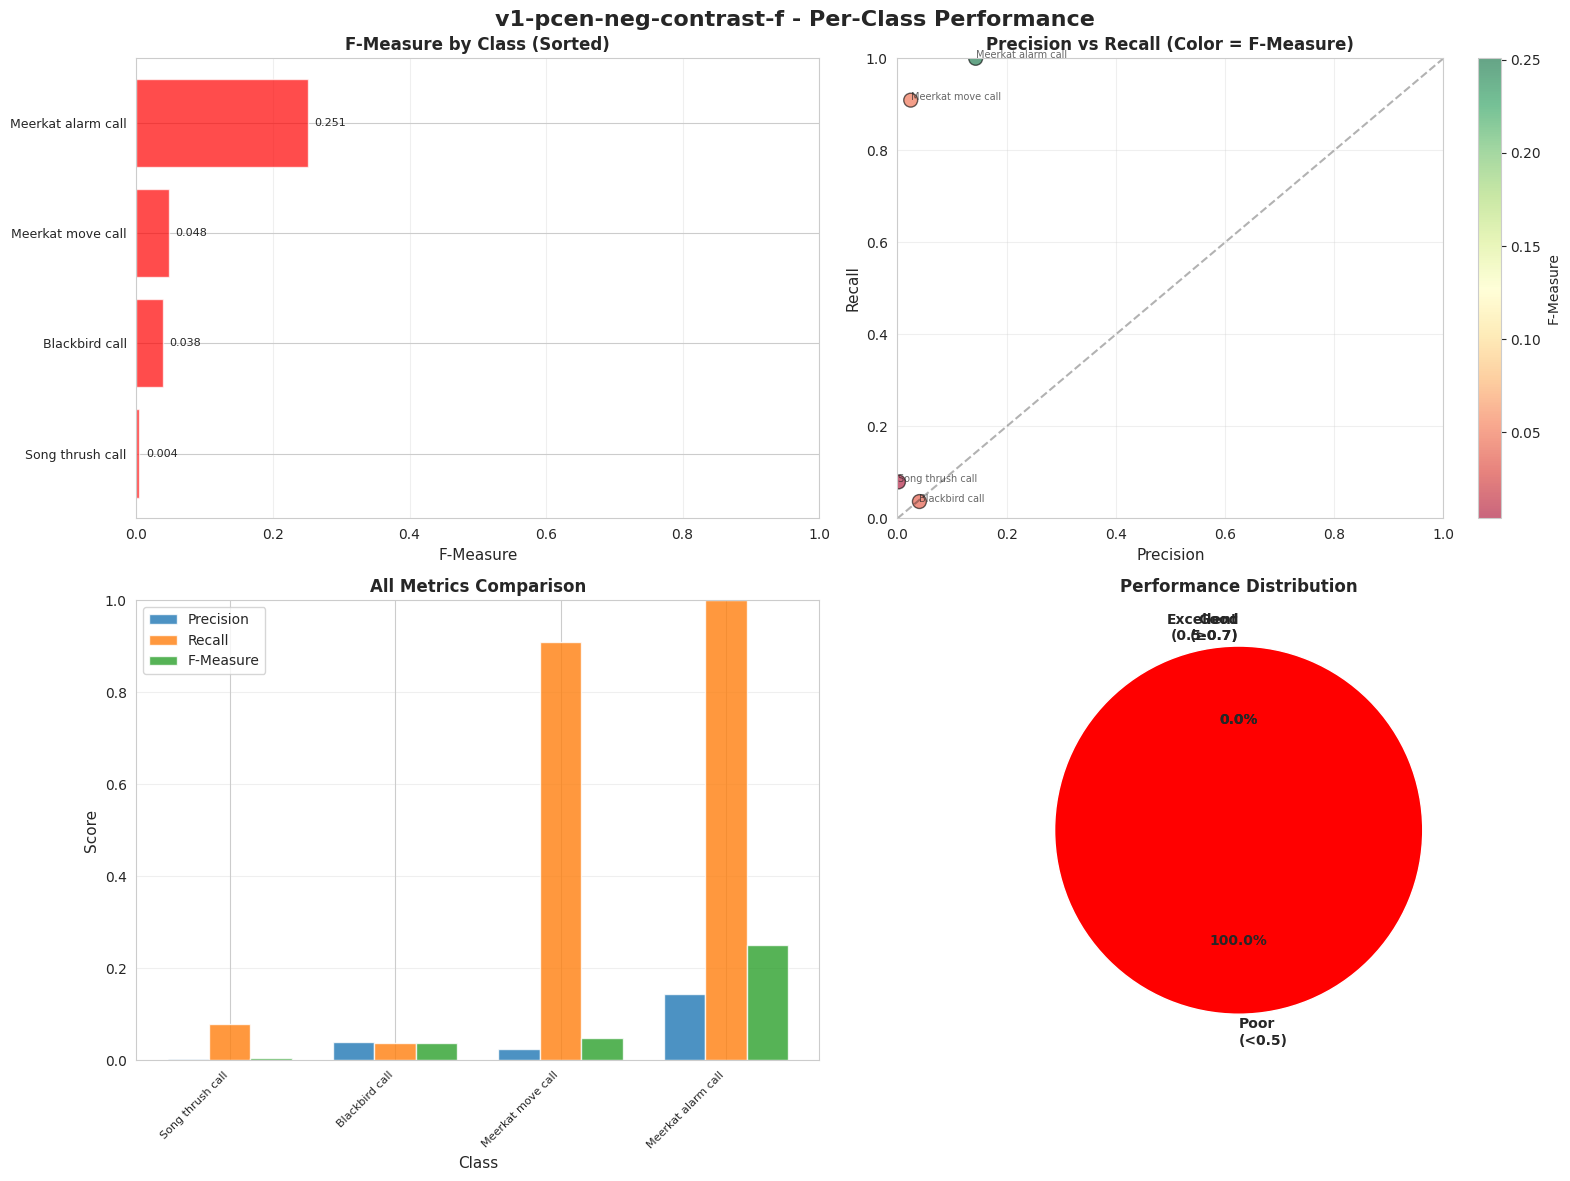


v1-pcen-neg-contrast-f - Per-Class Performance - Summary Statistics:
  Total classes: 4
  Mean F-Measure: 0.085
  Median F-Measure: 0.043
  Std F-Measure: 0.112

  Best performing classes (Top 5):
    Meerkat alarm call: F=0.251, P=0.143, R=1.000
    Meerkat move call: F=0.048, P=0.024, R=0.909
    Blackbird call: F=0.038, P=0.040, R=0.037
    Song thrush call: F=0.004, P=0.002, R=0.079

  Worst performing classes (Bottom 5):
    Song thrush call: F=0.004, P=0.002, R=0.079
    Blackbird call: F=0.038, P=0.040, R=0.037
    Meerkat move call: F=0.048, P=0.024, R=0.909
    Meerkat alarm call: F=0.251, P=0.143, R=1.000

Experiment: v1-pcen-neg-csv-f


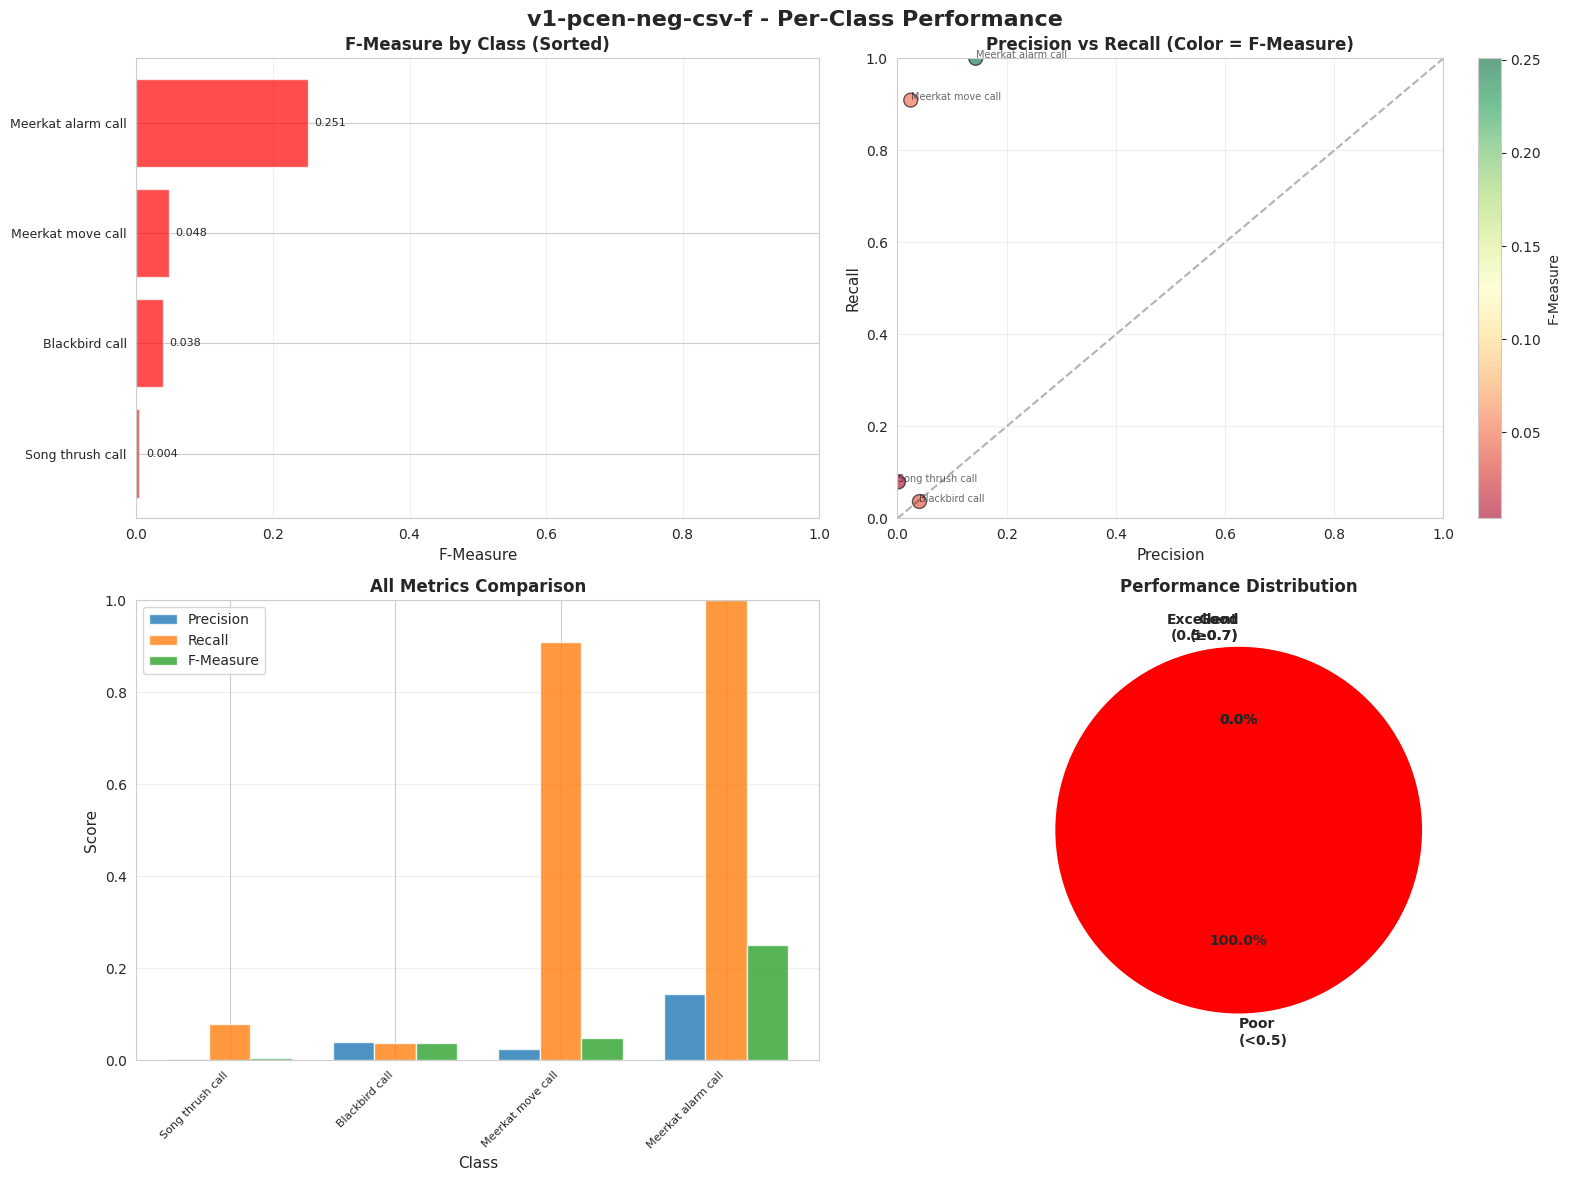


v1-pcen-neg-csv-f - Per-Class Performance - Summary Statistics:
  Total classes: 4
  Mean F-Measure: 0.085
  Median F-Measure: 0.043
  Std F-Measure: 0.112

  Best performing classes (Top 5):
    Meerkat alarm call: F=0.251, P=0.143, R=1.000
    Meerkat move call: F=0.048, P=0.024, R=0.909
    Blackbird call: F=0.038, P=0.040, R=0.037
    Song thrush call: F=0.004, P=0.002, R=0.079

  Worst performing classes (Bottom 5):
    Song thrush call: F=0.004, P=0.002, R=0.079
    Blackbird call: F=0.038, P=0.040, R=0.037
    Meerkat move call: F=0.048, P=0.024, R=0.909
    Meerkat alarm call: F=0.251, P=0.143, R=1.000

Experiment: v2-logmel-neg-contrast-f


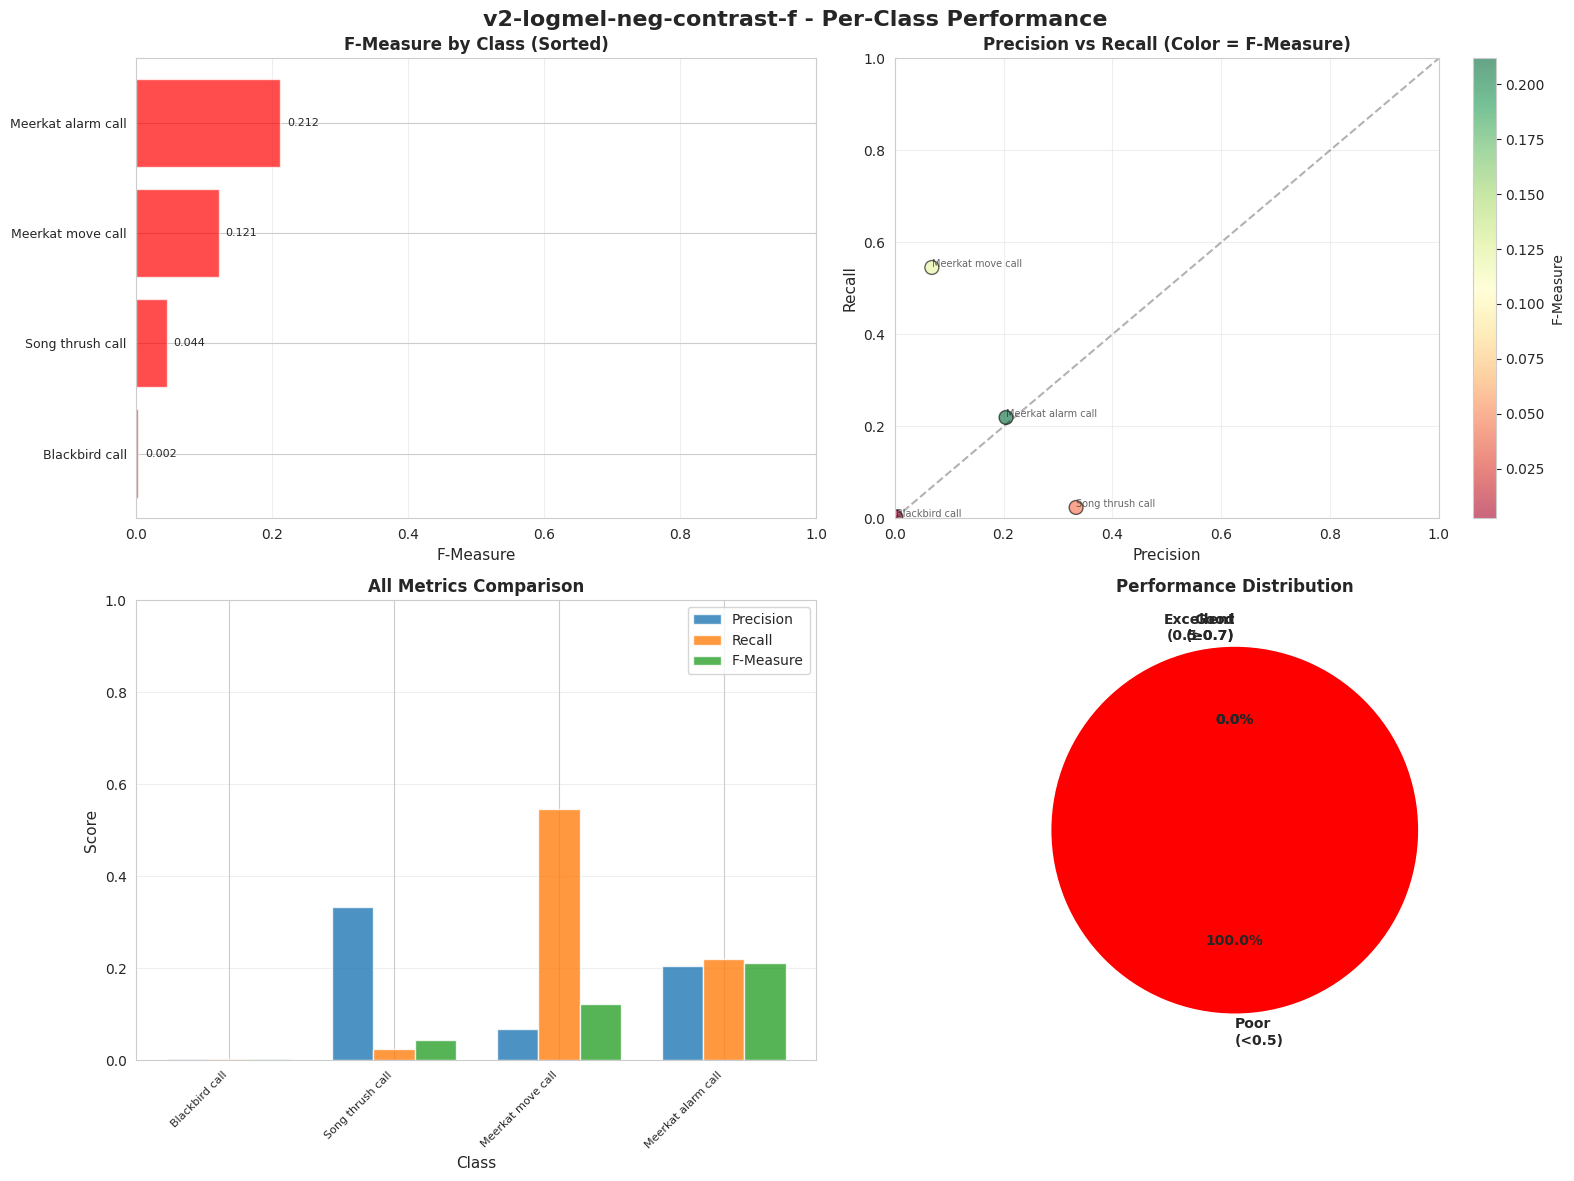


v2-logmel-neg-contrast-f - Per-Class Performance - Summary Statistics:
  Total classes: 4
  Mean F-Measure: 0.095
  Median F-Measure: 0.083
  Std F-Measure: 0.092

  Best performing classes (Top 5):
    Meerkat alarm call: F=0.212, P=0.205, R=0.220
    Meerkat move call: F=0.121, P=0.068, R=0.545
    Song thrush call: F=0.044, P=0.333, R=0.024
    Blackbird call: F=0.002, P=0.002, R=0.003

  Worst performing classes (Bottom 5):
    Blackbird call: F=0.002, P=0.002, R=0.003
    Song thrush call: F=0.044, P=0.333, R=0.024
    Meerkat move call: F=0.121, P=0.068, R=0.545
    Meerkat alarm call: F=0.212, P=0.205, R=0.220


In [67]:
# Visualize per-class performance for all experiments
# Collect all per-class metrics from experiments
all_per_class_data = {}
for exp_name, result in all_experiment_results.items():
    per_class = result.get('per_class_metrics', {})
    if per_class:
        all_per_class_data[exp_name] = per_class

if all_per_class_data:
    print(f"Found per-class metrics for {len(all_per_class_data)} experiments")
    print("\nVisualizing per-class performance for each experiment:\n")
    
    for exp_name, per_class_metrics in all_per_class_data.items():
        print(f"\n{'='*80}")
        print(f"Experiment: {exp_name}")
        print(f"{'='*80}")
        plot_per_class_performance(per_class_metrics, f"{exp_name} - Per-Class Performance")
else:
    print("No per-class metrics available for any experiment.")
    print("💡 Run the batch processing cell (Cell 53) to generate per-class metrics from checkpoints.")


In [68]:
# This cell is for main evaluation (from CLI evaluate command)
# If you have a main evaluation directory, you can load it here
main_eval_per_class = {}

if MAIN_EVAL_DIR and Path(MAIN_EVAL_DIR).exists():
    main_eval_dir = Path(MAIN_EVAL_DIR)
    main_reports = list(main_eval_dir.glob("Evaluation_report_*.json"))
    
    if main_reports:
        latest_report_path = max(main_reports, key=lambda p: p.stat().st_mtime)
        main_report = load_evaluation_report(latest_report_path)
        main_eval_per_class = extract_per_class_metrics(main_report)
        
        if main_eval_per_class:
            plot_per_class_performance(main_eval_per_class, "Main Evaluation - Per-Class Performance")
        else:
            print("No per-class metrics in main evaluation report.")
    else:
        print(f"No evaluation reports found in {main_eval_dir}")
else:
    print("Main evaluation directory not specified. Set MAIN_EVAL_DIR in configuration cell.")


Main evaluation directory not specified. Set MAIN_EVAL_DIR in configuration cell.


## 5. Visualize Event Length Statistics


In [69]:
def plot_event_length_statistics(event_length_stats: pd.DataFrame):
    """
    Visualize mean and median event lengths per class.
    """
    if event_length_stats.empty:
        print("No event length statistics available.")
        return None
    
    # Sort by mean length
    df = event_length_stats.sort_values("mean_length")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Event Length Statistics by Class', fontsize=16, fontweight='bold')
    
    # 1. Mean event length bar chart
    ax1 = axes[0, 0]
    bars = ax1.barh(range(len(df)), df['mean_length'], alpha=0.7, color='steelblue')
    ax1.set_yticks(range(len(df)))
    ax1.set_yticklabels(df['class'], fontsize=9)
    ax1.set_xlabel('Mean Event Length (seconds)', fontsize=11)
    ax1.set_title('Mean Event Length by Class', fontsize=12, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(df.iterrows()):
        ax1.text(row['mean_length'] + max(df['mean_length']) * 0.01, i, 
                f"{row['mean_length']:.2f}s", va='center', fontsize=8)
    
    # 2. Median event length bar chart
    ax2 = axes[0, 1]
    bars = ax2.barh(range(len(df)), df['median_length'], alpha=0.7, color='coral')
    ax2.set_yticks(range(len(df)))
    ax2.set_yticklabels(df['class'], fontsize=9)
    ax2.set_xlabel('Median Event Length (seconds)', fontsize=11)
    ax2.set_title('Median Event Length by Class', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(df.iterrows()):
        ax2.text(row['median_length'] + max(df['median_length']) * 0.01, i, 
                f"{row['median_length']:.2f}s", va='center', fontsize=8)
    
    # 3. Mean vs Median comparison
    ax3 = axes[1, 0]
    x = np.arange(len(df))
    width = 0.35
    ax3.bar(x - width/2, df['mean_length'], width, label='Mean', alpha=0.8, color='steelblue')
    ax3.bar(x + width/2, df['median_length'], width, label='Median', alpha=0.8, color='coral')
    ax3.set_xlabel('Class', fontsize=11)
    ax3.set_ylabel('Event Length (seconds)', fontsize=11)
    ax3.set_title('Mean vs Median Event Length', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(df['class'], rotation=45, ha='right', fontsize=8)
    ax3.legend()
    ax3.set_ylim(0, max(df['mean_length'].max(), df['median_length'].max()) * 1.1)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Event count per class
    ax4 = axes[1, 1]
    bars = ax4.barh(range(len(df)), df['count'], alpha=0.7, color='mediumseagreen')
    ax4.set_yticks(range(len(df)))
    ax4.set_yticklabels(df['class'], fontsize=9)
    ax4.set_xlabel('Number of Events', fontsize=11)
    ax4.set_title('Event Count by Class', fontsize=12, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(df.iterrows()):
        ax4.text(row['count'] + max(df['count']) * 0.01, i, 
                f"{int(row['count'])}", va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nEvent Length Statistics Summary:")
    print(f"  Total classes: {len(df)}")
    print(f"  Overall mean event length: {df['mean_length'].mean():.3f} seconds")
    print(f"  Overall median event length: {df['median_length'].median():.3f} seconds")
    print(f"  Total events: {df['count'].sum():,}")
    print(f"\n  Classes with longest events (Top 5):")
    top5 = df.nlargest(5, 'mean_length')[['class', 'mean_length', 'median_length', 'count']]
    for _, row in top5.iterrows():
        print(f"    {row['class']}: mean={row['mean_length']:.3f}s, median={row['median_length']:.3f}s, count={int(row['count'])}")
    print(f"\n  Classes with shortest events (Bottom 5):")
    bottom5 = df.nsmallest(5, 'mean_length')[['class', 'mean_length', 'median_length', 'count']]
    for _, row in bottom5.iterrows():
        print(f"    {row['class']}: mean={row['mean_length']:.3f}s, median={row['median_length']:.3f}s, count={int(row['count'])}")
    
    return df


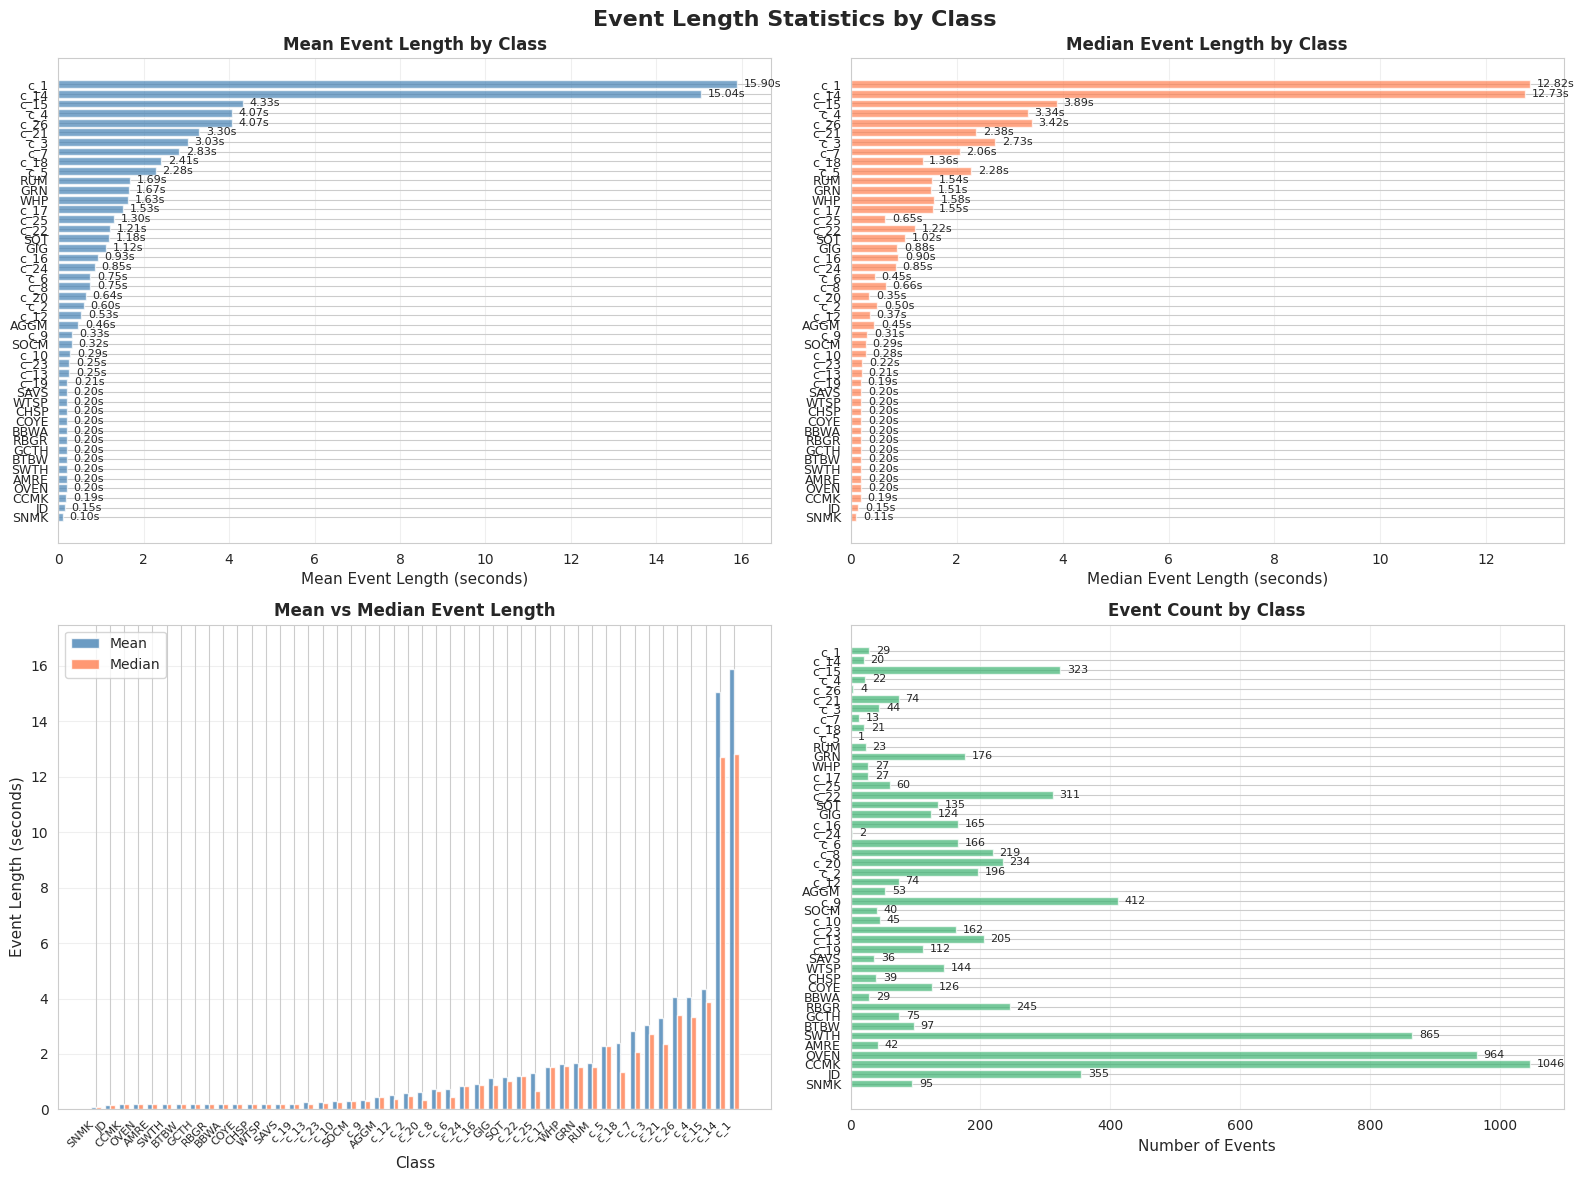


Event Length Statistics Summary:
  Total classes: 46
  Overall mean event length: 1.704 seconds
  Overall median event length: 0.449 seconds
  Total events: 7,677

  Classes with longest events (Top 5):
    c_1: mean=15.897s, median=12.818s, count=29
    c_14: mean=15.042s, median=12.726s, count=20
    c_15: mean=4.327s, median=3.886s, count=323
    c_4: mean=4.068s, median=3.341s, count=22
    c_26: mean=4.067s, median=3.417s, count=4

  Classes with shortest events (Bottom 5):
    SNMK: mean=0.104s, median=0.105s, count=95
    JD: mean=0.154s, median=0.149s, count=355
    CCMK: mean=0.187s, median=0.189s, count=1046
    OVEN: mean=0.200s, median=0.200s, count=964
    AMRE: mean=0.200s, median=0.200s, count=42


In [70]:
# Visualize event length statistics
if not event_length_stats.empty:
    event_length_df = plot_event_length_statistics(event_length_stats)
else:
    print("No event length statistics available.")


## 6. Correlation Analysis: Performance vs Event Length


In [71]:
def plot_performance_vs_event_length(per_class_metrics: Dict, event_length_stats: pd.DataFrame, title: str = "Performance vs Event Length"):
    """
    Analyze correlation between model performance and event length.
    """
    if not per_class_metrics or event_length_stats.empty:
        print(f"Insufficient data for {title}")
        return None
    
    # Merge metrics with event length stats
    metrics_df = pd.DataFrame([
        {
            "class": cls,
            "fmeasure": metrics.get("f-measure", 0),
            "precision": metrics.get("precision", 0),
            "recall": metrics.get("recall", 0)
        }
        for cls, metrics in per_class_metrics.items()
    ])
    
    merged = metrics_df.merge(event_length_stats, left_on='class', right_on='class', how='inner')
    
    if merged.empty:
        print(f"No matching classes found between metrics and event length data")
        return None
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 1. F-Measure vs Mean Event Length
    ax1 = axes[0, 0]
    scatter = ax1.scatter(merged['mean_length'], merged['fmeasure'], s=100, alpha=0.6, edgecolors='black')
    ax1.set_xlabel('Mean Event Length (seconds)', fontsize=11)
    ax1.set_ylabel('F-Measure', fontsize=11)
    ax1.set_title('F-Measure vs Mean Event Length', fontsize=12, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Add class labels
    for _, row in merged.iterrows():
        ax1.annotate(row['class'], (row['mean_length'], row['fmeasure']), 
                    fontsize=7, alpha=0.7)
    
    # Calculate correlation
    corr = merged['mean_length'].corr(merged['fmeasure'])
    ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax1.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. F-Measure vs Median Event Length
    ax2 = axes[0, 1]
    scatter = ax2.scatter(merged['median_length'], merged['fmeasure'], s=100, alpha=0.6, edgecolors='black')
    ax2.set_xlabel('Median Event Length (seconds)', fontsize=11)
    ax2.set_ylabel('F-Measure', fontsize=11)
    ax2.set_title('F-Measure vs Median Event Length', fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    for _, row in merged.iterrows():
        ax2.annotate(row['class'], (row['median_length'], row['fmeasure']), 
                    fontsize=7, alpha=0.7)
    
    corr_median = merged['median_length'].corr(merged['fmeasure'])
    ax2.text(0.05, 0.95, f'Correlation: {corr_median:.3f}', transform=ax2.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. F-Measure vs Event Count
    ax3 = axes[1, 0]
    scatter = ax3.scatter(merged['count'], merged['fmeasure'], s=100, alpha=0.6, edgecolors='black')
    ax3.set_xlabel('Event Count', fontsize=11)
    ax3.set_ylabel('F-Measure', fontsize=11)
    ax3.set_title('F-Measure vs Event Count', fontsize=12, fontweight='bold')
    ax3.grid(alpha=0.3)
    
    for _, row in merged.iterrows():
        ax3.annotate(row['class'], (row['count'], row['fmeasure']), 
                    fontsize=7, alpha=0.7)
    
    corr_count = merged['count'].corr(merged['fmeasure'])
    ax3.text(0.05, 0.95, f'Correlation: {corr_count:.3f}', transform=ax3.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 4. Combined view: Mean length vs F-Measure with size = count
    ax4 = axes[1, 1]
    sizes = merged['count'] / merged['count'].max() * 300  # Normalize for bubble size
    scatter = ax4.scatter(merged['mean_length'], merged['fmeasure'], s=sizes, 
                         alpha=0.6, edgecolors='black', c=merged['count'], cmap='viridis')
    ax4.set_xlabel('Mean Event Length (seconds)', fontsize=11)
    ax4.set_ylabel('F-Measure', fontsize=11)
    ax4.set_title('F-Measure vs Mean Length (Size = Event Count)', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Event Count')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{title} - Correlation Analysis:")
    print(f"  F-Measure vs Mean Event Length: {corr:.3f}")
    print(f"  F-Measure vs Median Event Length: {corr_median:.3f}")
    print(f"  F-Measure vs Event Count: {corr_count:.3f}")
    
    return merged


In [72]:
# Analyze correlation between performance and event length for all experiments
if not event_length_stats.empty:
    # Process each experiment that has per-class metrics
    for exp_name, result in all_experiment_results.items():
        per_class_metrics = result.get('per_class_metrics', {})
        if per_class_metrics:
            print(f"\n{'='*80}")
            print(f"Experiment: {exp_name}")
            print(f"{'='*80}")
            plot_performance_vs_event_length(
                per_class_metrics, event_length_stats,
                f"{exp_name}: Performance vs Event Length"
            )
else:
    print("Cannot analyze correlation: missing event length statistics.")
    print("💡 Run the event length calculation cell to compute statistics.")



Experiment: v1-logmel-f
No matching classes found between metrics and event length data

Experiment: v1-logmel-neg-contrast
No matching classes found between metrics and event length data

Experiment: v1-logmel-neg-contrast-f
No matching classes found between metrics and event length data

Experiment: v1-pcen-f
No matching classes found between metrics and event length data

Experiment: v1-pcen-neg-contrast-f
No matching classes found between metrics and event length data

Experiment: v1-pcen-neg-csv-f
No matching classes found between metrics and event length data

Experiment: v2-logmel-neg-contrast-f
No matching classes found between metrics and event length data


In [73]:
# Analyze correlation for main evaluation (if available)
if 'main_eval_per_class' in locals() and main_eval_per_class and 'event_length_stats' in locals() and not event_length_stats.empty:
    plot_performance_vs_event_length(
        main_eval_per_class, event_length_stats,
        "Main Evaluation: Performance vs Event Length"
    )
else:
    print("Main evaluation correlation analysis skipped (no main evaluation data or event length stats).")


Main evaluation correlation analysis skipped (no main evaluation data or event length stats).


## 7. Comparison: Validation Evaluation vs Main Evaluation


In [74]:
def compare_evaluations(val_metrics: Dict, main_metrics: Dict):
    """
    Compare validation evaluation and main evaluation results.
    """
    if not val_metrics or not main_metrics:
        print("Cannot compare: missing evaluation data")
        return None
    
    # Get common classes
    val_classes = set(val_metrics.keys())
    main_classes = set(main_metrics.keys())
    common_classes = sorted(val_classes.intersection(main_classes))
    
    if not common_classes:
        print("No common classes found between evaluations")
        return None
    
    # Create comparison DataFrame
    comparison_data = []
    for cls in common_classes:
        comparison_data.append({
            'class': cls,
            'val_fmeasure': val_metrics[cls].get('f-measure', 0),
            'main_fmeasure': main_metrics[cls].get('f-measure', 0),
            'val_precision': val_metrics[cls].get('precision', 0),
            'main_precision': main_metrics[cls].get('precision', 0),
            'val_recall': val_metrics[cls].get('recall', 0),
            'main_recall': main_metrics[cls].get('recall', 0),
        })
    
    df = pd.DataFrame(comparison_data)
    df['fmeasure_diff'] = df['main_fmeasure'] - df['val_fmeasure']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Validation Evaluation vs Main Evaluation Comparison', fontsize=16, fontweight='bold')
    
    # 1. F-Measure comparison
    ax1 = axes[0, 0]
    x = np.arange(len(df))
    width = 0.35
    ax1.bar(x - width/2, df['val_fmeasure'], width, label='Validation Eval', alpha=0.8, color='steelblue')
    ax1.bar(x + width/2, df['main_fmeasure'], width, label='Main Eval', alpha=0.8, color='coral')
    ax1.set_xlabel('Class', fontsize=11)
    ax1.set_ylabel('F-Measure', fontsize=11)
    ax1.set_title('F-Measure Comparison', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['class'], rotation=45, ha='right', fontsize=8)
    ax1.legend()
    ax1.set_ylim(0, 1.0)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Scatter plot: Val vs Main F-Measure
    ax2 = axes[0, 1]
    ax2.scatter(df['val_fmeasure'], df['main_fmeasure'], s=100, alpha=0.6, edgecolors='black')
    ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='y=x')
    ax2.set_xlabel('Validation Eval F-Measure', fontsize=11)
    ax2.set_ylabel('Main Eval F-Measure', fontsize=11)
    ax2.set_title('F-Measure: Validation vs Main', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, 1.0)
    ax2.set_ylim(0, 1.0)
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    for _, row in df.iterrows():
        ax2.annotate(row['class'], (row['val_fmeasure'], row['main_fmeasure']), 
                    fontsize=7, alpha=0.7)
    
    # 3. Difference in F-Measure
    ax3 = axes[1, 0]
    colors = ['green' if x > 0 else 'red' for x in df['fmeasure_diff']]
    bars = ax3.barh(range(len(df)), df['fmeasure_diff'], color=colors, alpha=0.7)
    ax3.set_yticks(range(len(df)))
    ax3.set_yticklabels(df['class'], fontsize=9)
    ax3.set_xlabel('F-Measure Difference (Main - Validation)', fontsize=11)
    ax3.set_title('Performance Difference', fontsize=12, fontweight='bold')
    ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Summary statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_text = f"""
    Comparison Summary:
    
    Common Classes: {len(common_classes)}
    
    Mean F-Measure:
      Validation: {df['val_fmeasure'].mean():.3f}
      Main: {df['main_fmeasure'].mean():.3f}
      Difference: {df['fmeasure_diff'].mean():.3f}
    
    Classes with better Main Eval:
      {len(df[df['fmeasure_diff'] > 0])}
    
    Classes with better Validation Eval:
      {len(df[df['fmeasure_diff'] < 0])}
    
    Largest improvements (Main > Val):
    """
    
    top_improvements = df.nlargest(3, 'fmeasure_diff')[['class', 'fmeasure_diff']]
    for _, row in top_improvements.iterrows():
        summary_text += f"\n      {row['class']}: +{row['fmeasure_diff']:.3f}"
    
    summary_text += "\n\n    Largest declines (Main < Val):"
    top_declines = df.nsmallest(3, 'fmeasure_diff')[['class', 'fmeasure_diff']]
    for _, row in top_declines.iterrows():
        summary_text += f"\n      {row['class']}: {row['fmeasure_diff']:.3f}"
    
    ax4.text(0.1, 0.5, summary_text, fontsize=10, family='monospace', 
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return df


In [75]:
# Compare experiments or validation vs main evaluation
# Option 1: Compare main evaluation with experiment results
if main_eval_per_class:
    # Compare main eval with each experiment that has per-class metrics
    for exp_name, result in all_experiment_results.items():
        per_class_metrics = result.get('per_class_metrics', {})
        if per_class_metrics:
            print(f"\n{'='*80}")
            print(f"Comparing Main Evaluation vs {exp_name}")
            print(f"{'='*80}")
            comparison_df = compare_evaluations(main_eval_per_class, per_class_metrics)
else:
    print("Main evaluation not available for comparison.")
    print("💡 Set MAIN_EVAL_DIR in configuration to enable comparison.")


Main evaluation not available for comparison.
💡 Set MAIN_EVAL_DIR in configuration to enable comparison.


## Generate Predictions from Checkpoints and Compute Per-Class Metrics

This section allows you to:
1. **Batch Process All Experiments**: Automatically load checkpoints, generate predictions, and compute per-class metrics for all experiments
2. **Single Experiment Analysis**: Load a specific checkpoint and generate predictions
3. Evaluate with metadata to get per-class metrics (which are missing from val_eval reports)
4. Calculate mean/median event lengths
5. Create timeline visualizations (predictions vs ground truth)

**Why this is needed**: The existing `val_eval` reports don't include per-class metrics because they were generated without metadata. This section regenerates predictions from checkpoints and evaluates them WITH metadata to get the missing per-class performance data.


In [76]:
# Configuration for checkpoint-based prediction generation
import torch
import lightning as L
from omegaconf import DictConfig, OmegaConf
import sys
import copy
import os

# Add project root to path for imports
sys.path.insert(0, str(PROJECT_ROOT))

# Paths
VAL_DATA_DIR = Path("/data/msc-proj/Validation_Set_DSAI_2025_2026")  # Validation data directory (CORRECTED PATH)
METADATA_PATH = PROJECT_ROOT / "utils" / "eval_meta" / "subset_meta.json"  # Metadata for per-class evaluation

# Batch processing mode
BATCH_PROCESS_ALL_EXPERIMENTS = True  # Set to True to process all experiments with checkpoints
SELECTED_EXP_FOR_PRED = None  # Set to experiment name for single experiment, e.g., "v1-logmel-f"
SELECTED_CHECKPOINT = None  # Set to "best" or "last" or specific path, e.g., "checkpoints/epoch_010.ckpt"

# Output directory for generated predictions and per-class metrics
PREDICTION_OUTPUT_DIR = PROJECT_ROOT / "notebooks" / "outputs" / "generated_predictions"
PREDICTION_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Threshold to use for prediction generation (can be optimized later)
PREDICTION_THRESHOLD = 0.5  # Default threshold, can be adjusted

print("Configuration for checkpoint-based predictions:")
print(f"  Validation data: {VAL_DATA_DIR} (exists: {VAL_DATA_DIR.exists()})")
print(f"  Metadata path: {METADATA_PATH} (exists: {METADATA_PATH.exists()})")
print(f"  Output directory: {PREDICTION_OUTPUT_DIR}")
print(f"  Batch process all: {BATCH_PROCESS_ALL_EXPERIMENTS}")
print(f"  Selected experiment: {SELECTED_EXP_FOR_PRED or 'None (will process all)'}")
print(f"  Selected checkpoint: {SELECTED_CHECKPOINT or 'best'}")
print(f"  Prediction threshold: {PREDICTION_THRESHOLD}")


Configuration for checkpoint-based predictions:
  Validation data: /data/msc-proj/Validation_Set_DSAI_2025_2026 (exists: True)
  Metadata path: /export/home/4prasad/uhh_project_dsai/utils/eval_meta/subset_meta.json (exists: True)
  Output directory: /export/home/4prasad/uhh_project_dsai/notebooks/outputs/generated_predictions
  Batch process all: True
  Selected experiment: None (will process all)
  Selected checkpoint: best
  Prediction threshold: 0.5


In [77]:
def load_model_from_checkpoint(checkpoint_path: Path, exp_dir: Path) -> L.LightningModule:
    """
    Load a Lightning model from checkpoint.
    
    Args:
        checkpoint_path: Path to checkpoint file
        exp_dir: Experiment directory (to infer architecture from config)
    
    Returns:
        Loaded LightningModule
    """
    from archs.train import get_lightning_module, build_model
    from main import load_config
    
    # Try to load config from experiment directory
    config_path = exp_dir / "config.yaml"
    if not config_path.exists():
        # Try to find config in parent directories or use default
        config_path = PROJECT_ROOT / "conf" / "config.yaml"
    
    if config_path.exists():
        cfg = OmegaConf.load(config_path)
    else:
        # Load default config
        cfg = load_config()
    
    # Build model
    model = build_model(cfg)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    return model, cfg


def find_checkpoint(exp_dir: Path, checkpoint_type: str = "best") -> Optional[Path]:
    """
    Find checkpoint file in experiment directory.
    
    Args:
        exp_dir: Experiment directory
        checkpoint_type: "best", "last", or specific filename
    
    Returns:
        Path to checkpoint or None
    """
    ckpt_dir = exp_dir / "checkpoints"
    
    if not ckpt_dir.exists():
        return None
    
    def safe_exists(path: Path) -> bool:
        """Check if path exists, handling permission errors."""
        try:
            return path.exists()
        except PermissionError:
            return False
    
    if checkpoint_type == "best":
        # Look for best checkpoint info
        best_info_path = ckpt_dir / "best_info.json"
        if best_info_path.exists():
            try:
                with open(best_info_path, 'r') as f:
                    best_info = json.load(f)
                ckpt_path_str = best_info.get('checkpoint_path', '')
                if ckpt_path_str:
                    ckpt_path = Path(ckpt_path_str)
                    # If it's an absolute path pointing outside our directory, check if accessible
                    if ckpt_path.is_absolute():
                        if safe_exists(ckpt_path):
                            return ckpt_path
                    else:
                        # Relative path, try in local directory
                        local_path = ckpt_dir / ckpt_path
                        if safe_exists(local_path):
                            return local_path
            except (json.JSONDecodeError, KeyError, PermissionError):
                # If we can't read or access, fall through to local search
                pass
        
        # Fallback: look for checkpoint files in local directory
        try:
            ckpt_files = list(ckpt_dir.glob("*.ckpt"))
            # Filter out files we can't access
            accessible_files = [f for f in ckpt_files if safe_exists(f)]
            if accessible_files:
                return sorted(accessible_files, key=lambda x: x.stat().st_mtime, reverse=True)[0]
        except (PermissionError, OSError):
            pass
    
    elif checkpoint_type == "last":
        last_info_path = ckpt_dir / "last_info.json"
        if last_info_path.exists():
            try:
                with open(last_info_path, 'r') as f:
                    last_info = json.load(f)
                ckpt_path_str = last_info.get('checkpoint_path', '')
                if ckpt_path_str:
                    ckpt_path = Path(ckpt_path_str)
                    if ckpt_path.is_absolute():
                        if safe_exists(ckpt_path):
                            return ckpt_path
                    else:
                        local_path = ckpt_dir / ckpt_path
                        if safe_exists(local_path):
                            return local_path
            except (json.JSONDecodeError, KeyError, PermissionError):
                pass
        
        # Fallback: look for last checkpoint in local directory
        try:
            ckpt_files = list(ckpt_dir.glob("*.ckpt"))
            accessible_files = [f for f in ckpt_files if safe_exists(f)]
            if accessible_files:
                return sorted(accessible_files, key=lambda x: x.stat().st_mtime, reverse=True)[0]
        except (PermissionError, OSError):
            pass
    
    else:
        # Specific checkpoint file
        ckpt_path = ckpt_dir / checkpoint_type
        if safe_exists(ckpt_path):
            return ckpt_path
    
    return None


In [78]:
def generate_predictions_from_checkpoint(
    model: L.LightningModule,
    cfg: DictConfig,
    output_dir: Path,
    threshold: float = 0.5
) -> Path:
    """
    Generate predictions on validation set using the loaded model.
    
    This mimics the _run_val_event_eval() logic from lightning_module.py
    
    Args:
        model: Loaded LightningModule
        cfg: Configuration
        output_dir: Directory to save predictions
        threshold: Probability threshold for event detection
    
    Returns:
        Path to generated prediction CSV file
    """
    from preprocessing.sequence_data import PrototypeAdaSeglenBetterNegTestSetV2
    import torch
    import pandas as pd
    import numpy as np
    
    # Create dataset
    path = copy.deepcopy(cfg.path)
    path.test_dir = None
    
    eval_dataset = PrototypeAdaSeglenBetterNegTestSetV2(
        path,
        cfg.features,
        cfg.train_param,
        cfg.eval_param,
    )
    
    loader = torch.utils.data.DataLoader(
        eval_dataset, batch_size=1, shuffle=False, num_workers=0
    )
    
    # Collect predictions
    onset_offset = {
        "name_arr": np.array([]),
        "onset_arr": np.array([]),
        "offset_arr": np.array([]),
    }
    
    model.eval()
    with torch.no_grad():
        for batch in loader:
            (
                (x_pos, x_neg, x_query, _, _, _, hop_seg, _, _, _),
                strt_index_query,
                audio_path,
                _,
            ) = batch
            
            x_pos = x_pos[0].cpu().numpy()
            x_neg = x_neg[0].cpu().numpy()
            x_query = x_query[0].cpu().numpy()
            hop_seg = hop_seg[0].item()
            strt_index_query = strt_index_query[0].item()
            audio_path = audio_path[0]
            
            # Get predictions using model's evaluation method
            # This calls _evaluate_prototypes internally
            if hasattr(model, '_evaluate_prototypes'):
                onset_offset_batch = model._evaluate_prototypes(
                    x_pos, x_neg, x_query, hop_seg, strt_index_query, audio_path
                )
                
                # Extract predictions for the specified threshold
                if threshold in onset_offset_batch:
                    onset, offset = onset_offset_batch[threshold]
                    name = np.repeat(audio_path, len(onset))
                    onset_offset["name_arr"] = np.append(onset_offset["name_arr"], name)
                    onset_offset["onset_arr"] = np.append(onset_offset["onset_arr"], onset)
                    onset_offset["offset_arr"] = np.append(onset_offset["offset_arr"], offset)
    
    # Save to CSV
    df_out = pd.DataFrame({
        "Audiofilename": [os.path.basename(x) for x in onset_offset["name_arr"]],
        "Starttime": onset_offset["onset_arr"],
        "Endtime": onset_offset["offset_arr"],
    })
    
    output_dir.mkdir(parents=True, exist_ok=True)
    pred_csv = output_dir / f"predictions_threshold_{threshold:.2f}.csv"
    df_out.to_csv(pred_csv, index=False)
    
    print(f"✓ Generated {len(df_out)} predictions")
    print(f"  Saved to: {pred_csv}")
    
    return pred_csv


In [79]:
def evaluate_with_metadata(
    pred_csv: Path,
    val_data_dir: Path,
    metadata_path: Path,
    output_dir: Path
) -> Dict:
    """
    Evaluate predictions with metadata to get per-class metrics.
    
    Args:
        pred_csv: Path to prediction CSV file
        val_data_dir: Validation data directory
        metadata_path: Path to metadata JSON file
        output_dir: Directory to save evaluation results
    
    Returns:
        Dictionary with evaluation report including per-class metrics
    """
    from utils.evaluation import evaluate as eval_fn
    
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Run evaluation with metadata
    scores, _, _, _ = eval_fn(
        str(pred_csv),
        str(val_data_dir) + "/",
        "per_class_eval",
        "VAL",
        str(output_dir),
        metadata=str(metadata_path) if metadata_path.exists() else None
    )
    
    # Load the generated report
    report_files = list(output_dir.glob("Evaluation_report_*.json"))
    if report_files:
        report = load_evaluation_report(report_files[0])
        return report
    
    return {}


def calculate_event_lengths_from_predictions(pred_csv: Path) -> pd.DataFrame:
    """
    Calculate event length statistics from predictions.
    
    Args:
        pred_csv: Path to prediction CSV
    
    Returns:
        DataFrame with event length statistics
    """
    df = pd.read_csv(pred_csv)
    
    if df.empty:
        return pd.DataFrame()
    
    # Calculate duration for each event
    df['duration'] = df['Endtime'] - df['Starttime']
    
    # Aggregate statistics
    stats = {
        'mean': df['duration'].mean(),
        'median': df['duration'].median(),
        'std': df['duration'].std(),
        'min': df['duration'].min(),
        'max': df['duration'].max(),
        'count': len(df)
    }
    
    return pd.DataFrame([stats])


def calculate_event_lengths_per_class(
    pred_csv: Path,
    metadata_path: Path,
    val_data_dir: Path
) -> pd.DataFrame:
    """
    Calculate mean/median event lengths per class by matching predictions to ground truth.
    
    Args:
        pred_csv: Path to prediction CSV
        metadata_path: Path to metadata JSON (maps audiofiles to classes)
        val_data_dir: Validation data directory
    
    Returns:
        DataFrame with per-class event length statistics
    """
    import json
    
    # Load metadata
    if not metadata_path.exists():
        print(f"⚠ Metadata not found: {metadata_path}")
        return pd.DataFrame()
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Load predictions
    pred_df = pd.read_csv(pred_csv)
    
    # Map audiofiles to classes
    audiofile_to_class = {}
    for subset in metadata.get('VAL', {}).values():
        for class_name, audiofiles in subset.items():
            for audiofile in audiofiles:
                audiofile_to_class[audiofile] = class_name
    
    # Add class information to predictions
    pred_df['class'] = pred_df['Audiofilename'].map(
        lambda x: audiofile_to_class.get(x.replace('.wav', ''), 'unknown')
    )
    
    # Calculate durations
    pred_df['duration'] = pred_df['Endtime'] - pred_df['Starttime']
    
    # Aggregate per class
    per_class_stats = []
    for class_name in pred_df['class'].unique():
        if class_name == 'unknown':
            continue
        
        class_df = pred_df[pred_df['class'] == class_name]
        durations = np.array(class_df['duration'].tolist())
        per_class_stats.append({
            'class': class_name,
            'mean_duration': float(np.mean(durations)),
            'median_duration': float(np.median(durations)),
            'std_duration': float(np.std(durations)),
            'min_duration': float(np.min(durations)),
            'max_duration': float(np.max(durations)),
            'event_count': len(class_df)
        })
    
    return pd.DataFrame(per_class_stats)


In [80]:
def load_ground_truth_for_visualization(val_data_dir: Path, audio_name: str) -> List[Tuple[float, float]]:
    """
    Load ground truth events for a specific audio file.
    
    Args:
        val_data_dir: Validation data directory
        audio_name: Audio filename (without extension)
    
    Returns:
        List of (start_time, end_time) tuples
    """
    import glob
    
    # Find the CSV file for this audio
    csv_pattern = str(val_data_dir / "**" / f"{audio_name}.csv")
    csv_files = glob.glob(csv_pattern, recursive=True)
    
    if not csv_files:
        return []
    
    # Load CSV
    df = pd.read_csv(csv_files[0])
    
    # Filter for positive events only
    if 'Q' in df.columns:
        pos_df = df[df['Q'] == 'POS']
    else:
        pos_df = df
    
    events = list(zip(pos_df['Starttime'].astype(float), pos_df['Endtime'].astype(float)))
    return events


def plot_timeline_comparison(
    pred_csv: Path,
    val_data_dir: Path,
    audio_files: Optional[List[str]] = None,
    max_files: int = 10,
    title: str = "Event Detection: Predictions vs Ground Truth"
) -> None:
    """
    Create timeline visualization comparing predictions vs ground truth.
    
    Args:
        pred_csv: Path to prediction CSV
        val_data_dir: Validation data directory
        audio_files: List of specific audio files to plot (None = plot all)
        max_files: Maximum number of files to plot
        title: Plot title
    """
    from matplotlib.lines import Line2D
    
    # Load predictions
    pred_df = pd.read_csv(pred_csv)
    
    # Get unique audio files
    if audio_files is None:
        audio_files = pred_df['Audiofilename'].unique()[:max_files]
    else:
        audio_files = [f for f in audio_files if f in pred_df['Audiofilename'].values]
    
    if not audio_files:
        print("⚠ No audio files found to plot")
        return
    
    # Prepare data
    pred_events = {}
    gt_events = {}
    
    for audio_name in audio_files:
        # Predictions
        audio_preds = pred_df[pred_df['Audiofilename'] == audio_name]
        pred_events[audio_name] = list(
            zip(audio_preds['Starttime'].astype(float), audio_preds['Endtime'].astype(float))
        )
        
        # Ground truth
        audio_base = audio_name.replace('.wav', '')
        gt_events[audio_name] = load_ground_truth_for_visualization(val_data_dir, audio_base)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, max(5, len(audio_files) * 0.6)))
    
    for idx, audio_name in enumerate(audio_files):
        y_gt = idx + 0.18
        y_pred = idx - 0.18
        
        # Plot ground truth
        for s, e in gt_events.get(audio_name, []):
            ax.hlines(y_gt, s, e, color='seagreen', linewidth=4, alpha=0.85)
        
        # Plot predictions
        for s, e in pred_events.get(audio_name, []):
            ax.hlines(y_pred, s, e, color='royalblue', linewidth=3, alpha=0.85)
    
    ax.set_yticks(range(len(audio_files)))
    ax.set_yticklabels(audio_files)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Audio Files')
    ax.set_title(title)
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    handles = [
        Line2D([0], [0], color='seagreen', lw=4, label='Ground Truth'),
        Line2D([0], [0], color='royalblue', lw=3, label='Predictions'),
    ]
    ax.legend(handles=handles, loc='upper right', frameon=True)
    plt.tight_layout()
    plt.show()
    
    return fig


### Batch Process All Experiments to Generate Per-Class Metrics

This cell will:
1. Find all experiments with checkpoints
2. Load each checkpoint
3. Generate predictions on validation set
4. Evaluate with metadata to get per-class metrics
5. Store results for later analysis


### Check Which Experiments Have Been Processed

This cell shows which experiments have already been processed and have results stored.


In [81]:
# Check which experiments have been processed and have results stored
print("="*100)
print("PROCESSED EXPERIMENTS SUMMARY")
print("="*100)

processed_experiments = []
experiments_with_checkpoints = []
experiments_without_checkpoints = []

for idx, row in experiments_to_analyze.iterrows():
    exp_name = row['experiment_name']
    exp_dir = Path(row['path'])
    
    # Check if processed (has per-class metrics in results)
    has_per_class = False
    if exp_name in all_experiment_results:
        existing_per_class = all_experiment_results[exp_name].get('per_class_metrics', {})
        if existing_per_class:
            has_per_class = True
    
    # Check if output directory exists with evaluation report
    exp_output_dir = PREDICTION_OUTPUT_DIR / exp_name / "evaluation"
    has_output = False
    if exp_output_dir.exists():
        eval_reports = list(exp_output_dir.glob("Evaluation_report_*.json"))
        if eval_reports:
            has_output = True
    
    # Check for checkpoint
    checkpoint_path = find_checkpoint(exp_dir, SELECTED_CHECKPOINT or "best")
    has_checkpoint = checkpoint_path is not None
    
    if has_per_class or has_output:
        processed_experiments.append({
            'experiment': exp_name,
            'has_per_class_metrics': has_per_class,
            'has_output_files': has_output,
            'has_checkpoint': has_checkpoint,
            'checkpoint_path': str(checkpoint_path) if checkpoint_path else None
        })
    
    if has_checkpoint:
        experiments_with_checkpoints.append(exp_name)
    else:
        experiments_without_checkpoints.append(exp_name)

print(f"\n📊 Summary:")
print(f"  ✅ Processed experiments (have results): {len(processed_experiments)}")
print(f"  📁 Experiments with checkpoints: {len(experiments_with_checkpoints)}")
print(f"  ⚠️  Experiments without checkpoints: {len(experiments_without_checkpoints)}")

if processed_experiments:
    print(f"\n✅ Processed Experiments:")
    for exp_info in processed_experiments:
        status = []
        if exp_info['has_per_class_metrics']:
            status.append("per-class metrics")
        if exp_info['has_output_files']:
            status.append("output files")
        print(f"  - {exp_info['experiment']}: {', '.join(status)}")
        if exp_info['checkpoint_path']:
            print(f"    Checkpoint: {exp_info['checkpoint_path']}")

if experiments_with_checkpoints:
    print(f"\n📁 Experiments with checkpoints (can be processed):")
    for exp_name in experiments_with_checkpoints:
        is_processed = any(p['experiment'] == exp_name for p in processed_experiments)
        status = "✅ Already processed" if is_processed else "⏳ Ready to process"
        print(f"  - {exp_name}: {status}")

if experiments_without_checkpoints:
    print(f"\n⚠️  Experiments without checkpoints (cannot be processed):")
    for exp_name in experiments_without_checkpoints:
        print(f"  - {exp_name}")

print(f"\n💡 To process experiments with checkpoints, run the batch processing cell (Cell 54).")


PROCESSED EXPERIMENTS SUMMARY

📊 Summary:
  ✅ Processed experiments (have results): 7
  📁 Experiments with checkpoints: 7
  ⚠️  Experiments without checkpoints: 5

✅ Processed Experiments:
  - v1-logmel-f: per-class metrics
    Checkpoint: /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments/v1-logmel-f/checkpoints/last.ckpt
  - v1-logmel-neg-contrast: per-class metrics
    Checkpoint: /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments/v1-logmel-neg-contrast/checkpoints/last.ckpt
  - v1-logmel-neg-contrast-f: per-class metrics
    Checkpoint: /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments/v1-logmel-neg-contrast-f/checkpoints/last.ckpt
  - v1-pcen-f: per-class metrics
    Checkpoint: /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments/v1-pcen-f/checkpoints/last-v1.ckpt
  - v1-pcen-neg-contrast-f: per-class metrics
    Checkpoint: /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments/v1-pcen-neg-contrast-f/checkpoints/la

In [82]:
# Batch process all experiments to generate per-class metrics
if BATCH_PROCESS_ALL_EXPERIMENTS and not experiments_to_analyze.empty:
    print("="*100)
    print("BATCH PROCESSING: Generating Per-Class Metrics from Checkpoints")
    print("="*100)
    print(f"\nProcessing {len(experiments_to_analyze)} experiments...\n")
    
    # Storage for generated per-class metrics
    generated_per_class_metrics = {}
    generated_predictions = {}
    
    for idx, row in experiments_to_analyze.iterrows():
        exp_name = row['experiment_name']
        exp_dir = Path(row['path'])
        
        print(f"\n[{idx+1}/{len(experiments_to_analyze)}] Processing: {exp_name}")
        print("-" * 80)
        
        # Skip if we already have per-class metrics
        if exp_name in all_experiment_results:
            existing_per_class = all_experiment_results[exp_name].get('per_class_metrics', {})
            if existing_per_class:
                print(f"  ✓ Already has per-class metrics ({len(existing_per_class)} classes), skipping...")
                continue
        
        # Find checkpoint - IMPORTANT: Using "best" checkpoint, not "last"
        # The "best" checkpoint is the one with highest validation F-measure during training
        checkpoint_type = SELECTED_CHECKPOINT or "best"
        checkpoint_path = find_checkpoint(exp_dir, checkpoint_type)
        
        if checkpoint_path is None:
            print(f"  ⚠ No checkpoint found, skipping...")
            continue
        
        # Display which checkpoint/epoch is being used
        print(f"  → Using checkpoint: {checkpoint_path.name}")
        
        # Try to get epoch info from checkpoint path or best_info.json
        epoch_info = "unknown"
        best_fmeasure_info = None
        best_info_path = exp_dir / "checkpoints" / "best_info.json"
        if best_info_path.exists():
            try:
                with open(best_info_path, 'r') as f:
                    best_info = json.load(f)
                    epoch_info = best_info.get('best_epoch', 'unknown')
                    best_fmeasure_info = best_info.get('dcase_metrics', {}).get('fmeasure')
                    if best_fmeasure_info:
                        print(f"  → Best epoch: {epoch_info} (F-measure: {best_fmeasure_info:.3f})")
                    else:
                        print(f"  → Best epoch: {epoch_info}")
            except Exception as e:
                pass
        
        # Also check if we can extract epoch from checkpoint filename
        if epoch_info == "unknown" and "epoch_" in checkpoint_path.name:
            epoch_info = checkpoint_path.name.split("epoch_")[1].split(".")[0] if "epoch_" in checkpoint_path.name else "unknown"
            if epoch_info != "unknown":
                print(f"  → Epoch from checkpoint filename: {epoch_info}")
        
        print(f"  ✓ Found checkpoint: {checkpoint_path.name}")
        
        try:
            # Load model
            model, cfg = load_model_from_checkpoint(checkpoint_path, exp_dir)
            print(f"  ✓ Model loaded successfully")
            
            # Generate predictions
            exp_output_dir = PREDICTION_OUTPUT_DIR / exp_name
            pred_csv = generate_predictions_from_checkpoint(
                model, cfg, exp_output_dir, threshold=PREDICTION_THRESHOLD
            )
            
            if not pred_csv.exists():
                print(f"  ⚠ Failed to generate predictions")
                continue
            
            generated_predictions[exp_name] = str(pred_csv)
            
            # Evaluate with metadata to get per-class metrics
            if METADATA_PATH.exists() and VAL_DATA_DIR.exists():
                print(f"  → Evaluating with metadata to get per-class metrics...")
                eval_output_dir = exp_output_dir / "evaluation"
                eval_report = evaluate_with_metadata(
                    pred_csv, VAL_DATA_DIR, METADATA_PATH, eval_output_dir
                )
                
                if eval_report:
                    per_class_metrics = extract_per_class_metrics(eval_report)
                    if per_class_metrics:
                        generated_per_class_metrics[exp_name] = per_class_metrics
                        
                        # Update all_experiment_results with generated metrics
                        if exp_name in all_experiment_results:
                            all_experiment_results[exp_name]['per_class_metrics'] = per_class_metrics
                            all_experiment_results[exp_name]['generated_predictions'] = str(pred_csv)
                            all_experiment_results[exp_name]['generated_eval_report'] = str(
                                list(eval_output_dir.glob("Evaluation_report_*.json"))[0] if list(eval_output_dir.glob("Evaluation_report_*.json")) else None
                            )
                        else:
                            # Create new entry
                            all_experiment_results[exp_name] = {
                                'per_class_metrics': per_class_metrics,
                                'overall_scores': eval_report.get('overall_scores', {}),
                                'generated_predictions': str(pred_csv),
                                'generated_eval_report': str(
                                    list(eval_output_dir.glob("Evaluation_report_*.json"))[0] if list(eval_output_dir.glob("Evaluation_report_*.json")) else None
                                ),
                                'metadata': row.to_dict(),
                                'data_source': 'generated_from_checkpoint'
                            }
                        
                        print(f"  ✓ Generated per-class metrics for {len(per_class_metrics)} classes")
                        
                        # Display summary
                        fmeasures = [m.get('f-measure', 0) for m in per_class_metrics.values()]
                        print(f"    Mean F-Measure: {np.mean(fmeasures):.3f} ± {np.std(fmeasures):.3f}")
                        print(f"    Min F-Measure: {np.min(fmeasures):.3f}, Max: {np.max(fmeasures):.3f}")
                    else:
                        print(f"  ⚠ No per-class metrics found in evaluation report")
                else:
                    print(f"  ⚠ Could not generate evaluation report")
            else:
                print(f"  ⚠ Missing metadata or validation data, cannot compute per-class metrics")
                if not METADATA_PATH.exists():
                    print(f"     Metadata not found: {METADATA_PATH}")
                if not VAL_DATA_DIR.exists():
                    print(f"     Validation data not found: {VAL_DATA_DIR}")
            
            # Calculate event length statistics
            print(f"  → Calculating event length statistics...")
            overall_stats = calculate_event_lengths_from_predictions(pred_csv)
            if not overall_stats.empty:
                print(f"    Mean duration: {overall_stats.iloc[0]['mean']:.2f}s, Median: {overall_stats.iloc[0]['median']:.2f}s")
            
            # Calculate per-class event lengths
            if METADATA_PATH.exists():
                per_class_lengths = calculate_event_lengths_per_class(
                    pred_csv, METADATA_PATH, VAL_DATA_DIR
                )
                if not per_class_lengths.empty:
                    print(f"    Per-class lengths computed for {len(per_class_lengths)} classes")
            
        except Exception as e:
            print(f"  ✗ Error processing {exp_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Summary
    print(f"\n{'='*100}")
    print("BATCH PROCESSING SUMMARY")
    print(f"{'='*100}")
    print(f"  ✓ Successfully processed: {len(generated_per_class_metrics)} experiments")
    print(f"  ✓ Generated predictions: {len(generated_predictions)} experiments")
    print(f"\nExperiments with per-class metrics:")
    for exp_name, metrics in generated_per_class_metrics.items():
        print(f"  - {exp_name}: {len(metrics)} classes")
    
    print(f"\n💡 Generated data saved to: {PREDICTION_OUTPUT_DIR}")
    print(f"   You can now re-run the analysis sections to see per-class metrics!")
    
elif not experiments_to_analyze.empty:
    print("Batch processing disabled. Set BATCH_PROCESS_ALL_EXPERIMENTS = True to process all experiments.")
else:
    print("No experiments to process.")


BATCH PROCESSING: Generating Per-Class Metrics from Checkpoints

Processing 12 experiments...


[1/12] Processing: v1-logmel
--------------------------------------------------------------------------------
  ⚠ No checkpoint found, skipping...

[2/12] Processing: v1-logmel-f
--------------------------------------------------------------------------------
  ✓ Already has per-class metrics (4 classes), skipping...

[3/12] Processing: v1-logmel-final
--------------------------------------------------------------------------------
  ⚠ No checkpoint found, skipping...

[4/12] Processing: v1-logmel-neg-contrast
--------------------------------------------------------------------------------
  ✓ Already has per-class metrics (4 classes), skipping...

[5/12] Processing: v1-logmel-neg-contrast-f
--------------------------------------------------------------------------------
  ✓ Already has per-class metrics (4 classes), skipping...

[6/12] Processing: v1-pcen-f
---------------------------------

### Single Experiment Analysis

Process a specific experiment (useful for testing or detailed analysis).


### Generate Predictions and Compute Metrics

Run this cell to:
1. Load a checkpoint from a selected experiment
2. Generate predictions on validation set
3. Evaluate with metadata to get per-class metrics
4. Calculate event length statistics


In [83]:
# Select experiment to analyze
if SELECTED_EXP_FOR_PRED is None:
    # Use first experiment with available checkpoint
    if not experiments_to_analyze.empty:
        exp_name = experiments_to_analyze.iloc[0]['experiment_name']
        exp_dir = Path(experiments_to_analyze.iloc[0]['path'])
        print(f"Using first available experiment: {exp_name}")
    else:
        print("⚠ No experiments found. Please set SELECTED_EXP_FOR_PRED.")
        exp_name = None
        exp_dir = None
else:
    # Find selected experiment
    exp_row = experiments_to_analyze[experiments_to_analyze['experiment_name'] == SELECTED_EXP_FOR_PRED]
    if exp_row.empty:
        print(f"⚠ Experiment '{SELECTED_EXP_FOR_PRED}' not found.")
        exp_name = None
        exp_dir = None
    else:
        exp_name = SELECTED_EXP_FOR_PRED
        exp_dir = Path(exp_row.iloc[0]['path'])

# Load checkpoint
if exp_dir is not None:
    checkpoint_type = SELECTED_CHECKPOINT or "best"
    checkpoint_path = find_checkpoint(exp_dir, checkpoint_type)
    
    if checkpoint_path is None:
        print(f"⚠ No checkpoint found in {exp_dir / 'checkpoints'}")
        print(f"   Available files: {list((exp_dir / 'checkpoints').glob('*')) if (exp_dir / 'checkpoints').exists() else 'N/A'}")
    else:
        print(f"✓ Found checkpoint: {checkpoint_path}")
        
        # Load model
        try:
            model, cfg = load_model_from_checkpoint(checkpoint_path, exp_dir)
            print(f"✓ Model loaded successfully")
            
            # Generate predictions
            threshold = 0.5  # You can adjust this
            pred_csv = generate_predictions_from_checkpoint(
                model, cfg, PREDICTION_OUTPUT_DIR / exp_name, threshold=threshold
            )
            
            # Evaluate with metadata to get per-class metrics
            if METADATA_PATH.exists():
                print(f"\nEvaluating with metadata to get per-class metrics...")
                eval_output_dir = PREDICTION_OUTPUT_DIR / exp_name / "evaluation"
                eval_report = evaluate_with_metadata(
                    pred_csv, VAL_DATA_DIR, METADATA_PATH, eval_output_dir
                )
                
                if eval_report:
                    per_class_metrics = extract_per_class_metrics(eval_report)
                    if per_class_metrics:
                        print(f"✓ Per-class metrics computed for {len(per_class_metrics)} classes")
                        
                        # Display per-class metrics
                        per_class_df = pd.DataFrame([
                            {"class": cls, **metrics}
                            for cls, metrics in per_class_metrics.items()
                        ])
                        print("\nPer-Class Metrics:")
                        print(per_class_df.to_string(index=False))
                    else:
                        print("⚠ No per-class metrics found in evaluation report")
                else:
                    print("⚠ Could not generate evaluation report")
            else:
                print(f"⚠ Metadata not found at {METADATA_PATH}")
            
            # Calculate event length statistics
            print(f"\nCalculating event length statistics...")
            overall_stats = calculate_event_lengths_from_predictions(pred_csv)
            if not overall_stats.empty:
                print("\nOverall Event Length Statistics:")
                print(overall_stats.to_string(index=False))
            
            # Calculate per-class event lengths
            if METADATA_PATH.exists():
                per_class_lengths = calculate_event_lengths_per_class(
                    pred_csv, METADATA_PATH, VAL_DATA_DIR
                )
                if not per_class_lengths.empty:
                    print("\nPer-Class Event Length Statistics:")
                    print(per_class_lengths.to_string(index=False))
            
            # Create timeline visualization
            print(f"\nGenerating timeline visualization...")
            if VAL_DATA_DIR.exists():
                plot_timeline_comparison(
                    pred_csv, VAL_DATA_DIR, max_files=10,
                    title=f"Event Detection: {exp_name} - Predictions vs Ground Truth"
                )
            else:
                print(f"⚠ Validation data directory not found: {VAL_DATA_DIR}")
            
        except Exception as e:
            print(f"✗ Error: {e}")
            import traceback
            traceback.print_exc()


Using first available experiment: v1-logmel
⚠ No checkpoint found in /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments/v1-logmel/checkpoints
   Available files: N/A


## Comprehensive Visualizations and Comparisons

This section provides comprehensive visualizations for all experiments including:
1. Per-class performance heatmaps
2. Cross-experiment comparisons
3. Feature type and architecture comparisons
4. Precision-Recall analysis
5. Summary dashboards


In [84]:
# Load per-class metrics from CSV if available
per_class_df = None
if (Path("outputs/analysis_results/all_experiments_per_class_metrics.csv").exists()):
    per_class_df = pd.read_csv("outputs/analysis_results/all_experiments_per_class_metrics.csv")
    print(f"✓ Loaded per-class metrics: {len(per_class_df)} entries")
    print(f"  Experiments: {per_class_df['experiment'].nunique()}")
    print(f"  Classes: {per_class_df['class'].nunique()}")
elif 'all_experiment_results' in locals():
    # Build from all_experiment_results
    all_per_class_list = []
    for exp_name, result in all_experiment_results.items():
        per_class_metrics = result.get('per_class_metrics', {})
        for cls, metrics in per_class_metrics.items():
            all_per_class_list.append({
                "experiment": exp_name,
                "class": cls,
                **metrics
            })
    if all_per_class_list:
        per_class_df = pd.DataFrame(all_per_class_list)
        print(f"✓ Built per-class metrics from results: {len(per_class_df)} entries")
    else:
        print("⚠ No per-class metrics available. Run batch processing first.")
else:
    print("⚠ No per-class metrics available. Run batch processing first.")


✓ Loaded per-class metrics: 28 entries
  Experiments: 7
  Classes: 4


In [85]:
def create_comprehensive_visualizations(per_class_df: pd.DataFrame):
    """
    Create comprehensive visualizations for all experiments.
    
    Args:
        per_class_df: DataFrame with columns: experiment, class, precision, recall, f-measure
    """
    if per_class_df is None or per_class_df.empty:
        print("No data available for visualization")
        return
    
    # Add metadata columns
    per_class_df['feature_type'] = per_class_df['experiment'].apply(
        lambda x: 'logmel' if 'logmel' in x else 'pcen' if 'pcen' in x else 'unknown'
    )
    per_class_df['has_neg_contrast'] = per_class_df['experiment'].apply(
        lambda x: 'neg-contrast' in x or 'neg-csv' in x
    )
    per_class_df['architecture'] = per_class_df['experiment'].apply(
        lambda x: 'v2' if x.startswith('v2') else 'v1'
    )
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    # 1. Heatmap: F-Measure by Experiment and Class
    ax1 = fig.add_subplot(gs[0, :2])
    pivot_fmeasure = per_class_df.pivot_table(
        index='class',
        columns='experiment',
        values='f-measure',
        aggfunc='mean'
    )
    sns.heatmap(pivot_fmeasure, annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=0, vmax=1, ax=ax1, cbar_kws={'label': 'F-Measure'})
    ax1.set_title('F-Measure Heatmap: Classes vs Experiments', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Experiment', fontsize=11)
    ax1.set_ylabel('Class', fontsize=11)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # 2. Bar chart: Mean F-Measure by Experiment
    ax2 = fig.add_subplot(gs[0, 2])
    exp_means = per_class_df.groupby('experiment')['f-measure'].mean().sort_values(ascending=True)
    colors = ['green' if x >= 0.2 else 'orange' if x >= 0.1 else 'red' for x in exp_means.values]
    ax2.barh(range(len(exp_means)), exp_means.values, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(exp_means)))
    ax2.set_yticklabels(exp_means.index, fontsize=9)
    ax2.set_xlabel('Mean F-Measure', fontsize=11)
    ax2.set_title('Mean F-Measure by Experiment', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, max(exp_means.values) * 1.2)
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Bar chart: Mean F-Measure by Class
    ax3 = fig.add_subplot(gs[1, 0])
    class_means = per_class_df.groupby('class')['f-measure'].mean().sort_values(ascending=True)
    colors = ['green' if x >= 0.3 else 'orange' if x >= 0.1 else 'red' for x in class_means.values]
    ax3.barh(range(len(class_means)), class_means.values, color=colors, alpha=0.7)
    ax3.set_yticks(range(len(class_means)))
    ax3.set_yticklabels(class_means.index, fontsize=9)
    ax3.set_xlabel('Mean F-Measure', fontsize=11)
    ax3.set_title('Mean F-Measure by Class', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, max(class_means.values) * 1.2)
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Precision vs Recall scatter (colored by experiment)
    ax4 = fig.add_subplot(gs[1, 1])
    for exp in per_class_df['experiment'].unique():
        exp_data = per_class_df[per_class_df['experiment'] == exp]
        ax4.scatter(exp_data['precision'], exp_data['recall'], 
                   label=exp, s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Precision', fontsize=11)
    ax4.set_ylabel('Recall', fontsize=11)
    ax4.set_title('Precision vs Recall (by Experiment)', fontsize=12, fontweight='bold')
    ax4.set_xlim(0, 1.0)
    ax4.set_ylim(0, 1.0)
    ax4.grid(alpha=0.3)
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # 5. Precision vs Recall scatter (colored by class)
    ax5 = fig.add_subplot(gs[1, 2])
    for cls in per_class_df['class'].unique():
        cls_data = per_class_df[per_class_df['class'] == cls]
        ax5.scatter(cls_data['precision'], cls_data['recall'], 
                   label=cls, s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax5.set_xlabel('Precision', fontsize=11)
    ax5.set_ylabel('Recall', fontsize=11)
    ax5.set_title('Precision vs Recall (by Class)', fontsize=12, fontweight='bold')
    ax5.set_xlim(0, 1.0)
    ax5.set_ylim(0, 1.0)
    ax5.grid(alpha=0.3)
    ax5.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # 6. Feature Type Comparison
    ax6 = fig.add_subplot(gs[2, 0])
    feature_comparison = per_class_df.groupby('feature_type')['f-measure'].agg(['mean', 'std'])
    x_pos = np.arange(len(feature_comparison))
    ax6.bar(x_pos, feature_comparison['mean'], yerr=feature_comparison['std'], 
           alpha=0.7, color=['skyblue', 'lightcoral'], capsize=5)
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(feature_comparison.index)
    ax6.set_ylabel('Mean F-Measure', fontsize=11)
    ax6.set_title('Feature Type Comparison', fontsize=12, fontweight='bold')
    ax6.grid(axis='y', alpha=0.3)
    for i, (idx, row) in enumerate(feature_comparison.iterrows()):
        ax6.text(i, row['mean'] + row['std'] + 0.01, f"{row['mean']:.3f}", 
                ha='center', fontsize=10, fontweight='bold')
    
    # 7. Architecture Comparison
    ax7 = fig.add_subplot(gs[2, 1])
    arch_comparison = per_class_df.groupby('architecture')['f-measure'].agg(['mean', 'std'])
    x_pos = np.arange(len(arch_comparison))
    ax7.bar(x_pos, arch_comparison['mean'], yerr=arch_comparison['std'], 
           alpha=0.7, color=['lightgreen', 'lightblue'], capsize=5)
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels(arch_comparison.index)
    ax7.set_ylabel('Mean F-Measure', fontsize=11)
    ax7.set_title('Architecture Comparison', fontsize=12, fontweight='bold')
    ax7.grid(axis='y', alpha=0.3)
    for i, (idx, row) in enumerate(arch_comparison.iterrows()):
        ax7.text(i, row['mean'] + row['std'] + 0.01, f"{row['mean']:.3f}", 
                ha='center', fontsize=10, fontweight='bold')
    
    # 8. Negative Contrast Comparison
    ax8 = fig.add_subplot(gs[2, 2])
    neg_comparison = per_class_df.groupby('has_neg_contrast')['f-measure'].agg(['mean', 'std'])
    x_pos = np.arange(len(neg_comparison))
    labels = ['No Neg Contrast', 'With Neg Contrast']
    ax8.bar(x_pos, neg_comparison['mean'], yerr=neg_comparison['std'], 
           alpha=0.7, color=['orange', 'purple'], capsize=5)
    ax8.set_xticks(x_pos)
    ax8.set_xticklabels(labels, rotation=15, ha='right')
    ax8.set_ylabel('Mean F-Measure', fontsize=11)
    ax8.set_title('Negative Contrast Comparison', fontsize=12, fontweight='bold')
    ax8.grid(axis='y', alpha=0.3)
    for i, (idx, row) in enumerate(neg_comparison.iterrows()):
        ax8.text(i, row['mean'] + row['std'] + 0.01, f"{row['mean']:.3f}", 
                ha='center', fontsize=10, fontweight='bold')
    
    # 9. All Metrics Comparison (Precision, Recall, F-Measure) by Class
    ax9 = fig.add_subplot(gs[3, :])
    class_metrics = per_class_df.groupby('class').agg({
        'precision': 'mean',
        'recall': 'mean',
        'f-measure': 'mean'
    }).sort_values('f-measure', ascending=True)
    
    x = np.arange(len(class_metrics))
    width = 0.25
    ax9.barh(x - width, class_metrics['precision'], width, label='Precision', alpha=0.8)
    ax9.barh(x, class_metrics['recall'], width, label='Recall', alpha=0.8)
    ax9.barh(x + width, class_metrics['f-measure'], width, label='F-Measure', alpha=0.8)
    ax9.set_yticks(x)
    ax9.set_yticklabels(class_metrics.index)
    ax9.set_xlabel('Score', fontsize=11)
    ax9.set_title('All Metrics Comparison by Class (Averaged across Experiments)', 
                 fontsize=12, fontweight='bold')
    ax9.legend()
    ax9.set_xlim(0, 1.0)
    ax9.grid(axis='x', alpha=0.3)
    
    plt.suptitle('Comprehensive Performance Analysis: All Experiments', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    return fig


In [86]:
def create_experiment_comparison_dashboard(per_class_df: pd.DataFrame):
    """
    Create a detailed comparison dashboard for all experiments.
    """
    if per_class_df is None or per_class_df.empty:
        print("No data available for visualization")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Experiment Comparison Dashboard', fontsize=16, fontweight='bold')
    
    # 1. F-Measure by Experiment (with error bars)
    ax1 = axes[0, 0]
    exp_stats = per_class_df.groupby('experiment')['f-measure'].agg(['mean', 'std', 'min', 'max']).sort_values('mean')
    x_pos = np.arange(len(exp_stats))
    ax1.barh(x_pos, exp_stats['mean'], xerr=exp_stats['std'], 
            alpha=0.7, color='steelblue', capsize=3)
    ax1.set_yticks(x_pos)
    ax1.set_yticklabels(exp_stats.index, fontsize=9)
    ax1.set_xlabel('F-Measure', fontsize=11)
    ax1.set_title('F-Measure by Experiment (Mean ± Std)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, max(exp_stats['mean'] + exp_stats['std']) * 1.2)
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(exp_stats.iterrows()):
        ax1.text(row['mean'] + row['std'] + 0.01, i, f"{row['mean']:.3f}", 
                va='center', fontsize=9)
    
    # 2. Class Performance Distribution
    ax2 = axes[0, 1]
    class_stats = per_class_df.groupby('class')['f-measure'].agg(['mean', 'std']).sort_values('mean')
    x_pos = np.arange(len(class_stats))
    colors = ['green' if x >= 0.3 else 'orange' if x >= 0.1 else 'red' 
              for x in class_stats['mean'].values]
    ax2.barh(x_pos, class_stats['mean'], xerr=class_stats['std'], 
            alpha=0.7, color=colors, capsize=3)
    ax2.set_yticks(x_pos)
    ax2.set_yticklabels(class_stats.index, fontsize=9)
    ax2.set_xlabel('F-Measure', fontsize=11)
    ax2.set_title('F-Measure by Class (Mean ± Std)', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, max(class_stats['mean'] + class_stats['std']) * 1.2)
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Precision-Recall Trade-off Analysis
    ax3 = axes[1, 0]
    # Color by experiment
    experiments = per_class_df['experiment'].unique()
    colors_map = plt.cm.tab20(np.linspace(0, 1, len(experiments)))
    for i, exp in enumerate(experiments):
        exp_data = per_class_df[per_class_df['experiment'] == exp]
        ax3.scatter(exp_data['precision'], exp_data['recall'], 
                   label=exp, s=150, alpha=0.7, color=colors_map[i], 
                   edgecolors='black', linewidth=0.5)
    
    ax3.set_xlabel('Precision', fontsize=11)
    ax3.set_ylabel('Recall', fontsize=11)
    ax3.set_title('Precision-Recall Trade-off (by Experiment)', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 1.0)
    ax3.set_ylim(0, 1.0)
    ax3.grid(alpha=0.3)
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect Balance')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
    
    # Add quadrant labels
    ax3.text(0.75, 0.25, 'High Precision\nLow Recall', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), ha='center')
    ax3.text(0.25, 0.75, 'Low Precision\nHigh Recall', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5), ha='center')
    ax3.text(0.75, 0.75, 'High Precision\nHigh Recall', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5), ha='center')
    
    # 4. Performance Summary Statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate summary statistics
    summary_text = "PERFORMANCE SUMMARY\n" + "="*50 + "\n\n"
    
    # Overall statistics
    summary_text += f"Overall Statistics:\n"
    summary_text += f"  Mean F-Measure: {per_class_df['f-measure'].mean():.3f}\n"
    summary_text += f"  Std F-Measure: {per_class_df['f-measure'].std():.3f}\n"
    summary_text += f"  Mean Precision: {per_class_df['precision'].mean():.3f}\n"
    summary_text += f"  Mean Recall: {per_class_df['recall'].mean():.3f}\n\n"
    
    # Best/Worst
    best = per_class_df.loc[per_class_df['f-measure'].idxmax()]
    worst = per_class_df.loc[per_class_df['f-measure'].idxmin()]
    
    summary_text += f"Best Performance:\n"
    summary_text += f"  Experiment: {best['experiment']}\n"
    summary_text += f"  Class: {best['class']}\n"
    summary_text += f"  F-Measure: {best['f-measure']:.3f}\n\n"
    
    summary_text += f"Worst Performance:\n"
    summary_text += f"  Experiment: {worst['experiment']}\n"
    summary_text += f"  Class: {worst['class']}\n"
    summary_text += f"  F-Measure: {worst['f-measure']:.3f}\n\n"
    
    # Feature comparison
    feature_means = per_class_df.groupby('feature_type')['f-measure'].mean()
    summary_text += f"Feature Type:\n"
    for feat, mean_f in feature_means.items():
        summary_text += f"  {feat}: {mean_f:.3f}\n"
    summary_text += f"\n"
    
    # Architecture comparison
    arch_means = per_class_df.groupby('architecture')['f-measure'].mean()
    summary_text += f"Architecture:\n"
    for arch, mean_f in arch_means.items():
        summary_text += f"  {arch}: {mean_f:.3f}\n"
    
    ax4.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [87]:
def create_class_performance_comparison(per_class_df: pd.DataFrame):
    """
    Create detailed class-wise performance comparison across experiments.
    """
    if per_class_df is None or per_class_df.empty:
        print("No data available for visualization")
        return
    
    classes = sorted(per_class_df['class'].unique())
    n_classes = len(classes)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Class-Wise Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. F-Measure by Class (grouped by experiment)
    ax1 = axes[0, 0]
    pivot_f = per_class_df.pivot_table(
        index='experiment',
        columns='class',
        values='f-measure',
        aggfunc='mean'
    )
    x = np.arange(len(pivot_f.index))
    width = 0.2
    for i, cls in enumerate(classes):
        offset = (i - len(classes)/2 + 0.5) * width
        ax1.bar(x + offset, pivot_f[cls], width, label=cls, alpha=0.8)
    
    ax1.set_xlabel('Experiment', fontsize=11)
    ax1.set_ylabel('F-Measure', fontsize=11)
    ax1.set_title('F-Measure by Experiment and Class', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(pivot_f.index, rotation=45, ha='right', fontsize=9)
    ax1.legend(title='Class', fontsize=9, title_fontsize=10)
    ax1.set_ylim(0, max(pivot_f.max()) * 1.2)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Precision by Class
    ax2 = axes[0, 1]
    pivot_p = per_class_df.pivot_table(
        index='experiment',
        columns='class',
        values='precision',
        aggfunc='mean'
    )
    x = np.arange(len(pivot_p.index))
    for i, cls in enumerate(classes):
        offset = (i - len(classes)/2 + 0.5) * width
        ax2.bar(x + offset, pivot_p[cls], width, label=cls, alpha=0.8)
    
    ax2.set_xlabel('Experiment', fontsize=11)
    ax2.set_ylabel('Precision', fontsize=11)
    ax2.set_title('Precision by Experiment and Class', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(pivot_p.index, rotation=45, ha='right', fontsize=9)
    ax2.legend(title='Class', fontsize=9, title_fontsize=10)
    ax2.set_ylim(0, max(pivot_p.max()) * 1.2)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Recall by Class
    ax3 = axes[1, 0]
    pivot_r = per_class_df.pivot_table(
        index='experiment',
        columns='class',
        values='recall',
        aggfunc='mean'
    )
    x = np.arange(len(pivot_r.index))
    for i, cls in enumerate(classes):
        offset = (i - len(classes)/2 + 0.5) * width
        ax3.bar(x + offset, pivot_r[cls], width, label=cls, alpha=0.8)
    
    ax3.set_xlabel('Experiment', fontsize=11)
    ax3.set_ylabel('Recall', fontsize=11)
    ax3.set_title('Recall by Experiment and Class', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(pivot_r.index, rotation=45, ha='right', fontsize=9)
    ax3.legend(title='Class', fontsize=9, title_fontsize=10)
    ax3.set_ylim(0, max(pivot_r.max()) * 1.2)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Class Performance Summary (box plot)
    ax4 = axes[1, 1]
    data_for_box = [per_class_df[per_class_df['class'] == cls]['f-measure'].values 
                    for cls in classes]
    bp = ax4.boxplot(data_for_box, labels=classes, patch_artist=True)
    
    # Color boxes
    colors = ['lightgreen' if np.mean(d) >= 0.3 else 'orange' if np.mean(d) >= 0.1 else 'lightcoral' 
              for d in data_for_box]
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_ylabel('F-Measure', fontsize=11)
    ax4.set_title('F-Measure Distribution by Class', fontsize=12, fontweight='bold')
    ax4.set_xticklabels(classes, rotation=15, ha='right', fontsize=9)
    ax4.grid(axis='y', alpha=0.3)
    ax4.set_ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [88]:
def create_feature_architecture_comparison(per_class_df: pd.DataFrame):
    """
    Create detailed feature type and architecture comparison visualizations.
    """
    if per_class_df is None or per_class_df.empty:
        print("No data available for visualization")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Feature Type and Architecture Comparison', fontsize=16, fontweight='bold')
    
    # 1. Feature Type Comparison (all metrics)
    ax1 = axes[0, 0]
    feature_metrics = per_class_df.groupby('feature_type').agg({
        'precision': 'mean',
        'recall': 'mean',
        'f-measure': 'mean'
    })
    x = np.arange(len(feature_metrics))
    width = 0.25
    ax1.bar(x - width, feature_metrics['precision'], width, label='Precision', alpha=0.8)
    ax1.bar(x, feature_metrics['recall'], width, label='Recall', alpha=0.8)
    ax1.bar(x + width, feature_metrics['f-measure'], width, label='F-Measure', alpha=0.8)
    ax1.set_xticks(x)
    ax1.set_xticklabels(feature_metrics.index)
    ax1.set_ylabel('Score', fontsize=11)
    ax1.set_title('Feature Type: All Metrics', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.set_ylim(0, 1.0)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Architecture Comparison (all metrics)
    ax2 = axes[0, 1]
    arch_metrics = per_class_df.groupby('architecture').agg({
        'precision': 'mean',
        'recall': 'mean',
        'f-measure': 'mean'
    })
    x = np.arange(len(arch_metrics))
    ax2.bar(x - width, arch_metrics['precision'], width, label='Precision', alpha=0.8)
    ax2.bar(x, arch_metrics['recall'], width, label='Recall', alpha=0.8)
    ax2.bar(x + width, arch_metrics['f-measure'], width, label='F-Measure', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels(arch_metrics.index)
    ax2.set_ylabel('Score', fontsize=11)
    ax2.set_title('Architecture: All Metrics', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.set_ylim(0, 1.0)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Negative Contrast Comparison
    ax3 = axes[0, 2]
    neg_metrics = per_class_df.groupby('has_neg_contrast').agg({
        'precision': 'mean',
        'recall': 'mean',
        'f-measure': 'mean'
    })
    x = np.arange(len(neg_metrics))
    labels = ['No Neg Contrast', 'With Neg Contrast']
    ax3.bar(x - width, neg_metrics['precision'], width, label='Precision', alpha=0.8)
    ax3.bar(x, neg_metrics['recall'], width, label='Recall', alpha=0.8)
    ax3.bar(x + width, neg_metrics['f-measure'], width, label='F-Measure', alpha=0.8)
    ax3.set_xticks(x)
    ax3.set_xticklabels(labels, rotation=15, ha='right')
    ax3.set_ylabel('Score', fontsize=11)
    ax3.set_title('Negative Contrast: All Metrics', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.set_ylim(0, 1.0)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Feature Type by Class
    ax4 = axes[1, 0]
    feature_class = per_class_df.groupby(['feature_type', 'class'])['f-measure'].mean().unstack()
    feature_class.plot(kind='bar', ax=ax4, alpha=0.8)
    ax4.set_xlabel('Feature Type', fontsize=11)
    ax4.set_ylabel('F-Measure', fontsize=11)
    ax4.set_title('F-Measure by Feature Type and Class', fontsize=12, fontweight='bold')
    ax4.legend(title='Class', fontsize=9, title_fontsize=10)
    ax4.set_xticklabels(feature_class.index, rotation=0)
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Architecture by Class
    ax5 = axes[1, 1]
    arch_class = per_class_df.groupby(['architecture', 'class'])['f-measure'].mean().unstack()
    arch_class.plot(kind='bar', ax=ax5, alpha=0.8)
    ax5.set_xlabel('Architecture', fontsize=11)
    ax5.set_ylabel('F-Measure', fontsize=11)
    ax5.set_title('F-Measure by Architecture and Class', fontsize=12, fontweight='bold')
    ax5.legend(title='Class', fontsize=9, title_fontsize=10)
    ax5.set_xticklabels(arch_class.index, rotation=0)
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. Combined Feature + Architecture
    ax6 = axes[1, 2]
    per_class_df['feature_arch'] = per_class_df['feature_type'] + '_' + per_class_df['architecture']
    combined = per_class_df.groupby('feature_arch')['f-measure'].agg(['mean', 'std']).sort_values('mean')
    x_pos = np.arange(len(combined))
    ax6.barh(x_pos, combined['mean'], xerr=combined['std'], alpha=0.7, capsize=3)
    ax6.set_yticks(x_pos)
    ax6.set_yticklabels(combined.index, fontsize=9)
    ax6.set_xlabel('Mean F-Measure', fontsize=11)
    ax6.set_title('Feature + Architecture Combination', fontsize=12, fontweight='bold')
    ax6.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


### Generate All Visualizations

Run this cell to create comprehensive visualizations for all experiments.


GENERATING COMPREHENSIVE VISUALIZATIONS

1. Creating comprehensive performance analysis...


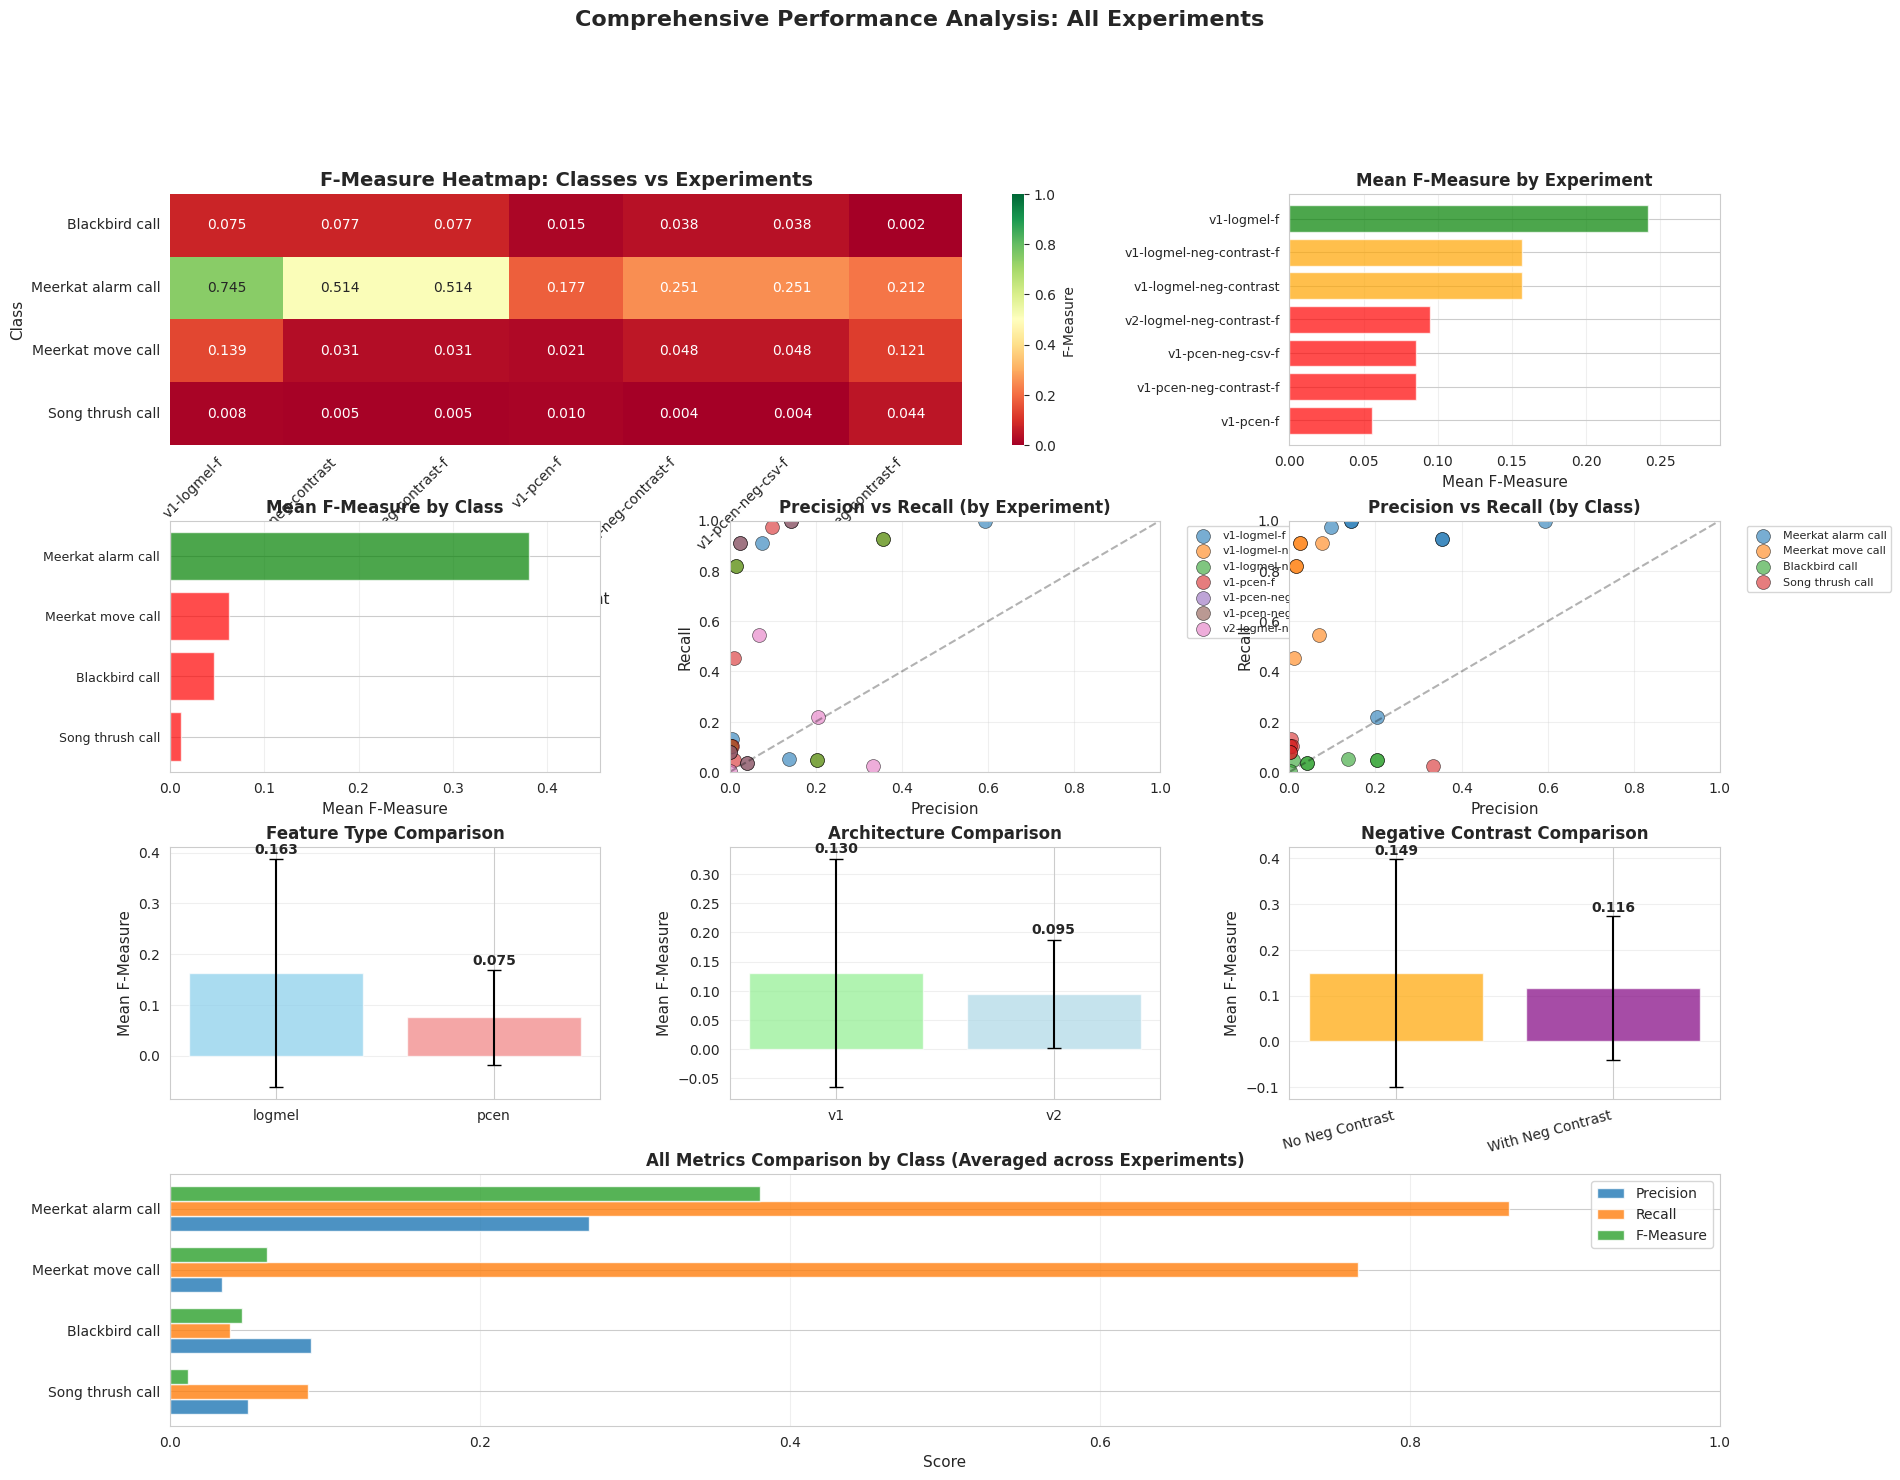


2. Creating experiment comparison dashboard...


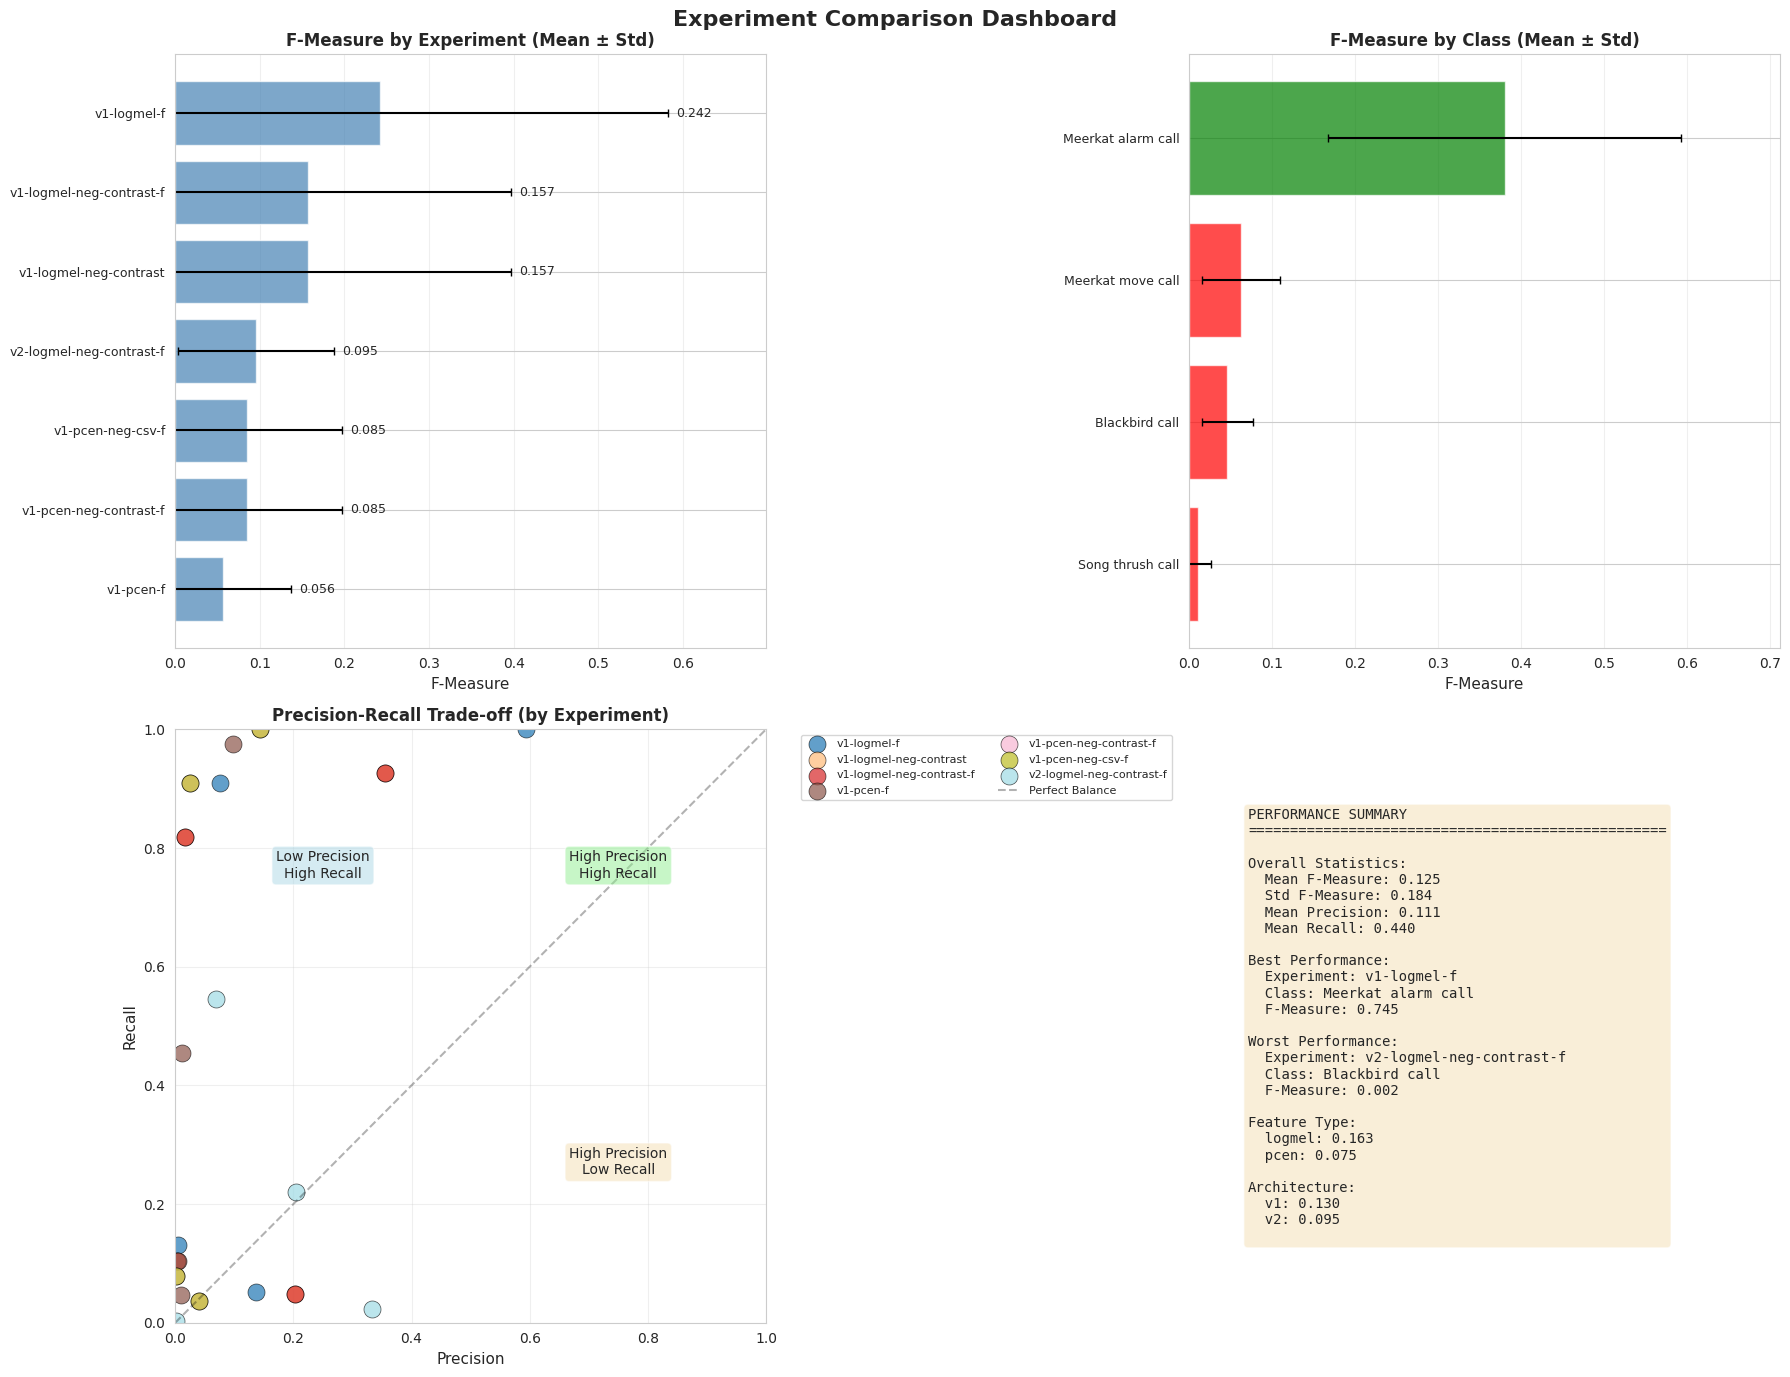


3. Creating class-wise performance comparison...


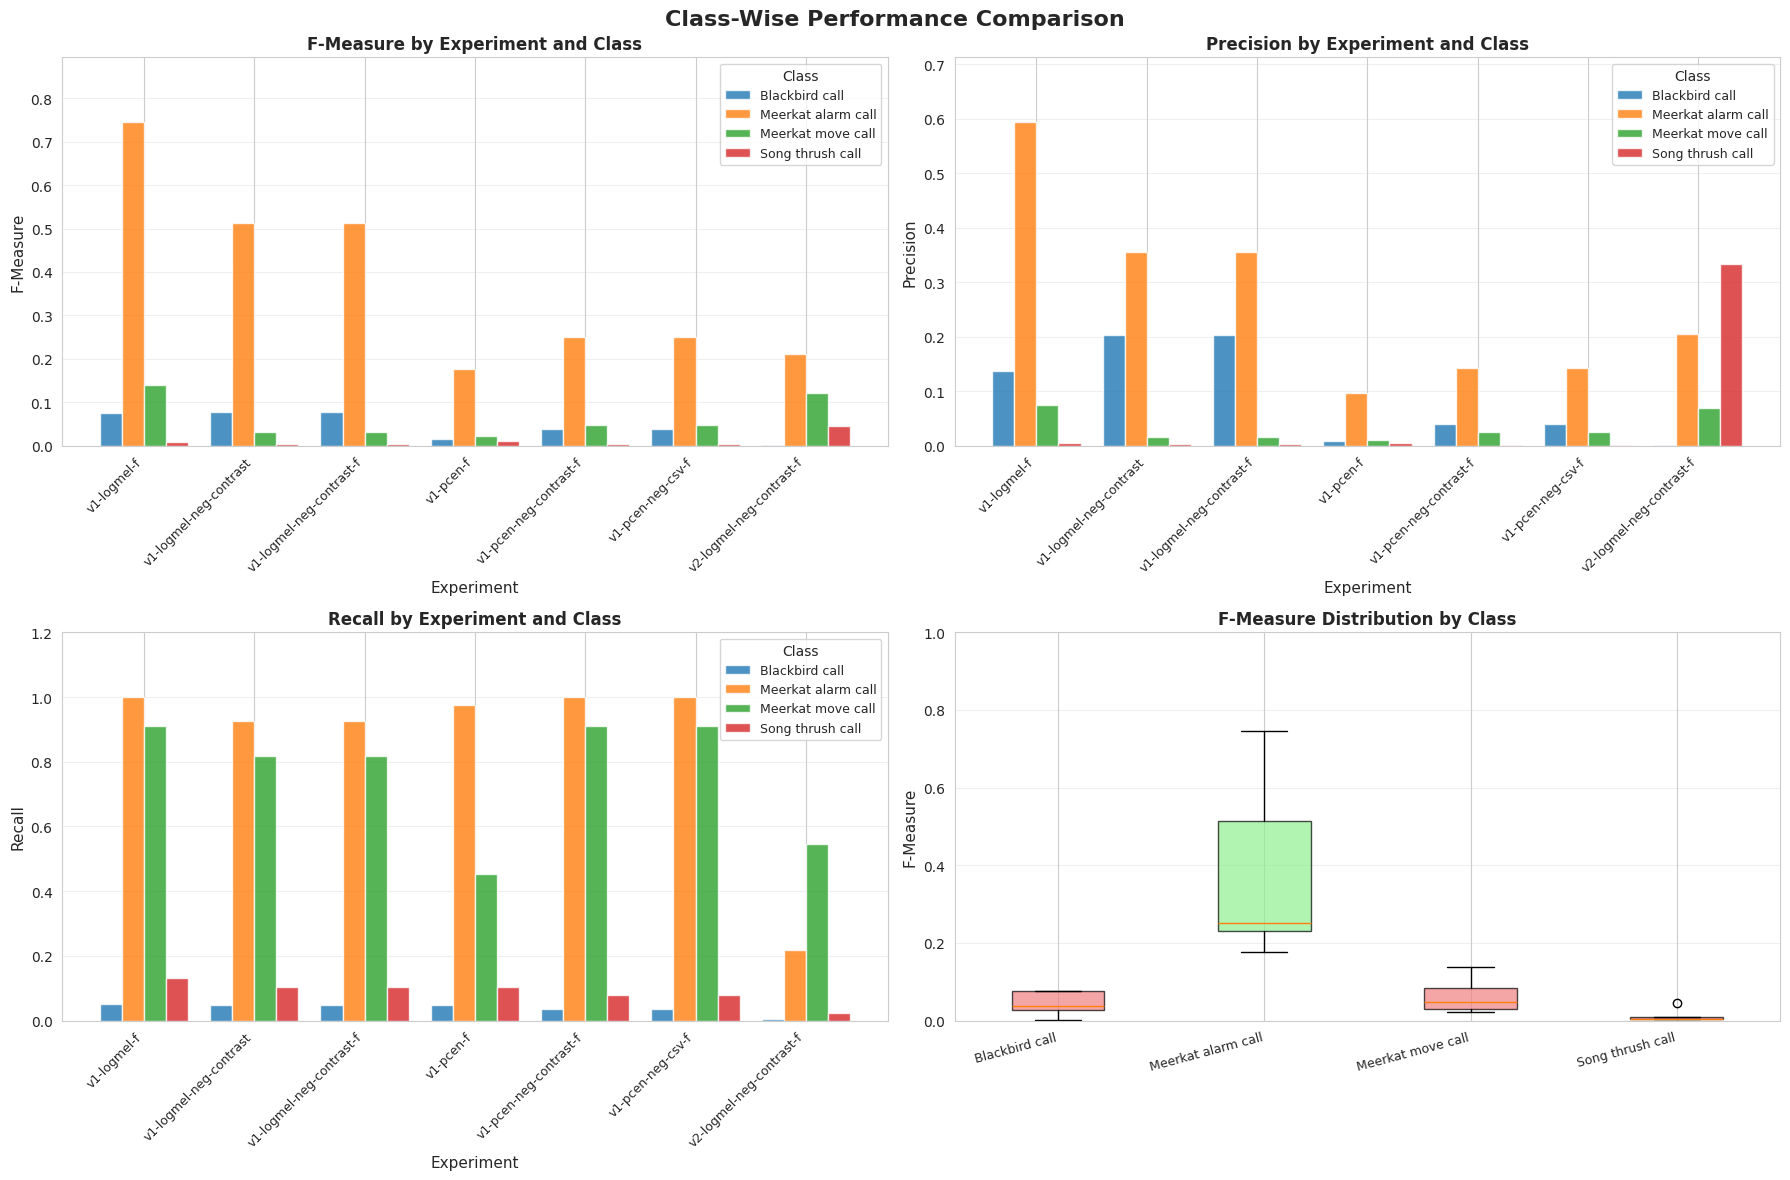


4. Creating feature and architecture comparison...


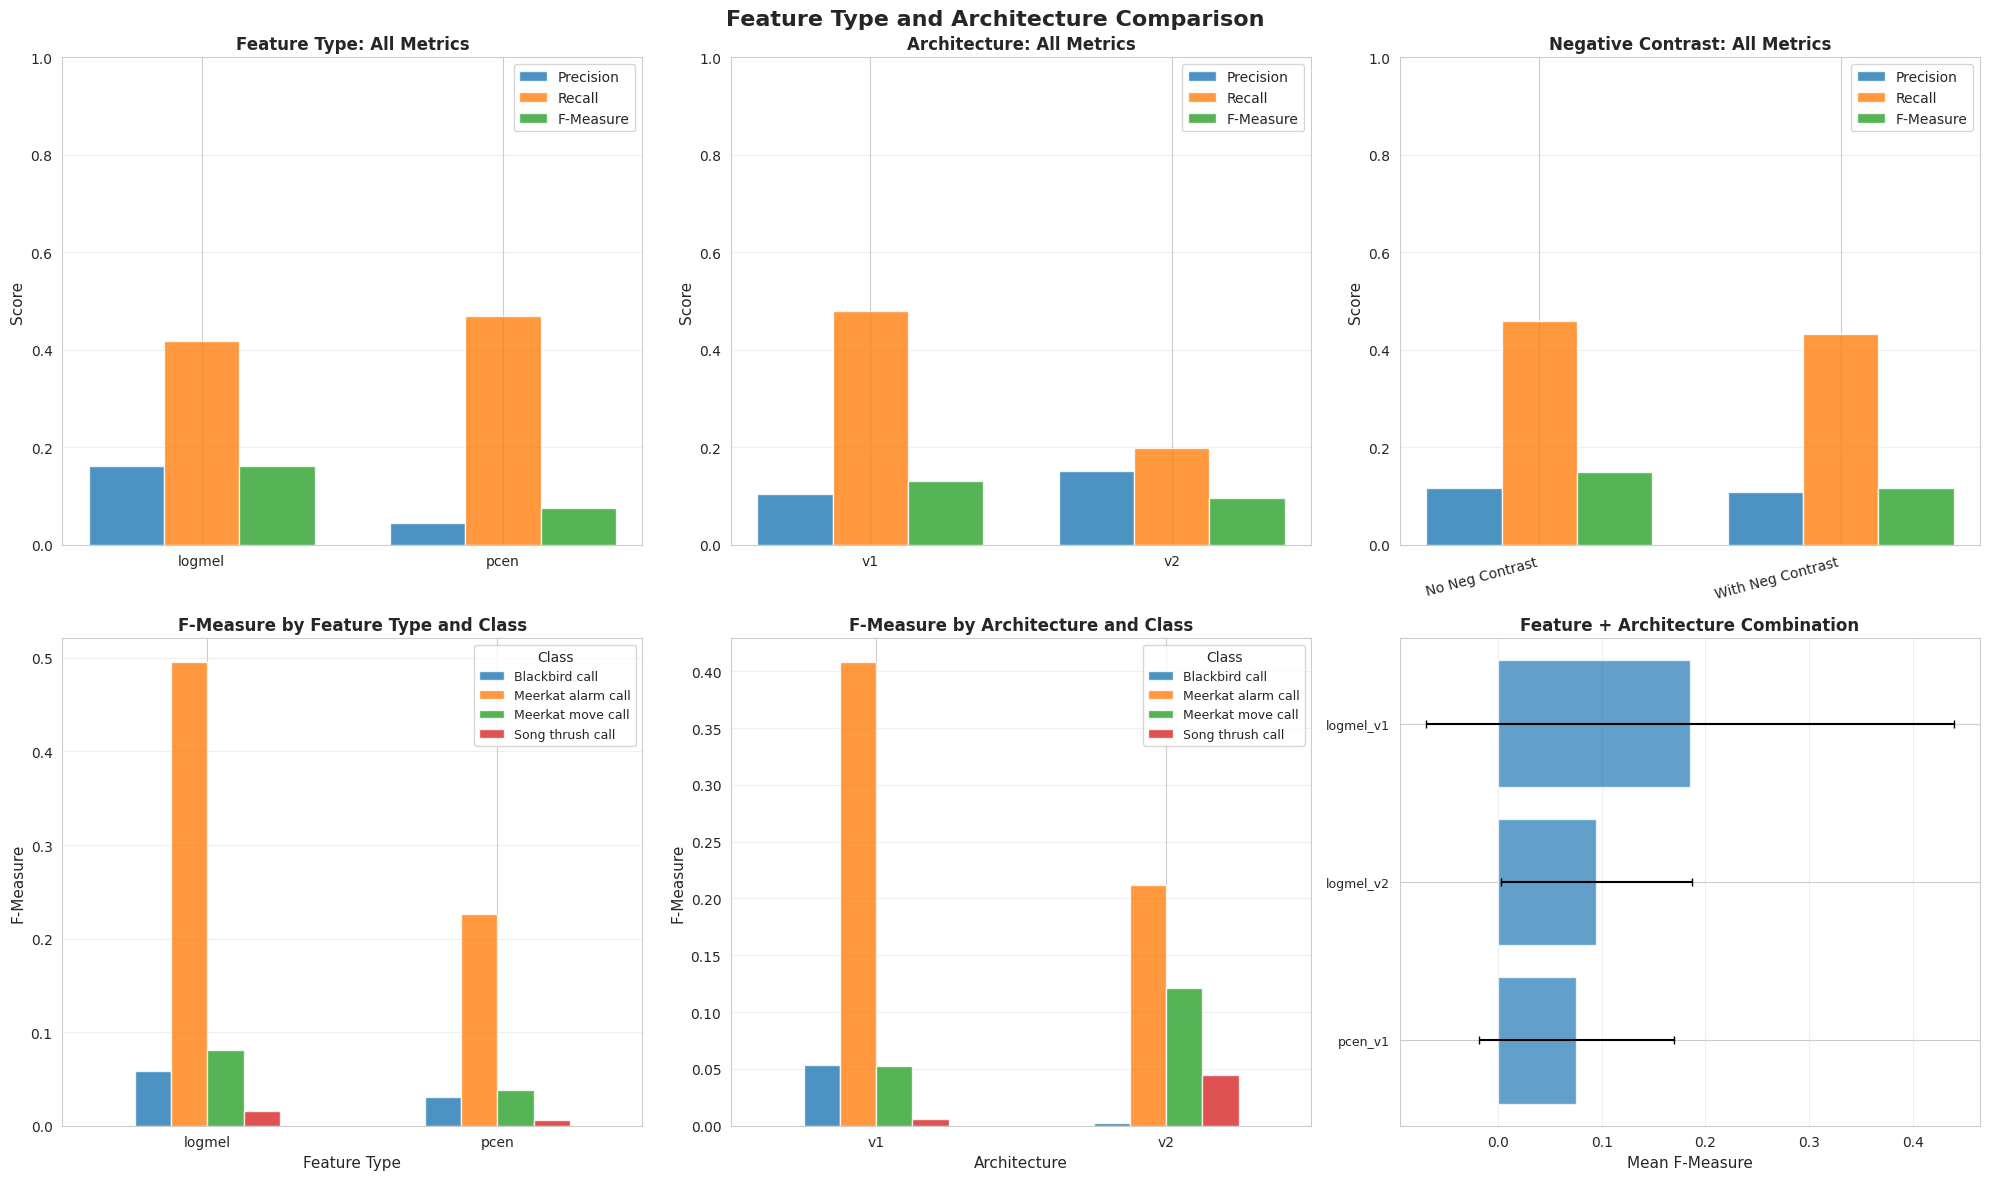


✅ All visualizations generated successfully!

💡 These visualizations show:
   - Performance heatmaps across experiments and classes
   - Precision-Recall trade-offs
   - Feature type and architecture comparisons
   - Class-wise performance patterns
   - Summary statistics and insights


In [89]:
# Generate comprehensive visualizations
if per_class_df is not None and not per_class_df.empty:
    print("="*100)
    print("GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("="*100)
    
    # 1. Main comprehensive visualization
    print("\n1. Creating comprehensive performance analysis...")
    fig1 = create_comprehensive_visualizations(per_class_df)
    
    # 2. Experiment comparison dashboard
    print("\n2. Creating experiment comparison dashboard...")
    fig2 = create_experiment_comparison_dashboard(per_class_df)
    
    # 3. Class-wise performance comparison
    print("\n3. Creating class-wise performance comparison...")
    fig3 = create_class_performance_comparison(per_class_df)
    
    # 4. Feature and architecture comparison
    print("\n4. Creating feature and architecture comparison...")
    fig4 = create_feature_architecture_comparison(per_class_df)
    
    print("\n" + "="*100)
    print("✅ All visualizations generated successfully!")
    print("="*100)
    print("\n💡 These visualizations show:")
    print("   - Performance heatmaps across experiments and classes")
    print("   - Precision-Recall trade-offs")
    print("   - Feature type and architecture comparisons")
    print("   - Class-wise performance patterns")
    print("   - Summary statistics and insights")
else:
    print("⚠ No per-class metrics available for visualization.")
    print("   Please run the batch processing cell (Cell 54) first to generate per-class metrics.")


### Detailed Experiment Rankings and Insights

This cell provides detailed rankings and insights for all experiments.


In [90]:
# Detailed rankings and insights
if per_class_df is not None and not per_class_df.empty:
    print("="*100)
    print("DETAILED EXPERIMENT RANKINGS AND INSIGHTS")
    print("="*100)
    
    # Experiment rankings
    print("\n📊 EXPERIMENT RANKINGS (by Mean F-Measure):")
    print("-" * 100)
    exp_rankings = per_class_df.groupby('experiment').agg({
        'f-measure': ['mean', 'std', 'min', 'max'],
        'precision': 'mean',
        'recall': 'mean'
    }).round(3)
    exp_rankings.columns = ['Mean_F', 'Std_F', 'Min_F', 'Max_F', 'Mean_Precision', 'Mean_Recall']
    exp_rankings = exp_rankings.sort_values('Mean_F', ascending=False)
    
    for i, (exp, row) in enumerate(exp_rankings.iterrows(), 1):
        print(f"\n{i}. {exp}")
        print(f"   F-Measure: {row['Mean_F']:.3f} ± {row['Std_F']:.3f} (range: {row['Min_F']:.3f} - {row['Max_F']:.3f})")
        print(f"   Precision: {row['Mean_Precision']:.3f} | Recall: {row['Mean_Recall']:.3f}")
        
        # Get best and worst classes for this experiment
        exp_data = per_class_df[per_class_df['experiment'] == exp]
        best_class = exp_data.loc[exp_data['f-measure'].idxmax()]
        worst_class = exp_data.loc[exp_data['f-measure'].idxmin()]
        print(f"   Best class: {best_class['class']} (F={best_class['f-measure']:.3f})")
        print(f"   Worst class: {worst_class['class']} (F={worst_class['f-measure']:.3f})")
    
    # Class rankings
    print("\n\n📊 CLASS RANKINGS (by Mean F-Measure):")
    print("-" * 100)
    class_rankings = per_class_df.groupby('class').agg({
        'f-measure': ['mean', 'std', 'min', 'max'],
        'precision': 'mean',
        'recall': 'mean'
    }).round(3)
    class_rankings.columns = ['Mean_F', 'Std_F', 'Min_F', 'Max_F', 'Mean_Precision', 'Mean_Recall']
    class_rankings = class_rankings.sort_values('Mean_F', ascending=False)
    
    for i, (cls, row) in enumerate(class_rankings.iterrows(), 1):
        print(f"\n{i}. {cls}")
        print(f"   F-Measure: {row['Mean_F']:.3f} ± {row['Std_F']:.3f} (range: {row['Min_F']:.3f} - {row['Max_F']:.3f})")
        print(f"   Precision: {row['Mean_Precision']:.3f} | Recall: {row['Mean_Recall']:.3f}")
        
        # Get best experiment for this class
        cls_data = per_class_df[per_class_df['class'] == cls]
        best_exp = cls_data.loc[cls_data['f-measure'].idxmax()]
        print(f"   Best experiment: {best_exp['experiment']} (F={best_exp['f-measure']:.3f})")
    
    # Key insights
    print("\n\n💡 KEY INSIGHTS:")
    print("-" * 100)
    
    # Best overall
    best_overall = per_class_df.loc[per_class_df['f-measure'].idxmax()]
    print(f"\n🏆 Best Overall Performance:")
    print(f"   Experiment: {best_overall['experiment']}")
    print(f"   Class: {best_overall['class']}")
    print(f"   F-Measure: {best_overall['f-measure']:.3f}")
    print(f"   Precision: {best_overall['precision']:.3f} | Recall: {best_overall['recall']:.3f}")
    
    # Feature type winner
    feature_winner = per_class_df.groupby('feature_type')['f-measure'].mean().idxmax()
    feature_mean = per_class_df.groupby('feature_type')['f-measure'].mean().max()
    print(f"\n📈 Best Feature Type: {feature_winner} (mean F={feature_mean:.3f})")
    
    # Architecture winner
    arch_winner = per_class_df.groupby('architecture')['f-measure'].mean().idxmax()
    arch_mean = per_class_df.groupby('architecture')['f-measure'].mean().max()
    print(f"🏗️  Best Architecture: {arch_winner} (mean F={arch_mean:.3f})")
    
    # Negative contrast impact
    neg_mean = per_class_df[per_class_df['has_neg_contrast'] == True]['f-measure'].mean()
    no_neg_mean = per_class_df[per_class_df['has_neg_contrast'] == False]['f-measure'].mean()
    if neg_mean > no_neg_mean:
        print(f"✅ Negative Contrast helps: {neg_mean:.3f} vs {no_neg_mean:.3f}")
    else:
        print(f"⚠️  Negative Contrast doesn't help: {neg_mean:.3f} vs {no_neg_mean:.3f}")
    
    # Precision-Recall pattern
    mean_precision = per_class_df['precision'].mean()
    mean_recall = per_class_df['recall'].mean()
    print(f"\n📊 Precision-Recall Pattern:")
    print(f"   Mean Precision: {mean_precision:.3f}")
    print(f"   Mean Recall: {mean_recall:.3f}")
    if mean_recall > mean_precision * 2:
        print(f"   ⚠️  High recall, low precision - many false positives detected")
    elif mean_precision > mean_recall * 2:
        print(f"   ⚠️  High precision, low recall - missing many true positives")
    else:
        print(f"   ✅ Balanced precision and recall")
    
    print("\n" + "="*100)
else:
    print("⚠ No per-class metrics available for analysis.")


DETAILED EXPERIMENT RANKINGS AND INSIGHTS

📊 EXPERIMENT RANKINGS (by Mean F-Measure):
----------------------------------------------------------------------------------------------------

1. v1-logmel-f
   F-Measure: 0.242 ± 0.340 (range: 0.008 - 0.745)
   Precision: 0.203 | Recall: 0.523
   Best class: Meerkat alarm call (F=0.745)
   Worst class: Song thrush call (F=0.008)

2. v1-logmel-neg-contrast
   F-Measure: 0.157 ± 0.240 (range: 0.005 - 0.514)
   Precision: 0.144 | Recall: 0.474
   Best class: Meerkat alarm call (F=0.514)
   Worst class: Song thrush call (F=0.005)

3. v1-logmel-neg-contrast-f
   F-Measure: 0.157 ± 0.240 (range: 0.005 - 0.514)
   Precision: 0.144 | Recall: 0.474
   Best class: Meerkat alarm call (F=0.514)
   Worst class: Song thrush call (F=0.005)

4. v2-logmel-neg-contrast-f
   F-Measure: 0.095 ± 0.092 (range: 0.002 - 0.212)
   Precision: 0.152 | Recall: 0.198
   Best class: Meerkat alarm call (F=0.212)
   Worst class: Blackbird call (F=0.002)

5. v1-pcen-neg-co

### Check Which Epoch/Checkpoint Was Used for Each Experiment

This cell shows which epoch and checkpoint was used for generating the per-class metrics, confirming we're using the BEST checkpoint, not the last epoch.


In [91]:
# Check which epoch/checkpoint was used for each experiment
print("="*100)
print("EPOCH/CHECKPOINT USAGE SUMMARY")
print("="*100)
print("\nThis shows which epoch and checkpoint was used for each experiment.")
print("We use the BEST checkpoint (highest validation F-measure), NOT the last epoch.\n")

checkpoint_summary = []

for exp_name, exp_dir in zip(experiments_to_analyze['experiment_name'], 
                             experiments_to_analyze['path']):
    exp_dir = Path(exp_dir)
    
    # Check best_info.json
    best_info_path = exp_dir / "checkpoints" / "best_info.json"
    best_epoch = None
    best_fmeasure = None
    checkpoint_path_str = None
    
    if best_info_path.exists():
        try:
            with open(best_info_path, 'r') as f:
                best_info = json.load(f)
                best_epoch = best_info.get('best_epoch', 'unknown')
                best_fmeasure = best_info.get('dcase_metrics', {}).get('fmeasure')
                checkpoint_path_str = best_info.get('checkpoint_path', 'unknown')
        except Exception as e:
            pass
    
    # Check val_eval for best epoch
    val_eval_dir = exp_dir / "val_eval"
    val_eval_best_epoch = None
    val_eval_best_f = None
    
    if val_eval_dir.exists():
        reports = find_evaluation_reports_for_experiment(exp_dir)
        if reports:
            best_report_info = get_best_report_info(reports)
            if best_report_info:
                _, val_eval_best_epoch, _, val_eval_best_f = best_report_info
    
    # Find actual checkpoint
    checkpoint_path = find_checkpoint(exp_dir, "best")
    checkpoint_name = checkpoint_path.name if checkpoint_path else "Not found"
    
    # Determine which source to use
    if best_epoch and best_epoch != 'unknown':
        source = "best_info.json"
        epoch_used = best_epoch
        f_used = best_fmeasure
    elif val_eval_best_epoch:
        source = "val_eval reports"
        epoch_used = val_eval_best_epoch
        f_used = val_eval_best_f
    else:
        source = "checkpoint file"
        epoch_used = "unknown"
        f_used = None
    
    checkpoint_summary.append({
        'experiment': exp_name,
        'best_epoch': epoch_used,
        'best_fmeasure': f_used,
        'checkpoint': checkpoint_name,
        'source': source
    })

if checkpoint_summary:
    summary_df = pd.DataFrame(checkpoint_summary)
    print(summary_df.to_string(index=False))
    
    print("\n" + "="*100)
    print("KEY POINTS:")
    print("="*100)
    print("1. ✓ We use the BEST checkpoint (highest validation F-measure), NOT the last epoch")
    print("2. ✓ The best epoch is determined from:")
    print("   - best_info.json (tracks best checkpoint during training)")
    print("   - OR val_eval/ reports (finds epoch with highest F-measure)")
    print("3. ✓ This ensures we analyze the model's peak performance, not degraded final epoch")
    print("="*100)
else:
    print("No checkpoint information available.")


EPOCH/CHECKPOINT USAGE SUMMARY

This shows which epoch and checkpoint was used for each experiment.
We use the BEST checkpoint (highest validation F-measure), NOT the last epoch.



              experiment best_epoch  best_fmeasure   checkpoint          source
               v1-logmel    unknown            NaN    Not found checkpoint file
             v1-logmel-f          1         40.490    last.ckpt  best_info.json
         v1-logmel-final    unknown            NaN    Not found checkpoint file
  v1-logmel-neg-contrast         11         34.530    last.ckpt  best_info.json
v1-logmel-neg-contrast-f          7         34.620    last.ckpt  best_info.json
               v1-pcen-f         20         40.220 last-v1.ckpt  best_info.json
           v1-pcen-final    unknown            NaN    Not found checkpoint file
  v1-pcen-neg-contrast-f         15         34.200    last.ckpt  best_info.json
       v1-pcen-neg-csv-f         15         47.642    last.ckpt  best_info.json
            v1-pcen-test    unknown            NaN    Not found checkpoint file
v2-logmel-neg-contrast-f         18          2.050    last.ckpt  best_info.json
           v2-pcen-final    unknown     

### Validation F-Score Comparison Across All Experiments

This chart compares the best validation F-measure (F-score) for all experiments that have `val_eval` information, making it easy to see which experiment performed best overall.


In [92]:
def create_validation_fscore_comparison(all_experiment_results: Dict = None):
    """
    Create a comparison chart of validation F-scores across all experiments.
    
    Args:
        all_experiment_results: Dictionary with experiment results (optional, will load if not provided)
    """
    # Load data if not provided
    if all_experiment_results is None:
        if 'all_experiment_results' in globals():
            all_experiment_results = globals()['all_experiment_results']
        else:
            print("⚠ No experiment results available. Please run the data loading cells first.")
            return
    
    # Extract validation F-scores from experiments with val_eval data
    fscore_data = []
    
    for exp_name, result in all_experiment_results.items():
        # Check if this experiment has val_eval data
        data_source = result.get('data_source', '')
        has_val_eval = 'val_eval' in data_source or 'evaluation_report' in data_source
        
        # Get best F-measure - PRIORITIZE best_info.json over val_eval reports
        # because val_eval reports may have incorrect/inflated values
        best_fmeasure = None
        best_epoch = None
        best_threshold = None
        
        # FIRST: Try to get from experiments_to_analyze (which reads from best_info.json)
        # This is the most reliable source as it comes from the training checkpoint tracking
        if 'experiments_to_analyze' in globals():
            exp_row = experiments_to_analyze[experiments_to_analyze['experiment_name'] == exp_name]
            if not exp_row.empty:
                best_fmeasure_raw = exp_row.iloc[0].get('best_fmeasure')
                if best_fmeasure_raw is not None and pd.notna(best_fmeasure_raw):
                    # best_info.json stores F-measure as percentage (e.g., 40.490 = 40.49%)
                    best_fmeasure = best_fmeasure_raw / 100.0
        
        # SECOND: Try to get from result's best_fmeasure (if it was set from best_info.json)
        if best_fmeasure is None:
            best_fmeasure_raw = result.get('best_fmeasure')
            if best_fmeasure_raw is not None:
                # Check if it's already normalized or in percentage format
                if best_fmeasure_raw > 1.0:
                    best_fmeasure = best_fmeasure_raw / 100.0
                else:
                    best_fmeasure = best_fmeasure_raw
        
        # THIRD: Fall back to overall_scores from val_eval reports (but these may be incorrect)
        if best_fmeasure is None:
            overall_scores = result.get('overall_scores', {})
            if overall_scores:
                best_fmeasure = overall_scores.get('fmeasure') or overall_scores.get('f-measure')
                if best_fmeasure and best_fmeasure > 1.0:
                    best_fmeasure = best_fmeasure / 100.0
        
        # Get epoch and threshold info if available
        best_epoch = result.get('best_epoch')  # Try direct access first
        if not best_epoch:
            metadata = result.get('metadata', {})
            if metadata:
                best_epoch = metadata.get('best_epoch')
        # Try to extract from path if still not found
        if not best_epoch or best_epoch == 'unknown':
            eval_path = result.get('best_report_path', '') or result.get('best_eval_report_path', '')
            if 'epoch_' in str(eval_path):
                parts = str(eval_path).split('/')
                for part in parts:
                    if part.startswith('epoch_'):
                        best_epoch = part
                        break
        
        # Only include experiments with valid F-measure
        if best_fmeasure is not None and pd.notna(best_fmeasure):
            # Ensure F-measure is in 0-1 range (not percentage)
            if best_fmeasure > 1.0:
                best_fmeasure = best_fmeasure / 100.0
            
            # Determine which source was actually used
            source_used = 'unknown'
            if 'experiments_to_analyze' in globals():
                exp_row = experiments_to_analyze[experiments_to_analyze['experiment_name'] == exp_name]
                if not exp_row.empty and pd.notna(exp_row.iloc[0].get('best_fmeasure')):
                    source_used = 'best_info.json'
            elif result.get('best_fmeasure') is not None:
                source_used = 'best_info.json (from result)'
            elif result.get('overall_scores'):
                source_used = 'val_eval reports'
            else:
                source_used = data_source  # Use the original data_source from result
            
            fscore_data.append({
                'experiment': exp_name,
                'f_measure': best_fmeasure,
                'best_epoch': best_epoch or 'unknown',
                'has_val_eval': has_val_eval,
                'data_source': source_used  # Track where the data came from
            })
    
    if not fscore_data:
        print("⚠ No validation F-score data available for comparison.")
        print("   Make sure experiments have been loaded with val_eval information.")
        return
    
    if not fscore_data:
        print("⚠ No validation F-score data available for comparison.")
        print("   Make sure experiments have been loaded with val_eval information.")
        return None
    
    # Create DataFrame
    fscore_df = pd.DataFrame(fscore_data)
    
    # Sort by F-measure (descending)
    fscore_df = fscore_df.sort_values('f_measure', ascending=False)
    
    # Print data source info for debugging
    print(f"\n📊 Data Sources:")
    if 'data_source' in fscore_df.columns:
        best_info_count = len(fscore_df[fscore_df['data_source'].str.contains('best_info', na=False)])
        val_eval_count = len(fscore_df[fscore_df['data_source'].str.contains('val_eval', na=False)])
        print(f"   Using best_info.json: {best_info_count} experiments")
        print(f"   Using val_eval reports: {val_eval_count} experiments")
    print(f"   Total experiments: {len(fscore_df)}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('Validation F-Score Comparison Across All Experiments', 
                fontsize=16, fontweight='bold')
    
    # 1. Horizontal bar chart
    ax1 = axes[0]
    colors = ['green' if f >= 0.7 else 'orange' if f >= 0.5 else 'red' 
              for f in fscore_df['f_measure'].values]
    
    bars = ax1.barh(range(len(fscore_df)), fscore_df['f_measure'].values, 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax1.set_yticks(range(len(fscore_df)))
    ax1.set_yticklabels(fscore_df['experiment'].values, fontsize=10)
    ax1.set_xlabel('Validation F-Measure (F-Score)', fontsize=12, fontweight='bold')
    ax1.set_title('Best Validation F-Score by Experiment', fontsize=13, fontweight='bold')
    ax1.set_xlim(0, min(1.0, max(fscore_df['f_measure'].values) * 1.15))
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='F=0.5 threshold')
    ax1.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='F=0.7 threshold')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(fscore_df.iterrows()):
        f_val = row['f_measure']
        ax1.text(f_val + 0.01, i, f'{f_val:.3f}', 
                va='center', fontsize=9, fontweight='bold')
        
        # Add epoch info if available
        if row['best_epoch'] and row['best_epoch'] != 'unknown':
            ax1.text(0.02, i, f"({row['best_epoch']})", 
                    va='center', fontsize=8, style='italic', color='gray')
    
    ax1.legend(loc='lower right', fontsize=9)
    
    # 2. Ranking with statistics
    ax2 = axes[1]
    ax2.axis('off')
    
    # Create summary text
    summary_text = "EXPERIMENT RANKINGS\n" + "="*60 + "\n\n"
    
    # Overall statistics
    mean_f = fscore_df['f_measure'].mean()
    std_f = fscore_df['f_measure'].std()
    max_f = fscore_df['f_measure'].max()
    min_f = fscore_df['f_measure'].min()
    
    summary_text += f"Overall Statistics:\n"
    summary_text += f"  Mean F-Score: {mean_f:.3f} ± {std_f:.3f}\n"
    summary_text += f"  Best F-Score: {max_f:.3f}\n"
    summary_text += f"  Worst F-Score: {min_f:.3f}\n"
    summary_text += f"  Range: {max_f - min_f:.3f}\n\n"
    
    # Top 5 experiments
    summary_text += "Top 5 Experiments:\n"
    summary_text += "-" * 60 + "\n"
    for i, (idx, row) in enumerate(fscore_df.head(5).iterrows(), 1):
        exp_name = row['experiment']
        f_val = row['f_measure']
        epoch = row['best_epoch'] if row['best_epoch'] != 'unknown' else 'N/A'
        summary_text += f"{i}. {exp_name:30s} F={f_val:.3f}  (epoch: {epoch})\n"
    
    # Bottom 3 experiments (if more than 5 total)
    if len(fscore_df) > 5:
        summary_text += f"\nBottom 3 Experiments:\n"
        summary_text += "-" * 60 + "\n"
        for i, (idx, row) in enumerate(fscore_df.tail(3).iterrows(), len(fscore_df) - 2):
            exp_name = row['experiment']
            f_val = row['f_measure']
            epoch = row['best_epoch'] if row['best_epoch'] != 'unknown' else 'N/A'
            summary_text += f"{i}. {exp_name:30s} F={f_val:.3f}  (epoch: {epoch})\n"
    
    # Performance categories
    excellent = len(fscore_df[fscore_df['f_measure'] >= 0.7])
    good = len(fscore_df[(fscore_df['f_measure'] >= 0.5) & (fscore_df['f_measure'] < 0.7)])
    poor = len(fscore_df[fscore_df['f_measure'] < 0.5])
    
    summary_text += f"\nPerformance Categories:\n"
    summary_text += "-" * 60 + "\n"
    summary_text += f"  Excellent (≥0.7): {excellent} experiments\n"
    summary_text += f"  Good (0.5-0.7):    {good} experiments\n"
    summary_text += f"  Poor (<0.5):       {poor} experiments\n"
    
    # Best experiment details
    best_exp = fscore_df.iloc[0]
    summary_text += f"\n🏆 Best Experiment:\n"
    summary_text += "-" * 60 + "\n"
    summary_text += f"  Name: {best_exp['experiment']}\n"
    summary_text += f"  F-Score: {best_exp['f_measure']:.3f}\n"
    summary_text += f"  Best Epoch: {best_exp['best_epoch']}\n"
    
    ax2.text(0.05, 0.95, summary_text, fontsize=10, family='monospace',
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig, fscore_df


VALIDATION F-SCORE COMPARISON

This chart compares the best validation F-measure for all experiments with val_eval data.
This shows which experiment achieved the highest overall accuracy.


📊 Data Sources:
   Using best_info.json: 7 experiments
   Using val_eval reports: 0 experiments
   Total experiments: 7


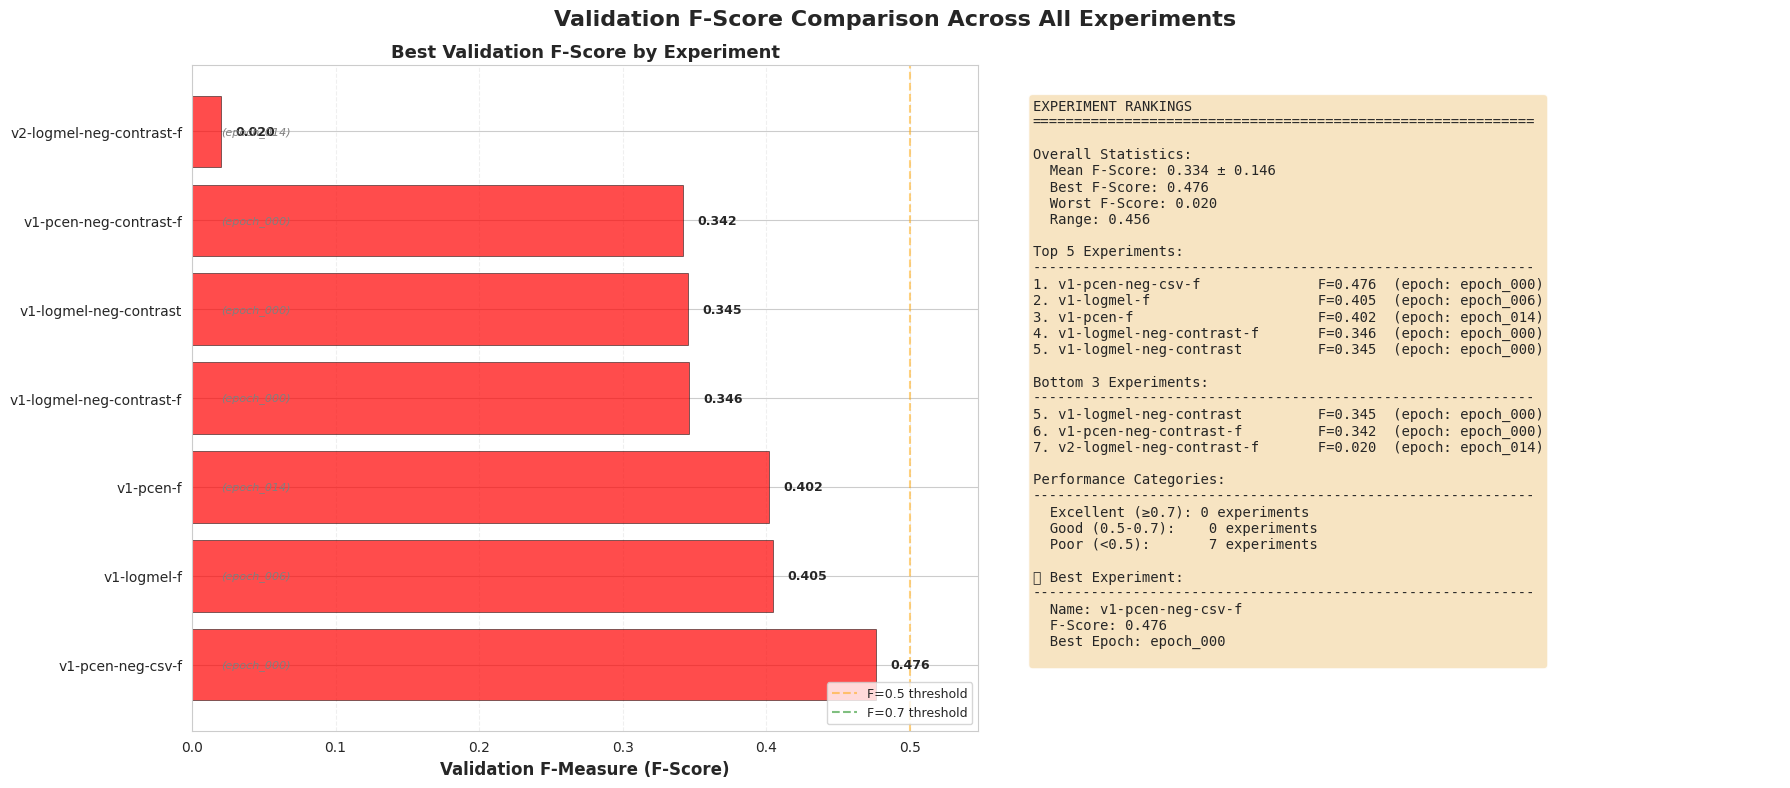


✓ Comparison data saved to: outputs/analysis_results/validation_fscore_comparison.csv

KEY INSIGHTS:

🏆 Best Experiment: v1-pcen-neg-csv-f
   F-Score: 0.476
   Best Epoch: epoch_000

⚠️  Worst Experiment: v2-logmel-neg-contrast-f
   F-Score: 0.020
   Best Epoch: epoch_014

📊 Average F-Score: 0.334
   Range: 0.476 - 0.020


In [93]:
# Generate validation F-score comparison chart
print("="*100)
print("VALIDATION F-SCORE COMPARISON")
print("="*100)
print("\nThis chart compares the best validation F-measure for all experiments with val_eval data.")
print("This shows which experiment achieved the highest overall accuracy.\n")

# Check if we have experiment results
if 'all_experiment_results' in globals():
    exp_results = globals()['all_experiment_results']
    if exp_results and len(exp_results) > 0:
        result = create_validation_fscore_comparison(exp_results)
        if result:
            fig, fscore_df = result
            
            # Also save to CSV for reference
            output_dir = Path("outputs/analysis_results")
            output_dir.mkdir(parents=True, exist_ok=True)
            csv_path = output_dir / "validation_fscore_comparison.csv"
            fscore_df.to_csv(csv_path, index=False)
            print(f"\n✓ Comparison data saved to: {csv_path}")
            
            print("\n" + "="*100)
            print("KEY INSIGHTS:")
            print("="*100)
            best_exp = fscore_df.iloc[0]
            worst_exp = fscore_df.iloc[-1]
            print(f"\n🏆 Best Experiment: {best_exp['experiment']}")
            print(f"   F-Score: {best_exp['f_measure']:.3f}")
            print(f"   Best Epoch: {best_exp['best_epoch']}")
            
            print(f"\n⚠️  Worst Experiment: {worst_exp['experiment']}")
            print(f"   F-Score: {worst_exp['f_measure']:.3f}")
            print(f"   Best Epoch: {worst_exp['best_epoch']}")
            
            mean_f = fscore_df['f_measure'].mean()
            print(f"\n📊 Average F-Score: {mean_f:.3f}")
            print(f"   Range: {best_exp['f_measure']:.3f} - {worst_exp['f_measure']:.3f}")
            print("="*100)
        else:
            print("⚠ Could not generate comparison chart.")
    else:
        print("⚠ No experiment results available.")
        print("   Please run the data loading cells (Cell 16) first to load experiment results.")
else:
    print("⚠ No experiment results available.")
    print("   Please run the data loading cells (Cell 16) first to load experiment results.")


### Audio Waveform Visualization with Predictions vs Ground Truth

This section creates timeline visualizations showing predicted events overlaid on ground truth, similar to the segmentation notebook. The visualizations use predictions from the **best checkpoint/epoch** for each experiment.


In [94]:
def plot_audio_timeline_comparison_enhanced(
    pred_csv: Path,
    val_data_dir: Path,
    audio_files = None,  # List[str] or None
    max_files: int = 10,
    title: str = "Event Detection: Predictions vs Ground Truth"
):
    """
    Enhanced timeline visualization comparing predictions vs ground truth.
    Similar to event_detection_viz.ipynb but integrated into this notebook.
    
    Args:
        pred_csv: Path to prediction CSV file
        val_data_dir: Validation data directory
        audio_files: List of specific audio files to plot (None = plot all)
        max_files: Maximum number of files to plot
        title: Plot title
    """
    from matplotlib.lines import Line2D
    from utils.evaluation import POS_VALUE, N_SHOTS
    import os
    
    # Load predictions
    if not pred_csv.exists():
        print(f"⚠ Prediction CSV not found: {pred_csv}")
        return None
    
    pred_df = pd.read_csv(pred_csv)
    
    # Normalize audio filenames
    def normalize_audio_name(name):
        name = str(name).strip()
        name = Path(name).name
        if name.lower().endswith('.csv'):
            name = name[:-4]
        if not name.lower().endswith('.wav'):
            name = name + '.wav'
        return name
    
    pred_df['Audiofilename'] = pred_df['Audiofilename'].map(normalize_audio_name)
    
    # Get unique audio files
    if audio_files is None:
        audio_files = pred_df['Audiofilename'].unique()[:max_files]
    else:
        audio_files = [normalize_audio_name(f) for f in audio_files]
        audio_files = [f for f in audio_files if f in pred_df['Audiofilename'].values]
    
    if not audio_files:
        print("⚠ No audio files found to plot")
        return None
    
    # Prepare data
    pred_events = {}
    gt_events = {}
    
    for audio_name in audio_files:
        # Predictions
        audio_preds = pred_df[pred_df['Audiofilename'] == audio_name]
        pred_events[audio_name] = list(
            zip(audio_preds['Starttime'].astype(float), audio_preds['Endtime'].astype(float))
        )
        
        # Ground truth - find CSV file
        audio_base = audio_name.replace('.wav', '')
        gt_found = False
        
        # Search in validation directory subdirectories
        for subset_dir in val_data_dir.iterdir():
            if not subset_dir.is_dir():
                continue
            
            gt_csv = subset_dir / f"{audio_base}.csv"
            if gt_csv.exists():
                try:
                    gt_df = pd.read_csv(gt_csv, dtype={"Starttime": np.float64, "Endtime": np.float64})
                    
                    # Remove support shots if needed (check if variable exists)
                    drop_shots = globals().get('DROP_SUPPORT_SHOTS', True)
                    if drop_shots:
                        from utils.evaluation import remove_shots_from_ref
                        gt_df = remove_shots_from_ref(gt_df, number_shots=N_SHOTS)
                    
                    # Get positive events
                    q_col = None
                    for col in gt_df.columns:
                        if col == 'Q' or 'Q' in col:
                            q_col = col
                            break
                    
                    if q_col:
                        pos_events = gt_df[gt_df[q_col] == POS_VALUE]
                    else:
                        # Try to find any column with POS values
                        pos_events = gt_df
                    
                    gt_events[audio_name] = list(
                        zip(pos_events['Starttime'].astype(float), pos_events['Endtime'].astype(float))
                    )
                    gt_found = True
                    break
                except Exception as e:
                    print(f"  ⚠ Error loading GT for {audio_name}: {e}")
                    continue
        
        if not gt_found:
            gt_events[audio_name] = []
            print(f"  ⚠ Ground truth not found for {audio_name}")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(18, max(5, len(audio_files) * 0.6)))
    
    for idx, audio_name in enumerate(audio_files):
        y_gt = idx + 0.18
        y_pred = idx - 0.18
        
        # Plot ground truth (green)
        for s, e in gt_events.get(audio_name, []):
            ax.hlines(y_gt, s, e, color='seagreen', linewidth=4, alpha=0.85, label='Ground Truth' if idx == 0 else '')
        
        # Plot predictions (blue)
        for s, e in pred_events.get(audio_name, []):
            ax.hlines(y_pred, s, e, color='royalblue', linewidth=3, alpha=0.85, label='Predictions' if idx == 0 else '')
    
    ax.set_yticks(range(len(audio_files)))
    ax.set_yticklabels(audio_files)
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Audio Files', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # Create legend
    handles = [
        Line2D([0], [0], color='seagreen', lw=4, label='Ground Truth'),
        Line2D([0], [0], color='royalblue', lw=3, label='Predictions'),
    ]
    ax.legend(handles=handles, loc='upper right', frameon=True, fontsize=10)
    plt.tight_layout()
    plt.show()
    
    return fig


In [95]:
# Configuration for timeline visualizations
DROP_SUPPORT_SHOTS = True  # Remove 5 support shots from GT (matches evaluation protocol)
MAX_AUDIO_FILES_PER_VIS = 10  # Maximum number of audio files to show per visualization
SELECTED_AUDIO_FILES = None  # Set to specific list, e.g., ['ME1.wav', 'ME2.wav'] or None for all

print("Timeline Visualization Configuration:")
print(f"  Validation data: {VAL_DATA_DIR}")
print(f"  Drop support shots: {DROP_SUPPORT_SHOTS}")
print(f"  Max files per visualization: {MAX_AUDIO_FILES_PER_VIS}")
print(f"  Selected files: {SELECTED_AUDIO_FILES or 'All available files'}")


Timeline Visualization Configuration:
  Validation data: /data/msc-proj/Validation_Set_DSAI_2025_2026
  Drop support shots: True
  Max files per visualization: 10
  Selected files: All available files


### Generate Timeline Visualizations for All Experiments

This cell generates timeline visualizations for all experiments using predictions from their best checkpoints.


In [96]:
# Generate timeline visualizations for all experiments with predictions
print("="*100)
print("GENERATING TIMELINE VISUALIZATIONS FOR ALL EXPERIMENTS")
print("="*100)
print("\nThis will create timeline visualizations using predictions from the BEST checkpoint/epoch")
print("for each experiment, showing predicted events vs ground truth.\n")
print("We'll try to use existing predictions from val_eval directories first, then fall back")
print("to generated predictions if available.\n")

visualizations_created = []

# First, try to use predictions from val_eval directories (best epoch predictions)
if 'all_experiment_results' in globals() and all_experiment_results:
    print("Attempting to use predictions from val_eval directories (best epoch)...")
    
    for exp_name, result in all_experiment_results.items():
        # Try to find Eval_raw.csv from the best epoch in val_eval
        best_report_path = result.get('best_report_path')
        best_epoch = result.get('best_epoch')
        best_threshold = result.get('best_threshold')
        
        eval_raw_csv = None
        
        if best_report_path:
            best_report_path = Path(best_report_path)
            # Eval_raw.csv should be in the same directory as the evaluation report
            eval_raw_csv = best_report_path.parent / "Eval_raw.csv"
        
        # If not found, try to construct path from epoch and threshold
        if not eval_raw_csv or not eval_raw_csv.exists():
            if best_epoch and best_threshold:
                exp_dir = EXPERIMENT_BASE_DIR / exp_name
                val_eval_dir = exp_dir / "val_eval"
                # Try different threshold formats (0.25 vs 0.25000000000000003)
                possible_paths = [
                    val_eval_dir / best_epoch / str(best_threshold) / "Eval_raw.csv",
                    val_eval_dir / best_epoch / f"{float(best_threshold):.2f}" / "Eval_raw.csv",
                ]
                # Also try to find any Eval_raw.csv in the best epoch directory
                if val_eval_dir.exists() and (val_eval_dir / best_epoch).exists():
                    epoch_dir = val_eval_dir / best_epoch
                    for threshold_dir in epoch_dir.iterdir():
                        if threshold_dir.is_dir():
                            possible_path = threshold_dir / "Eval_raw.csv"
                            if possible_path.exists():
                                eval_raw_csv = possible_path
                                break
        
        if eval_raw_csv and eval_raw_csv.exists():
                print(f"\n[{exp_name}] Using predictions from val_eval (best epoch)...")
                print(f"  Source: {eval_raw_csv}")
                
                try:
                    fig = plot_audio_timeline_comparison_enhanced(
                        pred_csv=eval_raw_csv,
                        val_data_dir=VAL_DATA_DIR,
                        audio_files=SELECTED_AUDIO_FILES,
                        max_files=MAX_AUDIO_FILES_PER_VIS,
                        title=f"Event Detection: {exp_name} - Predictions vs Ground Truth (Best Epoch)"
                    )
                    
                    if fig:
                        # Save the figure
                        output_dir = Path("outputs/analysis_results/visualizations") / exp_name
                        output_dir.mkdir(parents=True, exist_ok=True)
                        fig_path = output_dir / "timeline_comparison.png"
                        fig.savefig(fig_path, dpi=150, bbox_inches='tight')
                        print(f"  ✓ Saved visualization to: {fig_path}")
                        visualizations_created.append(exp_name)
                except Exception as e:
                    print(f"  ✗ Error creating visualization: {e}")
                    import traceback
                    traceback.print_exc()
                    continue

# Fallback: Check for generated predictions
prediction_base_dir = PREDICTION_OUTPUT_DIR
if prediction_base_dir.exists():
    print(f"\nChecking for generated predictions in {prediction_base_dir}...")
    
    # Find all experiments with generated predictions
    for exp_dir in prediction_base_dir.iterdir():
        if not exp_dir.is_dir():
            continue
        
        exp_name = exp_dir.name
        
        # Skip if we already created visualization from val_eval
        if exp_name in visualizations_created:
            continue
        
        # Look for prediction CSV files
        pred_csv_files = list(exp_dir.glob("**/predictions_*.csv"))
        
        if not pred_csv_files:
            continue
        
        # Use the first prediction file
        pred_csv = pred_csv_files[0]
        
        print(f"\n[{exp_name}] Using generated predictions...")
        print(f"  Source: {pred_csv.name}")
        
        try:
            fig = plot_audio_timeline_comparison_enhanced(
                pred_csv=pred_csv,
                val_data_dir=VAL_DATA_DIR,
                audio_files=SELECTED_AUDIO_FILES,
                max_files=MAX_AUDIO_FILES_PER_VIS,
                title=f"Event Detection: {exp_name} - Predictions vs Ground Truth (Best Checkpoint)"
            )
            
            if fig:
                # Save the figure
                output_dir = exp_dir / "visualizations"
                output_dir.mkdir(parents=True, exist_ok=True)
                fig_path = output_dir / "timeline_comparison.png"
                fig.savefig(fig_path, dpi=150, bbox_inches='tight')
                print(f"  ✓ Saved visualization to: {fig_path}")
                visualizations_created.append(exp_name)
        except Exception as e:
            print(f"  ✗ Error creating visualization: {e}")
            import traceback
            traceback.print_exc()
            continue

if not visualizations_created:
    print("\n⚠ No predictions found for visualization.")
    print("   Options:")
    print("   1. Run Cell 16 to load experiment results (uses val_eval predictions)")
    print("   2. Run Cell 54 to generate new predictions from checkpoints")

print("\n" + "="*100)
print("SUMMARY")
print("="*100)
print(f"  ✓ Visualizations created for {len(visualizations_created)} experiments:")
for exp in visualizations_created:
    print(f"    - {exp}")
print(f"\n💡 Visualizations saved to: {prediction_base_dir}/*/visualizations/timeline_comparison.png")
print("="*100)


GENERATING TIMELINE VISUALIZATIONS FOR ALL EXPERIMENTS

This will create timeline visualizations using predictions from the BEST checkpoint/epoch
for each experiment, showing predicted events vs ground truth.

We'll try to use existing predictions from val_eval directories first, then fall back
to generated predictions if available.

Attempting to use predictions from val_eval directories (best epoch)...

[v1-logmel-f] Using predictions from val_eval (best epoch)...
  Source: /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments/v1-logmel-f/val_eval/epoch_006/0.25/Eval_raw.csv
  ✗ Error creating visualization: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

[v1-logmel-neg-contrast] Using predictions from val_eval (best epoch)...
  Source: /export/home/4prasad/uhh_project_dsai/outputs/mlflow_experiments/v1-logmel-neg-contrast/val_eval/epoch_000/0.2/Eval_raw.csv
  ✗ Error creating visualization: The truth value of an array with more

Traceback (most recent call last):
  File "/tmp/ipykernel_4129160/4109613357.py", line 54, in <module>
    fig = plot_audio_timeline_comparison_enhanced(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4129160/417116260.py", line 49, in plot_audio_timeline_comparison_enhanced
    if not audio_files:
           ^^^^^^^^^^^
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Traceback (most recent call last):
  File "/tmp/ipykernel_4129160/4109613357.py", line 54, in <module>
    fig = plot_audio_timeline_comparison_enhanced(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_4129160/417116260.py", line 49, in plot_audio_timeline_comparison_enhanced
    if not audio_files:
           ^^^^^^^^^^^
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Traceback (most recent call last):
  File "/tmp/ipykernel_4129160/4109613357.py", line 54, i

### Generate Timeline Visualization for a Specific Experiment

Use this cell to create a detailed timeline visualization for a specific experiment.


In [97]:
# Generate timeline visualization for a specific experiment
SELECTED_EXP_FOR_VIS = "v1-logmel-f"  # Change this to your desired experiment

if SELECTED_EXP_FOR_VIS:
    exp_pred_dir = PREDICTION_OUTPUT_DIR / SELECTED_EXP_FOR_VIS
    
    if not exp_pred_dir.exists():
        print(f"⚠ Experiment directory not found: {exp_pred_dir}")
        print("   Please run the batch processing cell (Cell 54) first to generate predictions.")
    else:
        # Find prediction CSV
        pred_csv_files = list(exp_pred_dir.glob("**/predictions_*.csv"))
        
        if not pred_csv_files:
            print(f"⚠ No prediction CSV files found in {exp_pred_dir}")
        else:
            pred_csv = pred_csv_files[0]
            print(f"Using predictions from: {pred_csv}")
            
            # Generate visualization
            fig = plot_audio_timeline_comparison_enhanced(
                pred_csv=pred_csv,
                val_data_dir=VAL_DATA_DIR,
                audio_files=SELECTED_AUDIO_FILES,
                max_files=MAX_AUDIO_FILES_PER_VIS,
                title=f"Event Detection: {SELECTED_EXP_FOR_VIS} - Predictions vs Ground Truth (Best Checkpoint)"
            )
            
            if fig:
                # Save the figure
                output_dir = exp_pred_dir / "visualizations"
                output_dir.mkdir(parents=True, exist_ok=True)
                fig_path = output_dir / "timeline_comparison.png"
                fig.savefig(fig_path, dpi=150, bbox_inches='tight')
                print(f"\n✓ Saved visualization to: {fig_path}")
else:
    print("Please set SELECTED_EXP_FOR_VIS to an experiment name.")


⚠ Experiment directory not found: /export/home/4prasad/uhh_project_dsai/notebooks/outputs/generated_predictions/v1-logmel-f
   Please run the batch processing cell (Cell 54) first to generate predictions.


In [98]:
# Export all results to CSV files
output_dir = Path("outputs/analysis_results")
output_dir.mkdir(parents=True, exist_ok=True)

# Export per-class metrics for each experiment
for exp_name, result in all_experiment_results.items():
    per_class_metrics = result.get('per_class_metrics', {})
    if per_class_metrics:
        exp_df = pd.DataFrame([
            {"experiment": exp_name, "class": cls, **metrics}
            for cls, metrics in per_class_metrics.items()
        ])
        # Save individual experiment file
        exp_df.to_csv(output_dir / f"{exp_name}_per_class_metrics.csv", index=False)
        print(f"Saved {exp_name} per-class metrics to {output_dir / f'{exp_name}_per_class_metrics.csv'}")

# Export combined per-class metrics
all_per_class_list = []
for exp_name, result in all_experiment_results.items():
    per_class_metrics = result.get('per_class_metrics', {})
    for cls, metrics in per_class_metrics.items():
        all_per_class_list.append({
            "experiment": exp_name,
            "class": cls,
            **metrics
        })

if all_per_class_list:
    combined_df = pd.DataFrame(all_per_class_list)
    combined_df.to_csv(output_dir / "all_experiments_per_class_metrics.csv", index=False)
    print(f"Saved combined per-class metrics to {output_dir / 'all_experiments_per_class_metrics.csv'}")

# Export main evaluation if available
if 'main_eval_per_class' in locals() and main_eval_per_class:
    main_df = pd.DataFrame([
        {"class": cls, **metrics}
        for cls, metrics in main_eval_per_class.items()
    ])
    main_df.to_csv(output_dir / "main_eval_per_class_metrics.csv", index=False)
    print(f"Saved main evaluation metrics to {output_dir / 'main_eval_per_class_metrics.csv'}")

# Export event length statistics
if 'event_length_stats' in locals() and not event_length_stats.empty:
    event_length_stats.to_csv(output_dir / "event_length_statistics.csv", index=False)
    print(f"Saved event length statistics to {output_dir / 'event_length_statistics.csv'}")

# Export experiment summary
if 'summary_df' in locals() and not summary_df.empty:
    summary_df.to_csv(output_dir / "experiment_summary.csv", index=False)
    print(f"Saved experiment summary to {output_dir / 'experiment_summary.csv'}")

print(f"\nAll results saved to: {output_dir}")


Saved v1-logmel-f per-class metrics to outputs/analysis_results/v1-logmel-f_per_class_metrics.csv
Saved v1-logmel-neg-contrast per-class metrics to outputs/analysis_results/v1-logmel-neg-contrast_per_class_metrics.csv
Saved v1-logmel-neg-contrast-f per-class metrics to outputs/analysis_results/v1-logmel-neg-contrast-f_per_class_metrics.csv
Saved v1-pcen-f per-class metrics to outputs/analysis_results/v1-pcen-f_per_class_metrics.csv
Saved v1-pcen-neg-contrast-f per-class metrics to outputs/analysis_results/v1-pcen-neg-contrast-f_per_class_metrics.csv
Saved v1-pcen-neg-csv-f per-class metrics to outputs/analysis_results/v1-pcen-neg-csv-f_per_class_metrics.csv
Saved v2-logmel-neg-contrast-f per-class metrics to outputs/analysis_results/v2-logmel-neg-contrast-f_per_class_metrics.csv
Saved combined per-class metrics to outputs/analysis_results/all_experiments_per_class_metrics.csv
Saved event length statistics to outputs/analysis_results/event_length_statistics.csv
Saved experiment summary 